# Results in the test set

## Import needed packages

In [1]:
import SimpleITK as sitk
from os import listdir
import numpy as np
import re
import scipy
import h5py
import math
from numpy import save
from numpy import savez_compressed
from numpy import load
from volumentations import *
from random import randrange
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import backend as K
import gc
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import load_model
from sklearn.metrics import fbeta_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
from scipy import ndimage
from patchify import patchify, unpatchify
import segmentation_models_3D as sm
import matplotlib.gridspec as gridspec
import nibabel as nb
import pandas as pd

2025-09-08 18:37:39.725116: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-08 18:37:39.742553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-08 18:37:39.763471: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-08 18:37:39.769383: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-08 18:37:39.784260: I tensorflow/core/platform/cpu_feature_guar

Segmentation Models: using `keras` framework.


## Ingest data in the test set

In [2]:
# Paths to the test directory with original MRIs and segmentations
MRIs_test_dir = '/home/ch134560/data/Test/'

# Create list with all the MRI files
MRI_test_files = [MRIs_test_dir + MRI_test_file for MRI_test_file in listdir(MRIs_test_dir)]
MRI_test_files.sort()


## Iterate through the MRIs 
# Initiliaze values
current_case = re.search('case(\d+)', MRI_test_files[0])
if current_case: 
    current_case = current_case.group()
else:
    current_case = 'case missing'
current_scan = re.search('s(\d{2})', MRI_test_files[0])
if current_scan: 
    current_scan = current_scan.group()
else:
    current_scan = 'scan missing'
T1 = 0
T2 = 0
flair = 0
segmentation = 0
case_files = [None, None, None, None]
included_test_files = []

# Iterate through the MRIs 
for test_MRI in MRI_test_files:   
    # Define the case
    case = re.search('case(\d+)', test_MRI)
    if case: 
        case = case.group()
    else:
        case = 'case missing'
    scan = re.search('s(\d{2})', test_MRI)
    if scan:
        scan = scan.group()
    else:
        scan = 'scan missing'
    # Update the current case if case is new
    if case != current_case:
        current_case = case
        T1 = 0
        T2 = 0
        flair = 0
        segmentation = 0
        case_files = [None, None, None, None]
    if scan != current_scan:
        current_scan = scan
        T1 = 0
        T2 = 0
        flair = 0
        segmentation = 0     
        case_files = [None, None, None, None]
        
    # Include only cases with a T1, T2, FLAIR, and a segmentation
    if ('FLAIR' not in test_MRI) and ('lesion' not in test_MRI) and ('t2w' not in test_MRI) and T1==0:
        case_files[0] = test_MRI
        T1 += 1    
    if ('t2w' in test_MRI) and T2==0:
        case_files[1] = test_MRI
        T2 += 1    
    if ('FLAIR' in test_MRI) and flair==0:
        case_files[2] = test_MRI
        flair += 1
    if ('lesion' in test_MRI) and segmentation==0:
        case_files[3] = test_MRI
        segmentation += 1
    if T1 == 1 and T2 == 1 and flair == 1 and segmentation == 1 and len(case_files) == 4:
        included_test_files = included_test_files + [tuple(case_files)]
        T1 = 0
        T2 = 0
        flair = 0
        segmentation = 0
        case_files = [None, None, None, None]

<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:31: SyntaxWarning: invalid escape sequence '\d'
<>:36: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:31: SyntaxWarning: invalid escape sequence '\d'
<>:36: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_554520/1046949074.py:11: SyntaxWarning: invalid escape sequence '\d'
  current_case = re.search('case(\d+)', MRI_test_files[0])
/tmp/ipykernel_554520/1046949074.py:16: SyntaxWarning: invalid escape sequence '\d'
  current_scan = re.search('s(\d{2})', MRI_test_files[0])
/tmp/ipykernel_554520/1046949074.py:31: SyntaxWarning: invalid escape sequence '\d'
  case = re.search('case(\d+)', test_MRI)
/tmp/ipykernel_554520/1046949074.py:36: SyntaxWarning: invalid escape sequence '\d'
  scan = re.search('s(\d{2})', test_MRI)


In [3]:
# Initialize the X_test and Y_test tensors
n_all_test = len(included_test_files) * 64
n_channel_test = 3
n_class_test = 2

# Initial images are 256x256x256, but they are too big for the CNN, so they are patchified into 64x64x64 patches
SX_img, SY_img, SZ_img= 256, 256, 256
SX, SY, SZ= 64, 64, 64
X_test = np.zeros( (n_all_test, SX, SY, SZ, n_channel_test), np.float32)
Y_test = np.zeros( (n_all_test, SX, SY, SZ, 1), np.uint8 )

In [4]:
# Iterate over the dataset to create the entire X_test and Y_test tensors
i = 0

for MRI_T1_file, MRI_T2_file, MRI_FLAIR_file, segmentation_file in included_test_files:

    # Read the .nii image containing a brain volume with SimpleITK and get 
    # the numpy array:
    MRI_T1_img = sitk.ReadImage(MRI_T1_file)
    MRI_T1_img = sitk.GetArrayFromImage(MRI_T1_img)

    # Normalize the image between 0 and 1:
    MRI_T1_img_max = np.max(MRI_T1_img)
    MRI_T1_img_min = np.min(MRI_T1_img)
    MRI_T1_img = (np.float32(MRI_T1_img) - np.float32(MRI_T1_img_min)) / (np.float32(MRI_T1_img_max) - np.float32(MRI_T1_img_min))
        
    # Resize for consistency
    MRI_T1_img = np.float32(np.transpose(MRI_T1_img, [2, 1, 0]))
    MRI_T1_img = scipy.ndimage.zoom(MRI_T1_img, zoom=(SX_img/MRI_T1_img.shape[0], SY_img/MRI_T1_img.shape[1], SZ_img/MRI_T1_img.shape[2]), order=0)

    # Patchify and introduce the MRI into the X tensor
    MRI_T1_img_patches = patchify(MRI_T1_img, (64, 64, 64), step=64)
    MRI_T1_img_patches = np.reshape(MRI_T1_img_patches, (-1, MRI_T1_img_patches.shape[3], MRI_T1_img_patches.shape[4], MRI_T1_img_patches.shape[5]))
    X_test[i:i+64, :, :, :, 0] = MRI_T1_img_patches 


    
    # Read the .nii image containing a brain volume with SimpleITK and get 
    # the numpy array:
    MRI_T2_img = sitk.ReadImage(MRI_T2_file)
    MRI_T2_img = sitk.GetArrayFromImage(MRI_T2_img)

    # Normalize the image between 0 and 1:
    MRI_T2_img_max = np.max(MRI_T2_img)
    MRI_T2_img_min = np.min(MRI_T2_img)
    MRI_T2_img = (np.float32(MRI_T2_img) - np.float32(MRI_T2_img_min)) / (np.float32(MRI_T2_img_max) - np.float32(MRI_T2_img_min))
        
    # Resize for consistency
    MRI_T2_img = np.float32(np.transpose(MRI_T2_img, [2, 1, 0]))
    MRI_T2_img = scipy.ndimage.zoom(MRI_T2_img, zoom=(SX_img/MRI_T2_img.shape[0], SY_img/MRI_T2_img.shape[1], SZ_img/MRI_T2_img.shape[2]), order=0)

    # Patchify and introduce the MRI into the X tensor
    MRI_T2_img_patches = patchify(MRI_T2_img, (64, 64, 64), step=64)
    MRI_T2_img_patches = np.reshape(MRI_T2_img_patches, (-1, MRI_T2_img_patches.shape[3], MRI_T2_img_patches.shape[4], MRI_T2_img_patches.shape[5]))
    X_test[i:i+64, :, :, :, 1] = MRI_T2_img_patches 

    
    
    # Read the .nii image containing a brain volume with SimpleITK and get 
    # the numpy array:
    MRI_FLAIR_img = sitk.ReadImage(MRI_FLAIR_file)
    MRI_FLAIR_img = sitk.GetArrayFromImage(MRI_FLAIR_img)

    # Normalize the image between 0 and 1:
    MRI_FLAIR_img_max = np.max(MRI_FLAIR_img)
    MRI_FLAIR_img_min = np.min(MRI_FLAIR_img)
    MRI_FLAIR_img = (np.float32(MRI_FLAIR_img) - np.float32(MRI_FLAIR_img_min)) / (np.float32(MRI_FLAIR_img_max) - np.float32(MRI_FLAIR_img_min))
        
    # Resize for consistency
    MRI_FLAIR_img = np.float32(np.transpose(MRI_FLAIR_img, [2, 1, 0]))
    MRI_FLAIR_img = scipy.ndimage.zoom(MRI_FLAIR_img, zoom=(SX_img/MRI_FLAIR_img.shape[0], SY_img/MRI_FLAIR_img.shape[1], SZ_img/MRI_FLAIR_img.shape[2]), order=0)

    # Patchify and introduce the MRI into the X tensor
    MRI_FLAIR_img_patches = patchify(MRI_FLAIR_img, (64, 64, 64), step=64)
    MRI_FLAIR_img_patches = np.reshape(MRI_FLAIR_img_patches, (-1, MRI_FLAIR_img_patches.shape[3], MRI_FLAIR_img_patches.shape[4], MRI_FLAIR_img_patches.shape[5]))
    X_test[i:i+64, :, :, :, 2] = MRI_FLAIR_img_patches        
        


    
    # Read the .nii image containing a brain volume with SimpleITK and get 
    # the numpy array:
    segmentation_img = sitk.ReadImage(segmentation_file)
    segmentation_img = sitk.GetArrayFromImage(segmentation_img)
    
    # Do not normalize because segmentations should be 1s and 0s 

    # Resize for consistency
    segmentation_img = np.transpose(segmentation_img, [2, 1, 0])
    segmentation_img = scipy.ndimage.zoom(segmentation_img, zoom=(SX_img/segmentation_img.shape[0], SY_img/segmentation_img.shape[1], SZ_img/segmentation_img.shape[2]), order=0)

    # Patchify with a homemade method and introduce the MRI into the Y tensor
    segmentation_img_patches = patchify(segmentation_img, (64, 64, 64), step=64)
    segmentation_img_patches = np.reshape(segmentation_img_patches, (-1, segmentation_img_patches.shape[3], segmentation_img_patches.shape[4], segmentation_img_patches.shape[5]))
    Y_test[i:i+64, :, :, :, 0] = segmentation_img_patches     
    
    # Update counting value
    i += 64

In [5]:
X_test.shape, Y_test.shape

((3072, 64, 64, 64, 3), (3072, 64, 64, 64, 1))

In [6]:
# Assumed that 2s and 3s are not markers of tubers
Y_test[Y_test > 1] = 0

In [7]:
# Change the number type to float 32
Y_test = Y_test.astype(np.float32)

## Define variables

In [8]:
def dice_coef(y_true, y_pred, smooth=1e-6):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
  return 1 - dice_coef(y_true, y_pred)

## Upload the trained model

In [9]:
# Load the trained final model for prediction
trained_u_cnn = load_model('/home/ch134560/data/TSCCNN3D_dropout_augmentation_025_075_1.h5', compile=False)

2025-09-08 18:39:46.538972: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:17:00.0, compute capability: 8.0
2025-09-08 18:39:46.540573: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79196 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:31:00.0, compute capability: 8.0


## Predictions on the whole dataset

In [10]:
#Predict on the test data
Y_predictions = trained_u_cnn.predict(X_test, batch_size=16)
Y_test
Y_predictions.shape, Y_test.shape

I0000 00:00:1757371196.322104  554734 service.cc:146] XLA service 0x7ff3e4017980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757371196.322137  554734 service.cc:154]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
I0000 00:00:1757371196.322140  554734 service.cc:154]   StreamExecutor device (1): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2025-09-08 18:39:56.350931: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-08 18:39:56.562418: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  2/192 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step

I0000 00:00:1757371207.261318  554734 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


192/192 ━━━━━━━━━━━━━━━━━━━━ 36s 131ms/step


((3072, 64, 64, 64, 1), (3072, 64, 64, 64, 1))

In [11]:
# Define the threshold probability to call a tuber
Y_predictions[Y_predictions < 0.5] = 0.0
Y_predictions[Y_predictions >= 0.5] = 1.0

In [12]:
# Test Dice Coefficient
dice_coef(Y_test, Y_predictions)

<tf.Tensor: shape=(), dtype=float32, numpy=0.82023>

<a id='TPTNFPFN'></a>

## Calculate true positives, true negatives, false positives, and false negatives ↓↓ SCROLL DOWN ↓↓ 

In [13]:
# True positives
TP = np.sum(Y_test * Y_predictions)

# True negatives
TN = np.sum(np.where( (Y_test==0) & (Y_predictions==0), 1, 0))

# False positives
FP = np.sum(np.where( (Y_test==0) & (Y_predictions==1), 1, 0))

# False negatives
FN = np.sum(np.where( (Y_test==1) & (Y_predictions==0), 1, 0))

TP, TN, FP, FN

(2407439.0, 801843651, 371467, 683811)

In [14]:
# Confirm that the DSSC is the same calculating it with TP
2*TP / (2*TP + FP + FN)

0.8202299904806618

## Extract parcellation masks and calculate Dice coefficient (total and in lobes)

In [15]:
####################################GRAY MATTER MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
gray_matter_mask = sitk.ReadImage('/home/ch134560/data/masks/gray_matter_total_lobes_binarized.nii')
gray_matter_mask = sitk.GetArrayFromImage(gray_matter_mask)

# Resize for consistency
gray_matter_mask = np.float32(np.transpose(gray_matter_mask, [2, 1, 0]))
gray_matter_mask = scipy.ndimage.zoom(gray_matter_mask, zoom=(SX_img/gray_matter_mask.shape[0], SY_img/gray_matter_mask.shape[1], SZ_img/gray_matter_mask.shape[2]), order=0)




####################################RIGHT OCCIPITAL MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
R_occipital_mask = sitk.ReadImage('/home/ch134560/data/masks/mni_right_Occipital_Lobe_mask.nii.gz')
R_occipital_mask = sitk.GetArrayFromImage(R_occipital_mask)

# Resize for consistency
R_occipital_mask = np.float32(np.transpose(R_occipital_mask, [2, 1, 0]))
R_occipital_mask = scipy.ndimage.zoom(R_occipital_mask, zoom=(SX_img/R_occipital_mask.shape[0], SY_img/R_occipital_mask.shape[1], SZ_img/R_occipital_mask.shape[2]), order=0)




####################################LEFT OCCIPITAL MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
L_occipital_mask = sitk.ReadImage('/home/ch134560/data/masks/mni_left_Occipital_Lobe_mask.nii.gz')
L_occipital_mask = sitk.GetArrayFromImage(L_occipital_mask)

# Resize for consistency
L_occipital_mask = np.float32(np.transpose(L_occipital_mask, [2, 1, 0]))
L_occipital_mask = scipy.ndimage.zoom(L_occipital_mask, zoom=(SX_img/L_occipital_mask.shape[0], SY_img/L_occipital_mask.shape[1], SZ_img/L_occipital_mask.shape[2]), order=0)




####################################RIGHT PARIETAL MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
R_parietal_mask = sitk.ReadImage('/home/ch134560/data/masks/mni_right_Parietal_Lobe_mask.nii.gz')
R_parietal_mask = sitk.GetArrayFromImage(R_parietal_mask)

# Resize for consistency
R_parietal_mask = np.float32(np.transpose(R_parietal_mask, [2, 1, 0]))
R_parietal_mask = scipy.ndimage.zoom(R_parietal_mask, zoom=(SX_img/R_parietal_mask.shape[0], SY_img/R_parietal_mask.shape[1], SZ_img/R_parietal_mask.shape[2]), order=0)




####################################LEFT PARIETAL MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
L_parietal_mask = sitk.ReadImage('/home/ch134560/data/masks/mni_left_Parietal_Lobe_mask.nii.gz')
L_parietal_mask = sitk.GetArrayFromImage(L_parietal_mask)

# Resize for consistency
L_parietal_mask = np.float32(np.transpose(L_parietal_mask, [2, 1, 0]))
L_parietal_mask = scipy.ndimage.zoom(L_parietal_mask, zoom=(SX_img/L_parietal_mask.shape[0], SY_img/L_parietal_mask.shape[1], SZ_img/L_parietal_mask.shape[2]), order=0)




####################################RIGHT TEMPORAL MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
R_temporal_mask = sitk.ReadImage('/home/ch134560/data/masks/mni_right_Temporal_Lobe_mask.nii')
R_temporal_mask = sitk.GetArrayFromImage(R_temporal_mask)

# Resize for consistency
R_temporal_mask = np.float32(np.transpose(R_temporal_mask, [2, 1, 0]))
R_temporal_mask = scipy.ndimage.zoom(R_temporal_mask, zoom=(SX_img/R_temporal_mask.shape[0], SY_img/R_temporal_mask.shape[1], SZ_img/R_temporal_mask.shape[2]), order=0)




####################################LEFT TEMPORAL MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
L_temporal_mask = sitk.ReadImage('/home/ch134560/data/masks/mni_left_Temporal_Lobe_mask.nii')
L_temporal_mask = sitk.GetArrayFromImage(L_temporal_mask)

# Resize for consistency
L_temporal_mask = np.float32(np.transpose(L_temporal_mask, [2, 1, 0]))
L_temporal_mask = scipy.ndimage.zoom(L_temporal_mask, zoom=(SX_img/L_temporal_mask.shape[0], SY_img/L_temporal_mask.shape[1], SZ_img/L_temporal_mask.shape[2]), order=0)




####################################RIGHT FRONTAL MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
R_frontal_mask = sitk.ReadImage('/home/ch134560/data/masks/mni_right_Frontal_Lobe_mask.nii.gz')
R_frontal_mask = sitk.GetArrayFromImage(R_frontal_mask)

# Resize for consistency
R_frontal_mask = np.float32(np.transpose(R_frontal_mask, [2, 1, 0]))
R_frontal_mask = scipy.ndimage.zoom(R_frontal_mask, zoom=(SX_img/R_frontal_mask.shape[0], SY_img/R_frontal_mask.shape[1], SZ_img/R_frontal_mask.shape[2]), order=0)




####################################LEFT FRONTAL MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
L_frontal_mask = sitk.ReadImage('/home/ch134560/data/masks/mni_left_Frontal_Lobe_mask.nii.gz')
L_frontal_mask = sitk.GetArrayFromImage(L_frontal_mask)

# Resize for consistency
L_frontal_mask = np.float32(np.transpose(L_frontal_mask, [2, 1, 0]))
L_frontal_mask = scipy.ndimage.zoom(L_frontal_mask, zoom=(SX_img/L_frontal_mask.shape[0], SY_img/L_frontal_mask.shape[1], SZ_img/L_frontal_mask.shape[2]), order=0)

#### Dice coefficient: gray matter

In [16]:
# Initialize the tensor where the reformatted masks will be saved
Y_gray_matter_mask = np.zeros( (n_all_test, SX, SY, SZ, 1), np.uint8 )

# Patchify and replicate the mask to fit the shape of the Y_test and Y_validation tensors
for i in range(len(included_test_files)):
    # Patchify with a homemade method and introduce the MRI into the Y tensor
    gray_matter_mask_patches = patchify(gray_matter_mask, (64, 64, 64), step=64)
    gray_matter_mask_patches = np.reshape(gray_matter_mask_patches, (-1, gray_matter_mask_patches.shape[3], gray_matter_mask_patches.shape[4], gray_matter_mask_patches.shape[5]))
    Y_gray_matter_mask[i*64:i*64+64, :, :, :, 0] = gray_matter_mask_patches    

Y_gray_matter_mask = Y_gray_matter_mask.astype(np.float32)

In [17]:
# Mask the Y_test and Y_predictions
Y_test_gray_matter = Y_test * Y_gray_matter_mask
Y_predictions_gray_matter = Y_predictions * Y_gray_matter_mask

In [18]:
# Test Dice Coefficient: gray matter
dice_coef(Y_test_gray_matter, Y_predictions_gray_matter)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8304223>

#### Dice coefficient: left frontal

In [19]:
# Initialize the tensor where the reformatted masks will be saved
Y_L_frontal_mask = np.zeros( (n_all_test, SX, SY, SZ, 1), np.uint8 )

# Patchify and replicate the mask to fit the shape of the Y_test and Y_validation tensors
for i in range(len(included_test_files)):
    # Patchify with a homemade method and introduce the MRI into the Y tensor
    L_frontal_mask_patches = patchify(L_frontal_mask, (64, 64, 64), step=64)
    L_frontal_mask_patches = np.reshape(L_frontal_mask_patches, (-1, L_frontal_mask_patches.shape[3], L_frontal_mask_patches.shape[4], L_frontal_mask_patches.shape[5]))
    Y_L_frontal_mask[i*64:i*64+64, :, :, :, 0] = L_frontal_mask_patches    

Y_L_frontal_mask = Y_L_frontal_mask.astype(np.float32)

In [20]:
# Mask the Y_test and Y_predictions
Y_test_L_frontal = Y_test * Y_L_frontal_mask
Y_predictions_L_frontal = Y_predictions * Y_L_frontal_mask

In [21]:
# Test Dice Coefficient: left frontal
dice_coef(Y_test_L_frontal, Y_predictions_L_frontal)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8308505>

#### Dice coefficient: right frontal

In [22]:
# Initialize the tensor where the reformatted masks will be saved
Y_R_frontal_mask = np.zeros( (n_all_test, SX, SY, SZ, 1), np.uint8 )

# Patchify and replicate the mask to fit the shape of the Y_test and Y_validation tensors
for i in range(len(included_test_files)):
    # Patchify with a homemade method and introduce the MRI into the Y tensor
    R_frontal_mask_patches = patchify(R_frontal_mask, (64, 64, 64), step=64)
    R_frontal_mask_patches = np.reshape(R_frontal_mask_patches, (-1, R_frontal_mask_patches.shape[3], R_frontal_mask_patches.shape[4], R_frontal_mask_patches.shape[5]))
    Y_R_frontal_mask[i*64:i*64+64, :, :, :, 0] = R_frontal_mask_patches    

Y_R_frontal_mask = Y_R_frontal_mask.astype(np.float32)

In [23]:
# Mask the Y_test and Y_predictions
Y_test_R_frontal = Y_test * Y_R_frontal_mask
Y_predictions_R_frontal = Y_predictions * Y_R_frontal_mask

In [24]:
# Test Dice Coefficient: right frontal
dice_coef(Y_test_R_frontal, Y_predictions_R_frontal)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8264952>

#### Dice coefficient: left temporal

In [25]:
# Initialize the tensor where the reformatted masks will be saved
Y_L_temporal_mask = np.zeros( (n_all_test, SX, SY, SZ, 1), np.uint8 )

# Patchify and replicate the mask to fit the shape of the Y_test and Y_validation tensors
for i in range(len(included_test_files)):
    # Patchify with a homemade method and introduce the MRI into the Y tensor
    L_temporal_mask_patches = patchify(L_temporal_mask, (64, 64, 64), step=64)
    L_temporal_mask_patches = np.reshape(L_temporal_mask_patches, (-1, L_temporal_mask_patches.shape[3], L_temporal_mask_patches.shape[4], L_temporal_mask_patches.shape[5]))
    Y_L_temporal_mask[i*64:i*64+64, :, :, :, 0] = L_temporal_mask_patches    

Y_L_temporal_mask = Y_L_temporal_mask.astype(np.float32)

In [26]:
# Mask the Y_test and Y_predictions
Y_test_L_temporal = Y_test * Y_L_temporal_mask
Y_predictions_L_temporal = Y_predictions * Y_L_temporal_mask

In [27]:
# Test Dice Coefficient: left temporal
dice_coef(Y_test_L_temporal, Y_predictions_L_temporal)

<tf.Tensor: shape=(), dtype=float32, numpy=0.81659526>

#### Dice coefficient: right temporal

In [28]:
# Initialize the tensor where the reformatted masks will be saved
Y_R_temporal_mask = np.zeros( (n_all_test, SX, SY, SZ, 1), np.uint8 )

# Patchify and replicate the mask to fit the shape of the Y_test and Y_validation tensors
for i in range(len(included_test_files)):
    # Patchify with a homemade method and introduce the MRI into the Y tensor
    R_temporal_mask_patches = patchify(R_temporal_mask, (64, 64, 64), step=64)
    R_temporal_mask_patches = np.reshape(R_temporal_mask_patches, (-1, R_temporal_mask_patches.shape[3], R_temporal_mask_patches.shape[4], R_temporal_mask_patches.shape[5]))
    Y_R_temporal_mask[i*64:i*64+64, :, :, :, 0] = R_temporal_mask_patches    

Y_R_temporal_mask = Y_R_temporal_mask.astype(np.float32)

In [29]:
# Mask the Y_test and Y_predictions
Y_test_R_temporal = Y_test * Y_R_temporal_mask
Y_predictions_R_temporal = Y_predictions * Y_R_temporal_mask

In [30]:
# Test Dice Coefficient: right temporal
dice_coef(Y_test_R_temporal, Y_predictions_R_temporal)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8344442>

#### Dice coefficient: left parietal

In [31]:
# Initialize the tensor where the reformatted masks will be saved
Y_L_parietal_mask = np.zeros( (n_all_test, SX, SY, SZ, 1), np.uint8 )

# Patchify and replicate the mask to fit the shape of the Y_test and Y_validation tensors
for i in range(len(included_test_files)):
    # Patchify with a homemade method and introduce the MRI into the Y tensor
    L_parietal_mask_patches = patchify(L_parietal_mask, (64, 64, 64), step=64)
    L_parietal_mask_patches = np.reshape(L_parietal_mask_patches, (-1, L_parietal_mask_patches.shape[3], L_parietal_mask_patches.shape[4], L_parietal_mask_patches.shape[5]))
    Y_L_parietal_mask[i*64:i*64+64, :, :, :, 0] = L_parietal_mask_patches    

Y_L_parietal_mask = Y_L_parietal_mask.astype(np.float32)

In [32]:
# Mask the Y_test and Y_predictions
Y_test_L_parietal = Y_test * Y_L_parietal_mask
Y_predictions_L_parietal = Y_predictions * Y_L_parietal_mask

In [33]:
# Test Dice Coefficient: left parietal
dice_coef(Y_test_L_parietal, Y_predictions_L_parietal)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8207646>

#### Dice coefficient: right parietal

In [34]:
# Initialize the tensor where the reformatted masks will be saved
Y_R_parietal_mask = np.zeros( (n_all_test, SX, SY, SZ, 1), np.uint8 )

# Patchify and replicate the mask to fit the shape of the Y_test and Y_validation tensors
for i in range(len(included_test_files)):
    # Patchify with a homemade method and introduce the MRI into the Y tensor
    R_parietal_mask_patches = patchify(R_parietal_mask, (64, 64, 64), step=64)
    R_parietal_mask_patches = np.reshape(R_parietal_mask_patches, (-1, R_parietal_mask_patches.shape[3], R_parietal_mask_patches.shape[4], R_parietal_mask_patches.shape[5]))
    Y_R_parietal_mask[i*64:i*64+64, :, :, :, 0] = R_parietal_mask_patches    

Y_R_parietal_mask = Y_R_parietal_mask.astype(np.float32)

In [35]:
# Mask the Y_test and Y_predictions
Y_test_R_parietal = Y_test * Y_R_parietal_mask
Y_predictions_R_parietal = Y_predictions * Y_R_parietal_mask

In [36]:
# Test Dice Coefficient: right temporal
dice_coef(Y_test_R_parietal, Y_predictions_R_parietal)

<tf.Tensor: shape=(), dtype=float32, numpy=0.840161>

#### Dice coefficient: left occipital

In [37]:
# Initialize the tensor where the reformatted masks will be saved
Y_L_occipital_mask = np.zeros( (n_all_test, SX, SY, SZ, 1), np.uint8 )

# Patchify and replicate the mask to fit the shape of the Y_test and Y_validation tensors
for i in range(len(included_test_files)):
    # Patchify with a homemade method and introduce the MRI into the Y tensor
    L_occipital_mask_patches = patchify(L_occipital_mask, (64, 64, 64), step=64)
    L_occipital_mask_patches = np.reshape(L_occipital_mask_patches, (-1, L_occipital_mask_patches.shape[3], L_occipital_mask_patches.shape[4], L_occipital_mask_patches.shape[5]))
    Y_L_occipital_mask[i*64:i*64+64, :, :, :, 0] = L_occipital_mask_patches    

Y_L_occipital_mask = Y_L_occipital_mask.astype(np.float32)

In [38]:
# Mask the Y_test and Y_predictions
Y_test_L_occipital = Y_test * Y_L_occipital_mask
Y_predictions_L_occipital = Y_predictions * Y_L_occipital_mask

In [39]:
# Test Dice Coefficient: left occipital
dice_coef(Y_test_L_occipital, Y_predictions_L_occipital)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8315029>

#### Dice coefficient: right occipital

In [40]:
# Initialize the tensor where the reformatted masks will be saved
Y_R_occipital_mask = np.zeros( (n_all_test, SX, SY, SZ, 1), np.uint8 )

# Patchify and replicate the mask to fit the shape of the Y_test and Y_validation tensors
for i in range(len(included_test_files)):
    # Patchify with a homemade method and introduce the MRI into the Y tensor
    R_occipital_mask_patches = patchify(R_occipital_mask, (64, 64, 64), step=64)
    R_occipital_mask_patches = np.reshape(R_occipital_mask_patches, (-1, R_occipital_mask_patches.shape[3], R_occipital_mask_patches.shape[4], R_occipital_mask_patches.shape[5]))
    Y_R_occipital_mask[i*64:i*64+64, :, :, :, 0] = R_occipital_mask_patches    

Y_R_occipital_mask = Y_R_occipital_mask.astype(np.float32)

In [41]:
# Mask the Y_test and Y_predictions
Y_test_R_occipital = Y_test * Y_R_occipital_mask
Y_predictions_R_occipital = Y_predictions * Y_R_occipital_mask

In [42]:
# Test Dice Coefficient: right occipital
dice_coef(Y_test_R_occipital, Y_predictions_R_occipital)

<tf.Tensor: shape=(), dtype=float32, numpy=0.85547405>

## Tuber burden per parcellations

#### Whole brain

In [43]:
# Calculate the tuber burden in each MRI (each 64 patches long)
tuber_burden = []
for i in range(int(Y_test.shape[0]/64)):
    tuber_burden_single_MRI = np.sum(Y_test[i*64:i*64+64, :, :, :, 0])
    # Collect the tuber burden from all MRIs
    tuber_burden.append(tuber_burden_single_MRI)
# Calculate statistics
np.mean(tuber_burden), np.std(tuber_burden), np.median(tuber_burden), np.percentile(tuber_burden, 25), np.percentile(tuber_burden, 75)

(64401.043, 61610.773, 50211.0, 14497.0, 100091.75)

#### Gray matter

In [44]:
# Calculate the tuber burden in each MRI (each 64 patches long)
tuber_burden_gray_matter = []
for i in range(int(Y_test_gray_matter.shape[0]/64)):
    tuber_burden_single_MRI_gray_matter = np.sum(Y_test_gray_matter[i*64:i*64+64, :, :, :, 0])
    # Collect the tuber burden from all MRIs
    tuber_burden_gray_matter.append(tuber_burden_single_MRI_gray_matter)
# Calculate statistics
np.mean(tuber_burden_gray_matter), np.std(tuber_burden_gray_matter), np.median(tuber_burden_gray_matter), np.percentile(tuber_burden_gray_matter, 25), np.percentile(tuber_burden_gray_matter, 75)

(60669.645, 58252.367, 47947.0, 13180.75, 94486.5)

#### Left frontal

In [45]:
# Calculate the tuber burden in each MRI (each 64 patches long)
tuber_burden_L_frontal = []
for i in range(int(Y_test_L_frontal.shape[0]/64)):
    tuber_burden_single_MRI_L_frontal = np.sum(Y_test_L_frontal[i*64:i*64+64, :, :, :, 0])
    # Collect the tuber burden from all MRIs
    tuber_burden_L_frontal.append(tuber_burden_single_MRI_L_frontal)
# Calculate statistics
np.mean(tuber_burden_L_frontal), np.std(tuber_burden_L_frontal), np.median(tuber_burden_L_frontal), np.percentile(tuber_burden_L_frontal, 25), np.percentile(tuber_burden_L_frontal, 75)

(13197.542, 14897.899, 8170.0, 1893.25, 18371.25)

#### Right frontal

In [46]:
# Calculate the tuber burden in each MRI (each 64 patches long)
tuber_burden_R_frontal = []
for i in range(int(Y_test_R_frontal.shape[0]/64)):
    tuber_burden_single_MRI_R_frontal = np.sum(Y_test_R_frontal[i*64:i*64+64, :, :, :, 0])
    # Collect the tuber burden from all MRIs
    tuber_burden_R_frontal.append(tuber_burden_single_MRI_R_frontal)
# Calculate statistics
np.mean(tuber_burden_R_frontal), np.std(tuber_burden_R_frontal), np.median(tuber_burden_R_frontal), np.percentile(tuber_burden_R_frontal, 25), np.percentile(tuber_burden_R_frontal, 75)

(13721.292, 12587.029, 9348.0, 4017.25, 19893.0)

#### Left temporal

In [47]:
# Calculate the tuber burden in each MRI (each 64 patches long)
tuber_burden_L_temporal = []
for i in range(int(Y_test_L_temporal.shape[0]/64)):
    tuber_burden_single_MRI_L_temporal = np.sum(Y_test_L_temporal[i*64:i*64+64, :, :, :, 0])
    # Collect the tuber burden from all MRIs
    tuber_burden_L_temporal.append(tuber_burden_single_MRI_L_temporal)
# Calculate statistics
np.mean(tuber_burden_L_temporal), np.std(tuber_burden_L_temporal), np.median(tuber_burden_L_temporal), np.percentile(tuber_burden_L_temporal, 25), np.percentile(tuber_burden_L_temporal, 75)

(6587.771, 10051.172, 2301.0, 309.75, 9882.25)

#### Right temporal

In [48]:
# Calculate the tuber burden in each MRI (each 64 patches long)
tuber_burden_R_temporal = []
for i in range(int(Y_test_R_temporal.shape[0]/64)):
    tuber_burden_single_MRI_R_temporal = np.sum(Y_test_R_temporal[i*64:i*64+64, :, :, :, 0])
    # Collect the tuber burden from all MRIs
    tuber_burden_R_temporal.append(tuber_burden_single_MRI_R_temporal)
# Calculate statistics
np.mean(tuber_burden_R_temporal), np.std(tuber_burden_R_temporal), np.median(tuber_burden_R_temporal), np.percentile(tuber_burden_R_temporal, 25), np.percentile(tuber_burden_R_temporal, 75)

(6321.625, 9438.518, 2063.0, 73.0, 10631.5)

#### Left parietal

In [49]:
# Calculate the tuber burden in each MRI (each 64 patches long)
tuber_burden_L_parietal = []
for i in range(int(Y_test_L_parietal.shape[0]/64)):
    tuber_burden_single_MRI_L_parietal = np.sum(Y_test_L_parietal[i*64:i*64+64, :, :, :, 0])
    # Collect the tuber burden from all MRIs
    tuber_burden_L_parietal.append(tuber_burden_single_MRI_L_parietal)
# Calculate statistics
np.mean(tuber_burden_L_parietal), np.std(tuber_burden_L_parietal), np.median(tuber_burden_L_parietal), np.percentile(tuber_burden_L_parietal, 25), np.percentile(tuber_burden_L_parietal, 75)

(6603.229, 7748.9404, 5266.0, 613.5, 8658.25)

#### Right parietal

In [50]:
# Calculate the tuber burden in each MRI (each 64 patches long)
tuber_burden_R_parietal = []
for i in range(int(Y_test_R_parietal.shape[0]/64)):
    tuber_burden_single_MRI_R_parietal = np.sum(Y_test_R_parietal[i*64:i*64+64, :, :, :, 0])
    # Collect the tuber burden from all MRIs
    tuber_burden_R_parietal.append(tuber_burden_single_MRI_R_parietal)
# Calculate statistics
np.mean(tuber_burden_R_parietal), np.std(tuber_burden_R_parietal), np.median(tuber_burden_R_parietal), np.percentile(tuber_burden_R_parietal, 25), np.percentile(tuber_burden_R_parietal, 75)

(8716.167, 9539.631, 6706.0, 1034.25, 12782.0)

#### Left occipital

In [51]:
# Calculate the tuber burden in each MRI (each 64 patches long)
tuber_burden_L_occipital = []
for i in range(int(Y_test_L_occipital.shape[0]/64)):
    tuber_burden_single_MRI_L_occipital = np.sum(Y_test_L_occipital[i*64:i*64+64, :, :, :, 0])
    # Collect the tuber burden from all MRIs
    tuber_burden_L_occipital.append(tuber_burden_single_MRI_L_occipital)
# Calculate statistics
np.mean(tuber_burden_L_occipital), np.std(tuber_burden_L_occipital), np.median(tuber_burden_L_occipital), np.percentile(tuber_burden_L_occipital, 25), np.percentile(tuber_burden_L_occipital, 75)

(3122.75, 3563.4158, 1772.0, 114.25, 5376.0)

#### Right occipital

In [52]:
# Calculate the tuber burden in each MRI (each 64 patches long)
tuber_burden_R_occipital = []
for i in range(int(Y_test_R_occipital.shape[0]/64)):
    tuber_burden_single_MRI_R_occipital = np.sum(Y_test_R_occipital[i*64:i*64+64, :, :, :, 0])
    # Collect the tuber burden from all MRIs
    tuber_burden_R_occipital.append(tuber_burden_single_MRI_R_occipital)
# Calculate statistics
np.mean(tuber_burden_R_occipital), np.std(tuber_burden_R_occipital), np.median(tuber_burden_R_occipital), np.percentile(tuber_burden_R_occipital, 25), np.percentile(tuber_burden_R_occipital, 75)

(3571.1042, 4743.506, 1407.5, 46.25, 5273.25)

<a id='tuberburdenhistograms'></a>

## Histograms of tuber burden ↓↓ SCROLL DOWN ↓↓ 

#### Whole brain

In [53]:
# Whole brain
plt.figure(figsize=(12, 4))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(wspace=0.5, hspace=0.5)
plt.subplot(gs1[0])
weights = np.ones_like(tuber_burden) / (len(tuber_burden))
plt.hist(tuber_burden, weights=weights)
plt.title('Histogram distribution of tuber burden', fontsize=12, weight='bold', fontname='Arial')
plt.xlabel('Tuber burden (mm3)')
plt.ylabel('Probability')

plt.subplot(gs1[1])
weights_log = np.ones_like(np.clip(np.log(tuber_burden), 0, None)) / (len(np.clip(np.log(tuber_burden), 0, None)))
plt.hist(np.clip(np.log(tuber_burden), 0, None), weights=weights_log)
plt.title('Histogram distribution of log(tuber burden)', fontsize=12, weight='bold', fontname='Arial')
plt.xlabel('Log of tuber burden')
plt.ylabel('Probability')

plt.show()

/tmp/ipykernel_554520/1636236938.py:13: RuntimeWarning: divide by zero encountered in log
  weights_log = np.ones_like(np.clip(np.log(tuber_burden), 0, None)) / (len(np.clip(np.log(tuber_burden), 0, None)))
/tmp/ipykernel_554520/1636236938.py:14: RuntimeWarning: divide by zero encountered in log
  plt.hist(np.clip(np.log(tuber_burden), 0, None), weights=weights_log)


#### Gray matter

/tmp/ipykernel_554520/620486574.py:13: RuntimeWarning: divide by zero encountered in log
  weights_gray_matter_log = np.ones_like(np.clip(np.log(tuber_burden_gray_matter), 0, None)) / (len(np.clip(np.log(tuber_burden_gray_matter), 0, None)))
/tmp/ipykernel_554520/620486574.py:14: RuntimeWarning: divide by zero encountered in log
  plt.hist(np.clip(np.log(tuber_burden_gray_matter), 0, None), weights=weights_gray_matter_log)


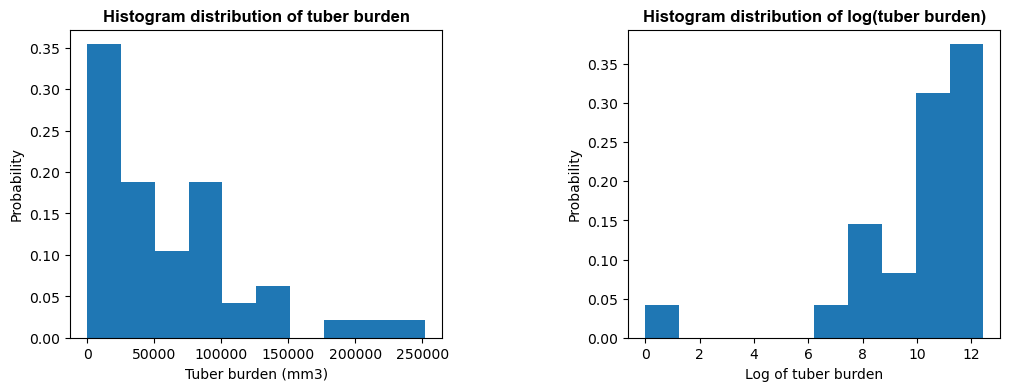

In [54]:
# Gray matter
plt.figure(figsize=(12, 4))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(wspace=0.5, hspace=0.5)
plt.subplot(gs1[0])
weights_gray_matter = np.ones_like(tuber_burden_gray_matter) / (len(tuber_burden_gray_matter))
plt.hist(tuber_burden_gray_matter, weights=weights_gray_matter)
plt.title('Histogram distribution of tuber burden', fontsize=12, weight='bold', fontname='Arial')
plt.xlabel('Tuber burden (mm3)')
plt.ylabel('Probability')

plt.subplot(gs1[1])
weights_gray_matter_log = np.ones_like(np.clip(np.log(tuber_burden_gray_matter), 0, None)) / (len(np.clip(np.log(tuber_burden_gray_matter), 0, None)))
plt.hist(np.clip(np.log(tuber_burden_gray_matter), 0, None), weights=weights_gray_matter_log)
plt.title('Histogram distribution of log(tuber burden)', fontsize=12, weight='bold', fontname='Arial')
plt.xlabel('Log of tuber burden')
plt.ylabel('Probability')

plt.show()

#### Left frontal

In [55]:
# Left frontal
plt.figure(figsize=(12, 4))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(wspace=0.5, hspace=0.5)
plt.subplot(gs1[0])
weights_L_frontal = np.ones_like(tuber_burden_L_frontal) / (len(tuber_burden_L_frontal))
plt.hist(tuber_burden_L_frontal, weights=weights_L_frontal)
plt.title('Histogram distribution of tuber burden', fontsize=12, weight='bold', fontname='Arial')
plt.xlabel('Tuber burden (mm3)')
plt.ylabel('Probability')

plt.subplot(gs1[1])
weights_L_frontal_log = np.ones_like(np.clip(np.log(tuber_burden_L_frontal), 0, None)) / (len(np.clip(np.log(tuber_burden_L_frontal), 0, None)))
plt.hist(np.clip(np.log(tuber_burden_L_frontal), 0, None), weights=weights_L_frontal_log)
plt.title('Histogram distribution of log(tuber burden)', fontsize=12, weight='bold', fontname='Arial')
plt.xlabel('Log of tuber burden')
plt.ylabel('Probability')

plt.show()

/tmp/ipykernel_554520/1032524125.py:13: RuntimeWarning: divide by zero encountered in log
  weights_L_frontal_log = np.ones_like(np.clip(np.log(tuber_burden_L_frontal), 0, None)) / (len(np.clip(np.log(tuber_burden_L_frontal), 0, None)))
/tmp/ipykernel_554520/1032524125.py:14: RuntimeWarning: divide by zero encountered in log
  plt.hist(np.clip(np.log(tuber_burden_L_frontal), 0, None), weights=weights_L_frontal_log)


In [56]:
#### Right frontal

/tmp/ipykernel_554520/3402897607.py:13: RuntimeWarning: divide by zero encountered in log
  weights_R_frontal_log = np.ones_like(np.clip(np.log(tuber_burden_R_frontal), 0, None)) / (len(np.clip(np.log(tuber_burden_R_frontal), 0, None)))
/tmp/ipykernel_554520/3402897607.py:14: RuntimeWarning: divide by zero encountered in log
  plt.hist(np.clip(np.log(tuber_burden_R_frontal), 0, None), weights=weights_R_frontal_log)


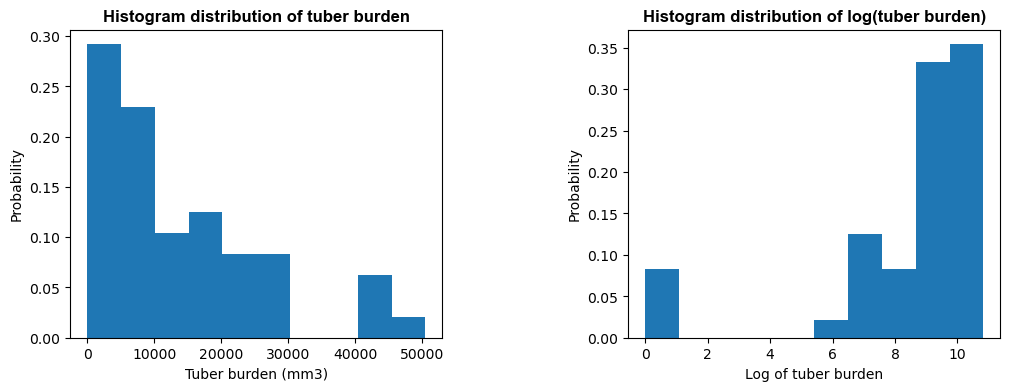

In [57]:
# Right frontal
plt.figure(figsize=(12, 4))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(wspace=0.5, hspace=0.5)
plt.subplot(gs1[0])
weights_R_frontal = np.ones_like(tuber_burden_R_frontal) / (len(tuber_burden_R_frontal))
plt.hist(tuber_burden_R_frontal, weights=weights_R_frontal)
plt.title('Histogram distribution of tuber burden', fontsize=12, weight='bold', fontname='Arial')
plt.xlabel('Tuber burden (mm3)')
plt.ylabel('Probability')

plt.subplot(gs1[1])
weights_R_frontal_log = np.ones_like(np.clip(np.log(tuber_burden_R_frontal), 0, None)) / (len(np.clip(np.log(tuber_burden_R_frontal), 0, None)))
plt.hist(np.clip(np.log(tuber_burden_R_frontal), 0, None), weights=weights_R_frontal_log)
plt.title('Histogram distribution of log(tuber burden)', fontsize=12, weight='bold', fontname='Arial')
plt.xlabel('Log of tuber burden')
plt.ylabel('Probability')

plt.show()

#### Left temporal

/tmp/ipykernel_554520/426736753.py:13: RuntimeWarning: divide by zero encountered in log
  weights_L_temporal_log = np.ones_like(np.clip(np.log(tuber_burden_L_temporal), 0, None)) / (len(np.clip(np.log(tuber_burden_L_temporal), 0, None)))
/tmp/ipykernel_554520/426736753.py:14: RuntimeWarning: divide by zero encountered in log
  plt.hist(np.clip(np.log(tuber_burden_L_temporal), 0, None), weights=weights_L_temporal_log)


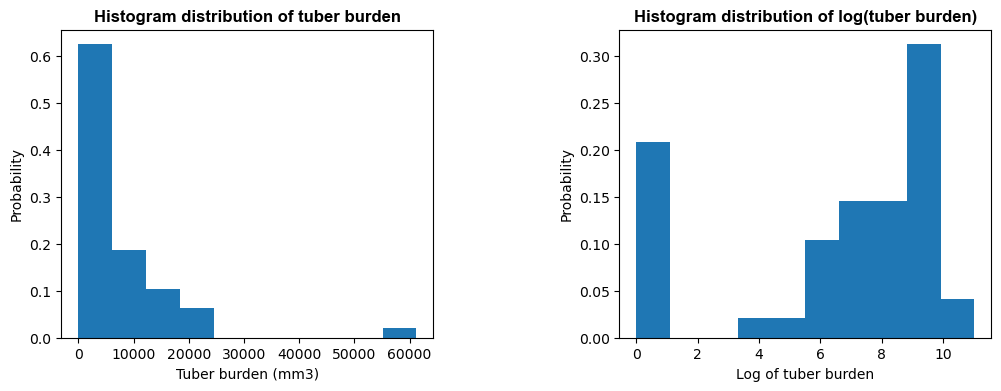

In [58]:
# Left temporal
plt.figure(figsize=(12, 4))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(wspace=0.5, hspace=0.5)
plt.subplot(gs1[0])
weights_L_temporal = np.ones_like(tuber_burden_L_temporal) / (len(tuber_burden_L_temporal))
plt.hist(tuber_burden_L_temporal, weights=weights_L_temporal)
plt.title('Histogram distribution of tuber burden', fontsize=12, weight='bold', fontname='Arial')
plt.xlabel('Tuber burden (mm3)')
plt.ylabel('Probability')

plt.subplot(gs1[1])
weights_L_temporal_log = np.ones_like(np.clip(np.log(tuber_burden_L_temporal), 0, None)) / (len(np.clip(np.log(tuber_burden_L_temporal), 0, None)))
plt.hist(np.clip(np.log(tuber_burden_L_temporal), 0, None), weights=weights_L_temporal_log)
plt.title('Histogram distribution of log(tuber burden)', fontsize=12, weight='bold', fontname='Arial')
plt.xlabel('Log of tuber burden')
plt.ylabel('Probability')

plt.show()

#### Right temporal

/tmp/ipykernel_554520/2725579684.py:13: RuntimeWarning: divide by zero encountered in log
  weights_R_temporal_log = np.ones_like(np.clip(np.log(tuber_burden_R_temporal), 0, None)) / (len(np.clip(np.log(tuber_burden_R_temporal), 0, None)))
/tmp/ipykernel_554520/2725579684.py:14: RuntimeWarning: divide by zero encountered in log
  plt.hist(np.clip(np.log(tuber_burden_R_temporal), 0, None), weights=weights_R_temporal_log)


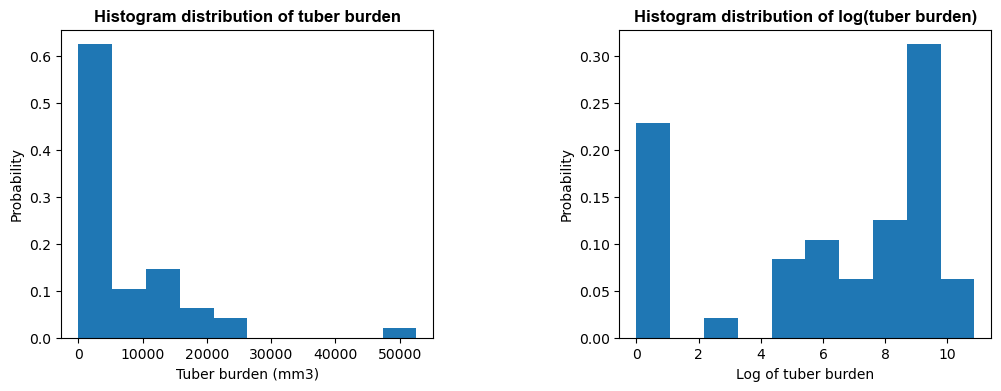

In [59]:
# Right temporal
plt.figure(figsize=(12, 4))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(wspace=0.5, hspace=0.5)
plt.subplot(gs1[0])
weights_R_temporal = np.ones_like(tuber_burden_R_temporal) / (len(tuber_burden_R_temporal))
plt.hist(tuber_burden_R_temporal, weights=weights_R_temporal)
plt.title('Histogram distribution of tuber burden', fontsize=12, weight='bold', fontname='Arial')
plt.xlabel('Tuber burden (mm3)')
plt.ylabel('Probability')

plt.subplot(gs1[1])
weights_R_temporal_log = np.ones_like(np.clip(np.log(tuber_burden_R_temporal), 0, None)) / (len(np.clip(np.log(tuber_burden_R_temporal), 0, None)))
plt.hist(np.clip(np.log(tuber_burden_R_temporal), 0, None), weights=weights_R_temporal_log)
plt.title('Histogram distribution of log(tuber burden)', fontsize=12, weight='bold', fontname='Arial')
plt.xlabel('Log of tuber burden')
plt.ylabel('Probability')

plt.show()

#### Left parietal

/tmp/ipykernel_554520/3072565122.py:13: RuntimeWarning: divide by zero encountered in log
  weights_L_parietal_log = np.ones_like(np.clip(np.log(tuber_burden_L_parietal), 0, None)) / (len(np.clip(np.log(tuber_burden_L_parietal), 0, None)))
/tmp/ipykernel_554520/3072565122.py:14: RuntimeWarning: divide by zero encountered in log
  plt.hist(np.clip(np.log(tuber_burden_L_parietal), 0, None), weights=weights_L_parietal_log)


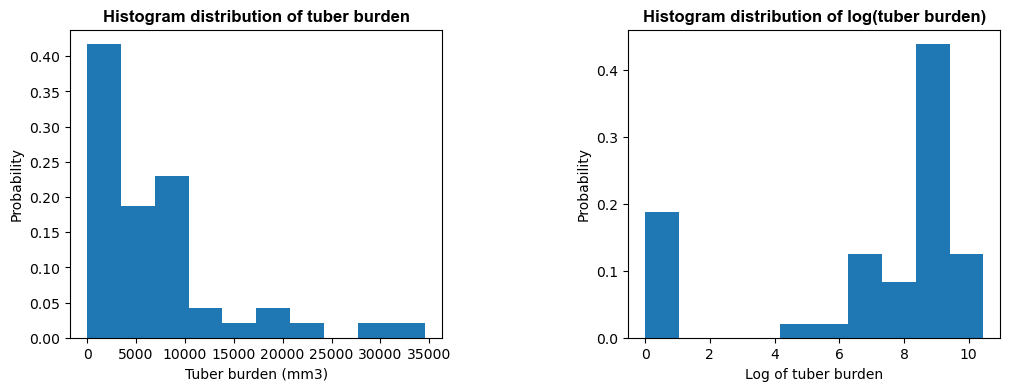

In [60]:
# Left parietal
plt.figure(figsize=(12, 4))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(wspace=0.5, hspace=0.5)
plt.subplot(gs1[0])
weights_L_parietal = np.ones_like(tuber_burden_L_parietal) / (len(tuber_burden_L_parietal))
plt.hist(tuber_burden_L_parietal, weights=weights_L_parietal)
plt.title('Histogram distribution of tuber burden', fontsize=12, weight='bold', fontname='Arial')
plt.xlabel('Tuber burden (mm3)')
plt.ylabel('Probability')

plt.subplot(gs1[1])
weights_L_parietal_log = np.ones_like(np.clip(np.log(tuber_burden_L_parietal), 0, None)) / (len(np.clip(np.log(tuber_burden_L_parietal), 0, None)))
plt.hist(np.clip(np.log(tuber_burden_L_parietal), 0, None), weights=weights_L_parietal_log)
plt.title('Histogram distribution of log(tuber burden)', fontsize=12, weight='bold', fontname='Arial')
plt.xlabel('Log of tuber burden')
plt.ylabel('Probability')

plt.show()

#### Right parietal

/tmp/ipykernel_554520/1967212496.py:13: RuntimeWarning: divide by zero encountered in log
  weights_R_parietal_log = np.ones_like(np.clip(np.log(tuber_burden_R_parietal), 0, None)) / (len(np.clip(np.log(tuber_burden_R_parietal), 0, None)))
/tmp/ipykernel_554520/1967212496.py:14: RuntimeWarning: divide by zero encountered in log
  plt.hist(np.clip(np.log(tuber_burden_R_parietal), 0, None), weights=weights_R_parietal_log)


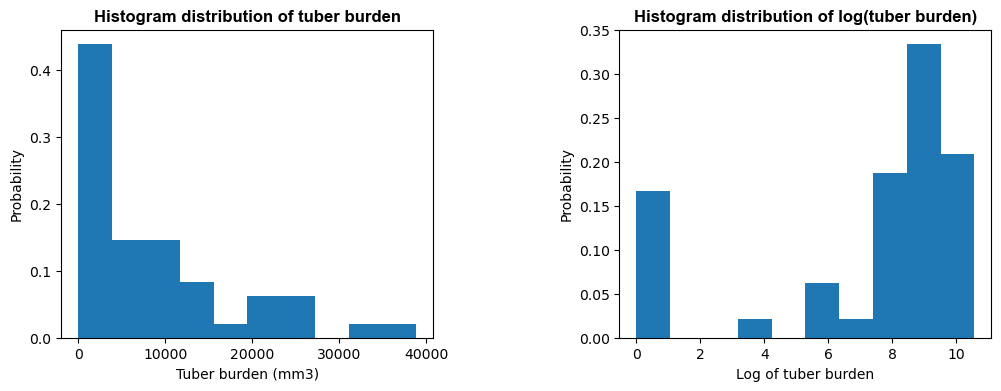

In [61]:
# Right parietal
plt.figure(figsize=(12, 4))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(wspace=0.5, hspace=0.5)
plt.subplot(gs1[0])
weights_R_parietal = np.ones_like(tuber_burden_R_parietal) / (len(tuber_burden_R_parietal))
plt.hist(tuber_burden_R_parietal, weights=weights_R_parietal)
plt.title('Histogram distribution of tuber burden', fontsize=12, weight='bold', fontname='Arial')
plt.xlabel('Tuber burden (mm3)')
plt.ylabel('Probability')

plt.subplot(gs1[1])
weights_R_parietal_log = np.ones_like(np.clip(np.log(tuber_burden_R_parietal), 0, None)) / (len(np.clip(np.log(tuber_burden_R_parietal), 0, None)))
plt.hist(np.clip(np.log(tuber_burden_R_parietal), 0, None), weights=weights_R_parietal_log)
plt.title('Histogram distribution of log(tuber burden)', fontsize=12, weight='bold', fontname='Arial')
plt.xlabel('Log of tuber burden')
plt.ylabel('Probability')

plt.show()

#### Left occipital

/tmp/ipykernel_554520/2054574053.py:13: RuntimeWarning: divide by zero encountered in log
  weights_L_occipital_log = np.ones_like(np.clip(np.log(tuber_burden_L_occipital), 0, None)) / (len(np.clip(np.log(tuber_burden_L_occipital), 0, None)))
/tmp/ipykernel_554520/2054574053.py:14: RuntimeWarning: divide by zero encountered in log
  plt.hist(np.clip(np.log(tuber_burden_L_occipital), 0, None), weights=weights_L_occipital_log)


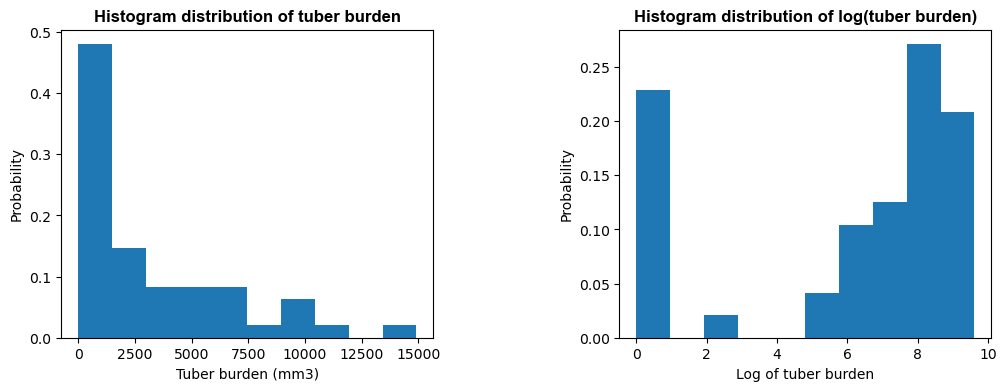

In [62]:
# Left occipital
plt.figure(figsize=(12, 4))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(wspace=0.5, hspace=0.5)
plt.subplot(gs1[0])
weights_L_occipital = np.ones_like(tuber_burden_L_occipital) / (len(tuber_burden_L_occipital))
plt.hist(tuber_burden_L_occipital, weights=weights_L_occipital)
plt.title('Histogram distribution of tuber burden', fontsize=12, weight='bold', fontname='Arial')
plt.xlabel('Tuber burden (mm3)')
plt.ylabel('Probability')

plt.subplot(gs1[1])
weights_L_occipital_log = np.ones_like(np.clip(np.log(tuber_burden_L_occipital), 0, None)) / (len(np.clip(np.log(tuber_burden_L_occipital), 0, None)))
plt.hist(np.clip(np.log(tuber_burden_L_occipital), 0, None), weights=weights_L_occipital_log)
plt.title('Histogram distribution of log(tuber burden)', fontsize=12, weight='bold', fontname='Arial')
plt.xlabel('Log of tuber burden')
plt.ylabel('Probability')

plt.show()

#### Right occipital

/tmp/ipykernel_554520/3230110443.py:13: RuntimeWarning: divide by zero encountered in log
  weights_R_occipital_log = np.ones_like(np.clip(np.log(tuber_burden_R_occipital), 0, None)) / (len(np.clip(np.log(tuber_burden_R_occipital), 0, None)))
/tmp/ipykernel_554520/3230110443.py:14: RuntimeWarning: divide by zero encountered in log
  plt.hist(np.clip(np.log(tuber_burden_R_occipital), 0, None), weights=weights_R_occipital_log)


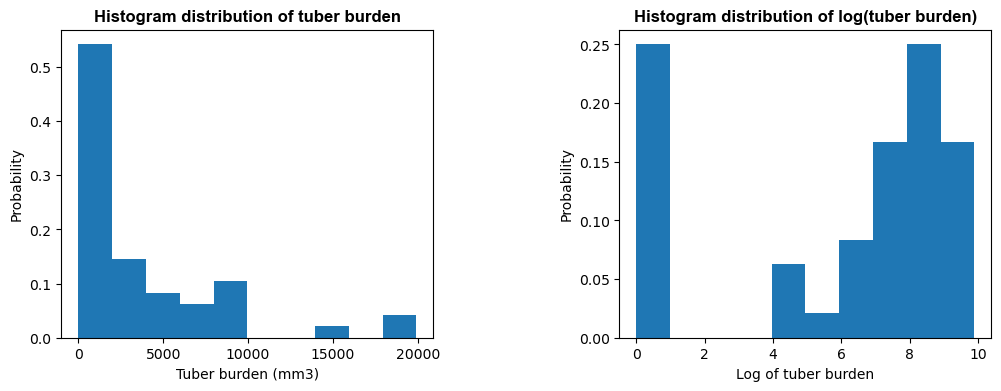

In [63]:
# Right occipital
plt.figure(figsize=(12, 4))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(wspace=0.5, hspace=0.5)
plt.subplot(gs1[0])
weights_R_occipital = np.ones_like(tuber_burden_R_occipital) / (len(tuber_burden_R_occipital))
plt.hist(tuber_burden_R_occipital, weights=weights_R_occipital)
plt.title('Histogram distribution of tuber burden', fontsize=12, weight='bold', fontname='Arial')
plt.xlabel('Tuber burden (mm3)')
plt.ylabel('Probability')

plt.subplot(gs1[1])
weights_R_occipital_log = np.ones_like(np.clip(np.log(tuber_burden_R_occipital), 0, None)) / (len(np.clip(np.log(tuber_burden_R_occipital), 0, None)))
plt.hist(np.clip(np.log(tuber_burden_R_occipital), 0, None), weights=weights_R_occipital_log)
plt.title('Histogram distribution of log(tuber burden)', fontsize=12, weight='bold', fontname='Arial')
plt.xlabel('Log of tuber burden')
plt.ylabel('Probability')

plt.show()

<a id='tuberburdenDSSC'></a>

## Relationship between tuber burden and DSSC ↓↓ SCROLL DOWN ↓↓ 

In [64]:
# Calculate the tuber burden in each MRI (each 64 patches long)
tuber_burden = []
for i in range(int(Y_test.shape[0]/64)):
    tuber_burden_single_MRI = np.sum(Y_test[i*64:i*64+64, :, :, :, 0])
    # Collect the tuber burden from all MRIs
    tuber_burden.append(tuber_burden_single_MRI)

In [65]:
# Divide the brain MRIs into 4 quartiles based on tuber burden
sorted_tuber_burden = np.argsort(tuber_burden)
low_tuber_burden_MRIs = sorted_tuber_burden[:int(len(sorted_tuber_burden)*0.25)]
medium_low_tuber_burden_MRIs = sorted_tuber_burden[int(len(sorted_tuber_burden)*0.25):int(len(sorted_tuber_burden)*0.5)]
medium_high_tuber_burden_MRIs = sorted_tuber_burden[int(len(sorted_tuber_burden)*0.5):int(len(sorted_tuber_burden)*0.75)]
high_tuber_burden_MRIs = sorted_tuber_burden[int(len(sorted_tuber_burden)*0.75):]
print(
    'Low tuber volume metrics: median: ', np.median(np.array(tuber_burden)[low_tuber_burden_MRIs]),
      '; p25: ', np.quantile(np.array(tuber_burden)[low_tuber_burden_MRIs], 0.25),
      '; p75: ', np.quantile(np.array(tuber_burden)[low_tuber_burden_MRIs], 0.75),     
      '; mean: ', np.mean(np.array(tuber_burden)[low_tuber_burden_MRIs]),
      '; standard deviation: ', np.std(np.array(tuber_burden)[low_tuber_burden_MRIs]),
      '\n Medium-low tuber volume metrics: median: ', np.median(np.array(tuber_burden)[medium_low_tuber_burden_MRIs]),
      '; p25: ', np.quantile(np.array(tuber_burden)[medium_low_tuber_burden_MRIs], 0.25),
      '; p75: ', np.quantile(np.array(tuber_burden)[medium_low_tuber_burden_MRIs], 0.75),     
      '; mean: ', np.mean(np.array(tuber_burden)[medium_low_tuber_burden_MRIs]),
      '; standard deviation: ', np.std(np.array(tuber_burden)[medium_low_tuber_burden_MRIs]),
      '\n Medium-high tuber volume metrics: median: ', np.median(np.array(tuber_burden)[medium_high_tuber_burden_MRIs]),
      '; p25: ', np.quantile(np.array(tuber_burden)[medium_high_tuber_burden_MRIs], 0.25),
      '; p75: ', np.quantile(np.array(tuber_burden)[medium_high_tuber_burden_MRIs], 0.75),     
      '; mean: ', np.mean(np.array(tuber_burden)[medium_high_tuber_burden_MRIs]),
      '; standard deviation: ', np.std(np.array(tuber_burden)[medium_high_tuber_burden_MRIs]),
      '\n High tuber volume metrics: median: ', np.median(np.array(tuber_burden)[high_tuber_burden_MRIs]),
      '; p25: ', np.quantile(np.array(tuber_burden)[high_tuber_burden_MRIs], 0.25),
      '; p75: ', np.quantile(np.array(tuber_burden)[high_tuber_burden_MRIs], 0.75),     
      '; mean: ', np.mean(np.array(tuber_burden)[high_tuber_burden_MRIs]),
      '; standard deviation: ', np.std(np.array(tuber_burden)[high_tuber_burden_MRIs])   
     )

Low tuber volume metrics: median:  3782.0 ; p25:  1713.5 ; p75:  5106.75 ; mean:  4067.5 ; standard deviation:  3507.3481 
 Medium-low tuber volume metrics: median:  29170.0 ; p25:  22891.75 ; p75:  39680.5 ; mean:  31024.084 ; standard deviation:  10915.554 
 Medium-high tuber volume metrics: median:  73962.5 ; p25:  60613.5 ; p75:  90619.25 ; mean:  75411.25 ; standard deviation:  17453.389 
 High tuber volume metrics: median:  121915.5 ; p25:  105344.0 ; p75:  160320.25 ; mean:  147101.33 ; standard deviation:  55070.477


In [66]:
# Extract the low tuber burden MRIs
X_test_low_tuber_burden = np.zeros( (len(low_tuber_burden_MRIs)*64, SX, SY, SZ, n_channel_test), np.float32)
Y_test_low_tuber_burden = np.zeros( (len(low_tuber_burden_MRIs)*64, SX, SY, SZ, 1), np.uint8 )

j=0
for i in range(int(Y_test.shape[0]/64)):
    if i in low_tuber_burden_MRIs:
        X_test_low_tuber_burden[j*64:j*64+64, :, :, :, 0] = X_test[i*64:i*64+64, :, :, :, 0]
        X_test_low_tuber_burden[j*64:j*64+64, :, :, :, 1] = X_test[i*64:i*64+64, :, :, :, 1]
        X_test_low_tuber_burden[j*64:j*64+64, :, :, :, 2] = X_test[i*64:i*64+64, :, :, :, 2]
        Y_test_low_tuber_burden[j*64:j*64+64, :, :, :, 0] = Y_test[i*64:i*64+64, :, :, :, 0]
        j += 1

# Change the number type to float 32
Y_test_low_tuber_burden = Y_test_low_tuber_burden.astype(np.float32)

# Calculate the Dice coefficient in the low tuber burden MRIs
Y_predictions_low_tuber_burden = trained_u_cnn.predict(X_test_low_tuber_burden, batch_size=16)
Y_predictions_low_tuber_burden.shape, Y_test_low_tuber_burden.shape

# Define the threshold probability to call a tuber
Y_predictions_low_tuber_burden[Y_predictions_low_tuber_burden < 0.5] = 0.0
Y_predictions_low_tuber_burden[Y_predictions_low_tuber_burden >= 0.5] = 1.0

# Test Dice Coefficient
dice_coef(Y_test_low_tuber_burden, Y_predictions_low_tuber_burden)

48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.44299948>

In [67]:
# Extract the medium-low tuber burden MRIs
X_test_medium_low_tuber_burden = np.zeros( (len(medium_low_tuber_burden_MRIs)*64, SX, SY, SZ, n_channel_test), np.float32)
Y_test_medium_low_tuber_burden = np.zeros( (len(medium_low_tuber_burden_MRIs)*64, SX, SY, SZ, 1), np.uint8 )

j=0
for i in range(int(Y_test.shape[0]/64)):
    if i in medium_low_tuber_burden_MRIs:
        X_test_medium_low_tuber_burden[j*64:j*64+64, :, :, :, 0] = X_test[i*64:i*64+64, :, :, :, 0]
        X_test_medium_low_tuber_burden[j*64:j*64+64, :, :, :, 1] = X_test[i*64:i*64+64, :, :, :, 1]
        X_test_medium_low_tuber_burden[j*64:j*64+64, :, :, :, 2] = X_test[i*64:i*64+64, :, :, :, 2]
        Y_test_medium_low_tuber_burden[j*64:j*64+64, :, :, :, 0] = Y_test[i*64:i*64+64, :, :, :, 0]
        j += 1

# Change the number type to float 32
Y_test_medium_low_tuber_burden = Y_test_medium_low_tuber_burden.astype(np.float32)

# Calculate the Dice coefficient in the medium-low tuber burden MRIs
Y_predictions_medium_low_tuber_burden = trained_u_cnn.predict(X_test_medium_low_tuber_burden, batch_size=16)
Y_predictions_medium_low_tuber_burden.shape, Y_test_medium_low_tuber_burden.shape

# Define the threshold probability to call a tuber
Y_predictions_medium_low_tuber_burden[Y_predictions_medium_low_tuber_burden < 0.5] = 0.0
Y_predictions_medium_low_tuber_burden[Y_predictions_medium_low_tuber_burden >= 0.5] = 1.0

# Test Dice Coefficient
dice_coef(Y_test_medium_low_tuber_burden, Y_predictions_medium_low_tuber_burden)

48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.793262>

In [68]:
# Extract the medium-high tuber burden MRIs
X_test_medium_high_tuber_burden = np.zeros( (len(medium_high_tuber_burden_MRIs)*64, SX, SY, SZ, n_channel_test), np.float32)
Y_test_medium_high_tuber_burden = np.zeros( (len(medium_high_tuber_burden_MRIs)*64, SX, SY, SZ, 1), np.uint8 )

j=0
for i in range(int(Y_test.shape[0]/64)):
    if i in medium_high_tuber_burden_MRIs:
        X_test_medium_high_tuber_burden[j*64:j*64+64, :, :, :, 0] = X_test[i*64:i*64+64, :, :, :, 0]
        X_test_medium_high_tuber_burden[j*64:j*64+64, :, :, :, 1] = X_test[i*64:i*64+64, :, :, :, 1]
        X_test_medium_high_tuber_burden[j*64:j*64+64, :, :, :, 2] = X_test[i*64:i*64+64, :, :, :, 2]
        Y_test_medium_high_tuber_burden[j*64:j*64+64, :, :, :, 0] = Y_test[i*64:i*64+64, :, :, :, 0]
        j += 1

# Change the number type to float 32
Y_test_medium_high_tuber_burden = Y_test_medium_high_tuber_burden.astype(np.float32)

# Calculate the Dice coefficient in the medium-high tuber burden MRIs
Y_predictions_medium_high_tuber_burden = trained_u_cnn.predict(X_test_medium_high_tuber_burden, batch_size=16)
Y_predictions_medium_high_tuber_burden.shape, Y_test_medium_high_tuber_burden.shape

# Define the threshold probability to call a tuber
Y_predictions_medium_high_tuber_burden[Y_predictions_medium_high_tuber_burden < 0.5] = 0.0
Y_predictions_medium_high_tuber_burden[Y_predictions_medium_high_tuber_burden >= 0.5] = 1.0

# Test Dice Coefficient
dice_coef(Y_test_medium_high_tuber_burden, Y_predictions_medium_high_tuber_burden)

48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.84477687>

In [69]:
# Extract the high tuber burden MRIs
X_test_high_tuber_burden = np.zeros( (len(high_tuber_burden_MRIs)*64, SX, SY, SZ, n_channel_test), np.float32)
Y_test_high_tuber_burden = np.zeros( (len(high_tuber_burden_MRIs)*64, SX, SY, SZ, 1), np.uint8 )

j=0
for i in range(int(Y_test.shape[0]/64)):
    if i in high_tuber_burden_MRIs:
        X_test_high_tuber_burden[j*64:j*64+64, :, :, :, 0] = X_test[i*64:i*64+64, :, :, :, 0]
        X_test_high_tuber_burden[j*64:j*64+64, :, :, :, 1] = X_test[i*64:i*64+64, :, :, :, 1]
        X_test_high_tuber_burden[j*64:j*64+64, :, :, :, 2] = X_test[i*64:i*64+64, :, :, :, 2]
        Y_test_high_tuber_burden[j*64:j*64+64, :, :, :, 0] = Y_test[i*64:i*64+64, :, :, :, 0]
        j += 1

# Change the number type to float 32
Y_test_high_tuber_burden = Y_test_high_tuber_burden.astype(np.float32)

# Calculate the Dice coefficient in the high tuber burden MRIs
Y_predictions_high_tuber_burden = trained_u_cnn.predict(X_test_high_tuber_burden, batch_size=16)
Y_predictions_high_tuber_burden.shape, Y_test_high_tuber_burden.shape

# Define the threshold probability to call a tuber
Y_predictions_high_tuber_burden[Y_predictions_high_tuber_burden < 0.5] = 0.0
Y_predictions_high_tuber_burden[Y_predictions_high_tuber_burden >= 0.5] = 1.0

# Test Dice Coefficient
dice_coef(Y_test_high_tuber_burden, Y_predictions_high_tuber_burden)

48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.822065>

<a id='challengingcases'></a>

## DSSC in challenging cases ↓↓ SCROLL DOWN ↓↓ 

In [70]:
# Extract the different sequences
X_test_reshaped_T1 = X_test[:, :, :, :, 0]
X_test_reshaped_T2 = X_test[:, :, :, :, 1]
X_test_reshaped_FLAIR = X_test[:, :, :, :, 2]
Y_test_reshaped = Y_test[:, :, :, :, 0]
Y_predictions_reshaped = Y_predictions[:, :, :, :, 0]

In [71]:
# Modify shape of patches
i = 0 
X_test_full_images_T1 = np.zeros( (int(X_test_reshaped_T1.shape[0]/SX), SX_img, SY_img, SZ_img), np.float32)
X_test_full_images_T2 = np.zeros( (int(X_test_reshaped_T2.shape[0]/SX), SX_img, SY_img, SZ_img), np.float32)
X_test_full_images_FLAIR = np.zeros( (int(X_test_reshaped_FLAIR.shape[0]/SX), SX_img, SY_img, SZ_img), np.float32)
Y_test_full_images = np.zeros( (int(Y_test_reshaped.shape[0]/SX), SX_img, SY_img, SZ_img), np.uint8)
Y_predictions_full_images = np.zeros( (int(Y_predictions_reshaped.shape[0]/SX), SX_img, SY_img, SZ_img), np.uint8)

# Reconstruct the full images from their patches
while i < X_test.shape[0]:
    
    X_reshaped_patches_T1 = np.reshape(X_test_reshaped_T1[i:i+SX, :, :, :], (4, 4, 4, SX, SY, SZ))
    X_reconstructed_image_T1 = unpatchify(X_reshaped_patches_T1, (SX_img, SY_img, SZ_img))
    X_reconstructed_image_T1 = np.transpose(X_reconstructed_image_T1, [0, 1, 2])
    X_reconstructed_image_T1 = np.flip(X_reconstructed_image_T1, axis=(0,1))
    X_test_full_images_T1[int(i/64), :, :, :] =  X_reconstructed_image_T1

    X_reshaped_patches_T2 = np.reshape(X_test_reshaped_T2[i:i+SX, :, :, :], (4, 4, 4, SX, SY, SZ))
    X_reconstructed_image_T2 = unpatchify(X_reshaped_patches_T2, (SX_img, SY_img, SZ_img))
    X_reconstructed_image_T2 = np.transpose(X_reconstructed_image_T2, [0, 1, 2])
    X_reconstructed_image_T2 = np.flip(X_reconstructed_image_T2, axis=(0,1))
    X_test_full_images_T2[int(i/64), :, :, :] =  X_reconstructed_image_T2

    X_reshaped_patches_FLAIR = np.reshape(X_test_reshaped_FLAIR[i:i+SX, :, :, :], (4, 4, 4, SX, SY, SZ))
    X_reconstructed_image_FLAIR = unpatchify(X_reshaped_patches_FLAIR, (SX_img, SY_img, SZ_img))
    X_reconstructed_image_FLAIR = np.transpose(X_reconstructed_image_FLAIR, [0, 1, 2])
    X_reconstructed_image_FLAIR = np.flip(X_reconstructed_image_FLAIR, axis=(0,1))
    X_test_full_images_FLAIR[int(i/64), :, :, :] =  X_reconstructed_image_FLAIR
    
    Y_test_reshaped_patches = np.reshape(Y_test_reshaped[i:i+SX, :, :, :], (4, 4, 4, SX, SY, SZ))
    Y_test_reconstructed_image = unpatchify(Y_test_reshaped_patches, (SX_img, SY_img, SZ_img))
    Y_test_reconstructed_image = np.transpose(Y_test_reconstructed_image, [0, 1, 2])
    Y_test_reconstructed_image = np.flip(Y_test_reconstructed_image, axis=(0,1))
    Y_test_full_images[int(i/64), :, :, :] =  Y_test_reconstructed_image 
 
    Y_predictions_reshaped_patches = np.reshape(Y_predictions_reshaped[i:i+SX, :, :, :], (4, 4, 4, SX, SY, SZ))
    Y_predictions_reconstructed_image = unpatchify(Y_predictions_reshaped_patches, (SX_img, SY_img, SZ_img))
    Y_predictions_reconstructed_image = np.transpose(Y_predictions_reconstructed_image, [0, 1, 2])
    Y_predictions_reconstructed_image = np.flip(Y_predictions_reconstructed_image, axis=(0,1))
    Y_predictions_full_images[int(i/64), :, :, :] =  Y_predictions_reconstructed_image 
    
    i += SX

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


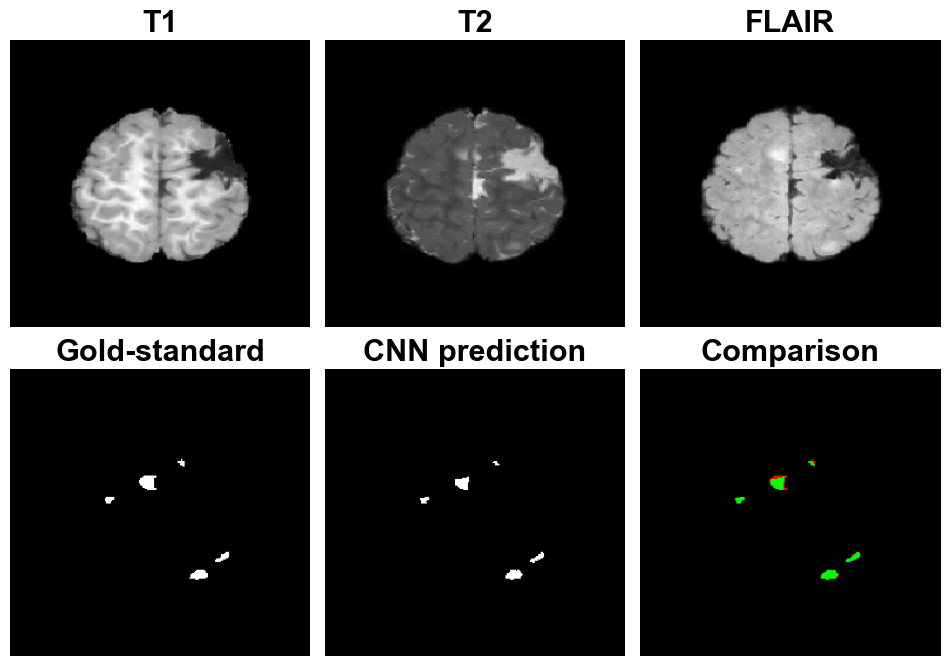

In [72]:
# Challenging case 1: a case with a large surgical cavity (case 31, index 11)
test_T1_img = X_test_full_images_T1[11, :, :, 180]
test_T2_img = X_test_full_images_T2[11, :, :, 180]
test_FLAIR_img = X_test_full_images_FLAIR[11, :, :, 180]
true_mask = Y_test_full_images[11, :, :, 180]
predicted_mask = Y_predictions_full_images[11, :, :, 180]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

In [73]:
# Calculate the Dice coefficient in a case with a large surgical cavity (case 31, index 11)
Y_predictions_challenging_case_1 = trained_u_cnn.predict(X_test[11*64:11*64+64, :, :, :, :], batch_size=16)

# Define the threshold probability to call a tuber
Y_predictions_challenging_case_1[Y_predictions_challenging_case_1 < 0.5] = 0.0
Y_predictions_challenging_case_1[Y_predictions_challenging_case_1 >= 0.5] = 1.0

# Test Dice Coefficient
dice_coef(Y_test[11*64:11*64+64, :, :, :, :], Y_predictions_challenging_case_1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.8806642>

In [74]:
# Challenging case 2: a case with a large LITT ablation cavity (case 109, index 32)
test_T1_img = X_test_full_images_T1[32, :, :, 155]
test_T2_img = X_test_full_images_T2[32, :, :, 155]
test_FLAIR_img = X_test_full_images_FLAIR[32, :, :, 155]
true_mask = Y_test_full_images[32, :, :, 155]
predicted_mask = Y_predictions_full_images[32, :, :, 155]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [75]:
# Calculate the Dice coefficient in a case with a large surgical cavity (case 109, index 32)
Y_predictions_challenging_case_2 = trained_u_cnn.predict(X_test[32*64:32*64+64, :, :, :, :], batch_size=16)

# Define the threshold probability to call a tuber
Y_predictions_challenging_case_2[Y_predictions_challenging_case_2 < 0.5] = 0.0
Y_predictions_challenging_case_2[Y_predictions_challenging_case_2 >= 0.5] = 1.0

# Test Dice Coefficient
dice_coef(Y_test[32*64:32*64+64, :, :, :, :], Y_predictions_challenging_case_2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.18052381>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


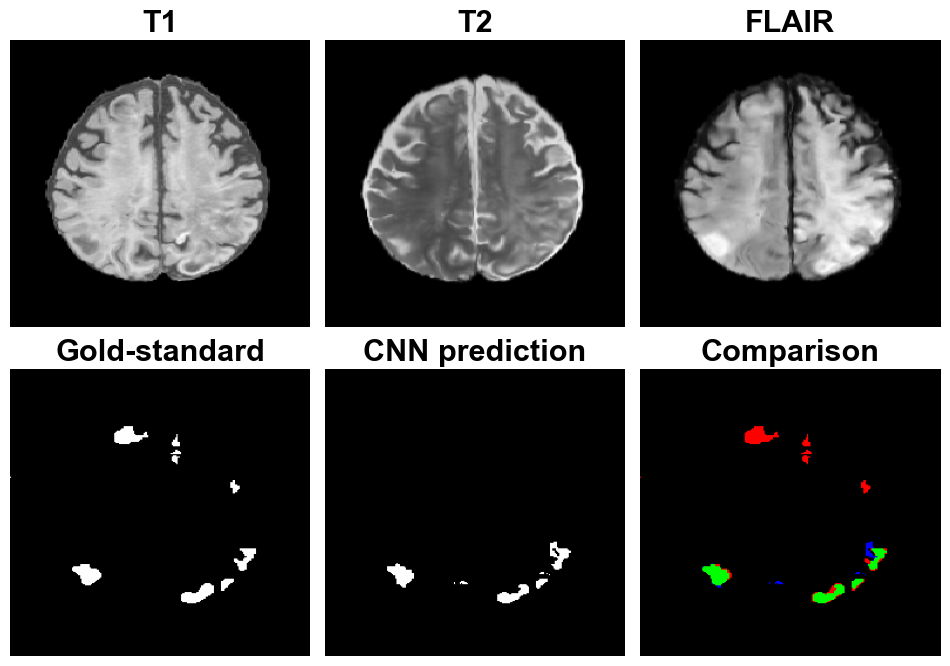

In [76]:
# Challenging case 3: a case with diffuse atrophy and gliosis (case 152, index 39)
test_T1_img = X_test_full_images_T1[39, :, :, 150]
test_T2_img = X_test_full_images_T2[39, :, :, 150]
test_FLAIR_img = X_test_full_images_FLAIR[39, :, :, 150]
true_mask = Y_test_full_images[39, :, :, 150]
predicted_mask = Y_predictions_full_images[39, :, :, 150]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

In [77]:
# Calculate the Dice coefficient in a case with a large surgical cavity (case 152, index 39)
Y_predictions_challenging_case_3 = trained_u_cnn.predict(X_test[39*64:39*64+64, :, :, :, :], batch_size=16)

# Define the threshold probability to call a tuber
Y_predictions_challenging_case_3[Y_predictions_challenging_case_3 < 0.5] = 0.0
Y_predictions_challenging_case_3[Y_predictions_challenging_case_3 >= 0.5] = 1.0

# Test Dice Coefficient
dice_coef(Y_test[39*64:39*64+64, :, :, :, :], Y_predictions_challenging_case_3)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.66744995>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


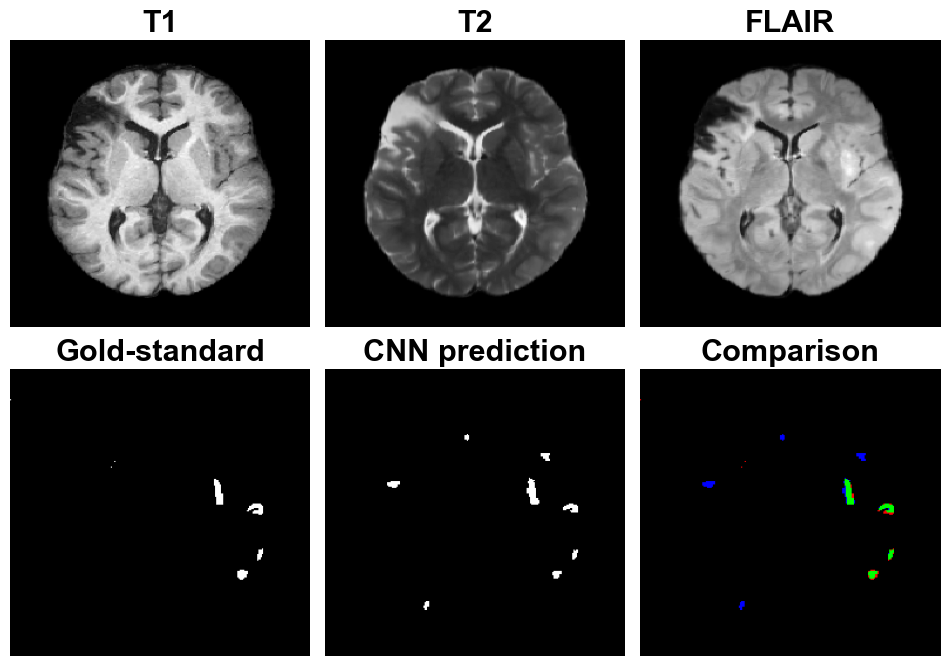

In [78]:
# Challenging case 4: a case with diffuse atrophy and gliosis (case 233, index 47)
test_T1_img = X_test_full_images_T1[47, :, :, 110]
test_T2_img = X_test_full_images_T2[47, :, :, 110]
test_FLAIR_img = X_test_full_images_FLAIR[47, :, :, 110]
true_mask = Y_test_full_images[47, :, :, 110]
predicted_mask = Y_predictions_full_images[47, :, :, 110]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

In [79]:
# Calculate the Dice coefficient in a case with a large surgical cavity (case 233, index 47)
Y_predictions_challenging_case_4 = trained_u_cnn.predict(X_test[47*64:47*64+64, :, :, :, :], batch_size=16)

# Define the threshold probability to call a tuber
Y_predictions_challenging_case_4[Y_predictions_challenging_case_4 < 0.5] = 0.0
Y_predictions_challenging_case_4[Y_predictions_challenging_case_4 >= 0.5] = 1.0

# Test Dice Coefficient
dice_coef(Y_test[47*64:47*64+64, :, :, :, :], Y_predictions_challenging_case_4)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.7777532>

## Import demographics

In [80]:
# Import demographics
demographic_data = pd.read_csv('/home/ch134560/data/extracted_data.csv')

<a id='DSSCbysex'></a>

## DSSC by sex ↓↓ SCROLL DOWN ↓↓ 

In [81]:
# Males and females
list(demographic_data['male_sex_at_birth']).count('yes'), list(demographic_data['male_sex_at_birth']).count('no')

(22, 26)

In [82]:
# Extract the male patient MRIs
X_test_male = np.zeros( (list(demographic_data['male_sex_at_birth']).count('yes')*64, SX, SY, SZ, n_channel_test), np.float32)
Y_test_male = np.zeros( (list(demographic_data['male_sex_at_birth']).count('yes')*64, SX, SY, SZ, 1), np.uint8 )

# Indexes of male patients
male_patients = [index for index, element in enumerate(list(demographic_data['male_sex_at_birth'])) if element == 'yes']

j=0
for i in range(int(Y_test.shape[0]/64)):
    if i in male_patients:
        X_test_male[j*64:j*64+64, :, :, :, 0] = X_test[i*64:i*64+64, :, :, :, 0]
        X_test_male[j*64:j*64+64, :, :, :, 1] = X_test[i*64:i*64+64, :, :, :, 1]
        X_test_male[j*64:j*64+64, :, :, :, 2] = X_test[i*64:i*64+64, :, :, :, 2]
        Y_test_male[j*64:j*64+64, :, :, :, 0] = Y_test[i*64:i*64+64, :, :, :, 0]
        j += 1

# Change the number type to float 32
Y_test_male = Y_test_male.astype(np.float32)

# Calculate the Dice coefficient in the male patient MRIs
Y_predictions_male = trained_u_cnn.predict(X_test_male, batch_size=16)
Y_predictions_male.shape, Y_test_male.shape

# Define the threshold probability to call a tuber
Y_predictions_male[Y_predictions_male < 0.5] = 0.0
Y_predictions_male[Y_predictions_male >= 0.5] = 1.0

# Test Dice Coefficient
dice_coef(Y_test_male, Y_predictions_male)

88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.8231805>

In [83]:
# Extract the female patient MRIs
X_test_female = np.zeros( (list(demographic_data['male_sex_at_birth']).count('no')*64, SX, SY, SZ, n_channel_test), np.float32)
Y_test_female = np.zeros( (list(demographic_data['male_sex_at_birth']).count('no')*64, SX, SY, SZ, 1), np.uint8 )

# Indexes of female patients
female_patients = [index for index, element in enumerate(list(demographic_data['male_sex_at_birth'])) if element == 'no']

j=0
for i in range(int(Y_test.shape[0]/64)):
    if i in female_patients:
        X_test_female[j*64:j*64+64, :, :, :, 0] = X_test[i*64:i*64+64, :, :, :, 0]
        X_test_female[j*64:j*64+64, :, :, :, 1] = X_test[i*64:i*64+64, :, :, :, 1]
        X_test_female[j*64:j*64+64, :, :, :, 2] = X_test[i*64:i*64+64, :, :, :, 2]
        Y_test_female[j*64:j*64+64, :, :, :, 0] = Y_test[i*64:i*64+64, :, :, :, 0]
        j += 1

# Change the number type to float 32
Y_test_female = Y_test_female.astype(np.float32)

# Calculate the Dice coefficient in the female patient MRIs
Y_predictions_female = trained_u_cnn.predict(X_test_female, batch_size=16)
Y_predictions_female.shape, Y_test_female.shape

# Define the threshold probability to call a tuber
Y_predictions_female[Y_predictions_female < 0.5] = 0.0
Y_predictions_female[Y_predictions_female >= 0.5] = 1.0

# Test Dice Coefficient
dice_coef(Y_test_female, Y_predictions_female)

104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.81838256>

<a id='DSSCbyage'></a>

## DSSC by age ↓↓ SCROLL DOWN ↓↓ 

In [84]:
# Median and patients below and above the median
np.median(list(demographic_data['age_at_MRI'])), len([element for element in list(demographic_data['age_at_MRI']) if element <= np.median(list(demographic_data['age_at_MRI']))]), len([element for element in list(demographic_data['age_at_MRI']) if element > np.median(list(demographic_data['age_at_MRI']))])

(2.99, 24, 24)

In [85]:
# Extract the MRIs with age below the median
X_test_young = np.zeros( (len([element for element in list(demographic_data['age_at_MRI']) if element <= np.median(list(demographic_data['age_at_MRI']))])*64, SX, SY, SZ, n_channel_test), np.float32)
Y_test_young = np.zeros( (len([element for element in list(demographic_data['age_at_MRI']) if element <= np.median(list(demographic_data['age_at_MRI']))])*64, SX, SY, SZ, 1), np.uint8 )

# Indexes of young patients (age below median)
young_patients = [index for index, element in enumerate(list(demographic_data['age_at_MRI'])) if element <= np.median(list(demographic_data['age_at_MRI']))]

j=0
for i in range(int(Y_test.shape[0]/64)):
    if i in young_patients:
        X_test_young[j*64:j*64+64, :, :, :, 0] = X_test[i*64:i*64+64, :, :, :, 0]
        X_test_young[j*64:j*64+64, :, :, :, 1] = X_test[i*64:i*64+64, :, :, :, 1]
        X_test_young[j*64:j*64+64, :, :, :, 2] = X_test[i*64:i*64+64, :, :, :, 2]
        Y_test_young[j*64:j*64+64, :, :, :, 0] = Y_test[i*64:i*64+64, :, :, :, 0]
        j += 1

# Change the number type to float 32
Y_test_young = Y_test_young.astype(np.float32)

# Calculate the Dice coefficient in the young patient MRIs
Y_predictions_young = trained_u_cnn.predict(X_test_young, batch_size=16)
Y_predictions_young.shape, Y_test_young.shape

# Define the threshold probability to call a tuber
Y_predictions_young[Y_predictions_young < 0.5] = 0.0
Y_predictions_young[Y_predictions_young >= 0.5] = 1.0

# Test Dice Coefficient
dice_coef(Y_test_young, Y_predictions_young)

96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.79659504>

In [86]:
# Extract the MRIs with age above the median
X_test_old = np.zeros( (len([element for element in list(demographic_data['age_at_MRI']) if element > np.median(list(demographic_data['age_at_MRI']))])*64, SX, SY, SZ, n_channel_test), np.float32)
Y_test_old = np.zeros( (len([element for element in list(demographic_data['age_at_MRI']) if element > np.median(list(demographic_data['age_at_MRI']))])*64, SX, SY, SZ, 1), np.uint8 )

# Indexes of old patients (age below median)
old_patients = [index for index, element in enumerate(list(demographic_data['age_at_MRI'])) if element > np.median(list(demographic_data['age_at_MRI']))]

j=0
for i in range(int(Y_test.shape[0]/64)):
    if i in old_patients:
        X_test_old[j*64:j*64+64, :, :, :, 0] = X_test[i*64:i*64+64, :, :, :, 0]
        X_test_old[j*64:j*64+64, :, :, :, 1] = X_test[i*64:i*64+64, :, :, :, 1]
        X_test_old[j*64:j*64+64, :, :, :, 2] = X_test[i*64:i*64+64, :, :, :, 2]
        Y_test_old[j*64:j*64+64, :, :, :, 0] = Y_test[i*64:i*64+64, :, :, :, 0]
        j += 1

# Change the number type to float 32
Y_test_old = Y_test_old.astype(np.float32)

# Calculate the Dice coefficient in the old patient MRIs
Y_predictions_old = trained_u_cnn.predict(X_test_old, batch_size=16)
Y_predictions_old.shape, Y_test_old.shape

# Define the threshold probability to call a tuber
Y_predictions_old[Y_predictions_old < 0.5] = 0.0
Y_predictions_old[Y_predictions_old >= 0.5] = 1.0

# Test Dice Coefficient
dice_coef(Y_test_old, Y_predictions_old)

96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.8536212>

<a id='DSSCbycenter'></a>

## DSSC by center ↓↓ SCROLL DOWN ↓↓ 

In [87]:
# TACERN, BCH, RDCRN 
list(demographic_data['Original data set']).count('TACERN'), list(demographic_data['Original data set']).count('BCH'), list(demographic_data['Original data set']).count('RDCRN')

(38, 5, 5)

In [88]:
# Extract the TACERN patient MRIs
X_test_TACERN = np.zeros( (list(demographic_data['Original data set']).count('TACERN')*64, SX, SY, SZ, n_channel_test), np.float32)
Y_test_TACERN = np.zeros( (list(demographic_data['Original data set']).count('TACERN')*64, SX, SY, SZ, 1), np.uint8 )

# Indexes of TACERN patients
TACERN_patients = [index for index, element in enumerate(list(demographic_data['Original data set'])) if element == 'TACERN']

j=0
for i in range(int(Y_test.shape[0]/64)):
    if i in TACERN_patients:
        X_test_TACERN[j*64:j*64+64, :, :, :, 0] = X_test[i*64:i*64+64, :, :, :, 0]
        X_test_TACERN[j*64:j*64+64, :, :, :, 1] = X_test[i*64:i*64+64, :, :, :, 1]
        X_test_TACERN[j*64:j*64+64, :, :, :, 2] = X_test[i*64:i*64+64, :, :, :, 2]
        Y_test_TACERN[j*64:j*64+64, :, :, :, 0] = Y_test[i*64:i*64+64, :, :, :, 0]
        j += 1

# Change the number type to float 32
Y_test_TACERN = Y_test_TACERN.astype(np.float32)

# Calculate the Dice coefficient in the TACERN patient MRIs
Y_predictions_TACERN = trained_u_cnn.predict(X_test_TACERN, batch_size=16)
Y_predictions_TACERN.shape, Y_test_TACERN.shape

# Define the threshold probability to call a tuber
Y_predictions_TACERN[Y_predictions_TACERN < 0.5] = 0.0
Y_predictions_TACERN[Y_predictions_TACERN >= 0.5] = 1.0

# Test Dice Coefficient
dice_coef(Y_test_TACERN, Y_predictions_TACERN)

152/152 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.8260295>

In [89]:
# Extract the BCH patient MRIs
X_test_BCH = np.zeros( (list(demographic_data['Original data set']).count('BCH')*64, SX, SY, SZ, n_channel_test), np.float32)
Y_test_BCH = np.zeros( (list(demographic_data['Original data set']).count('BCH')*64, SX, SY, SZ, 1), np.uint8 )

# Indexes of BCH patients
BCH_patients = [index for index, element in enumerate(list(demographic_data['Original data set'])) if element == 'BCH']

j=0
for i in range(int(Y_test.shape[0]/64)):
    if i in BCH_patients:
        X_test_BCH[j*64:j*64+64, :, :, :, 0] = X_test[i*64:i*64+64, :, :, :, 0]
        X_test_BCH[j*64:j*64+64, :, :, :, 1] = X_test[i*64:i*64+64, :, :, :, 1]
        X_test_BCH[j*64:j*64+64, :, :, :, 2] = X_test[i*64:i*64+64, :, :, :, 2]
        Y_test_BCH[j*64:j*64+64, :, :, :, 0] = Y_test[i*64:i*64+64, :, :, :, 0]
        j += 1

# Change the number type to float 32
Y_test_BCH = Y_test_BCH.astype(np.float32)

# Calculate the Dice coefficient in the BCH patient MRIs
Y_predictions_BCH = trained_u_cnn.predict(X_test_BCH, batch_size=16)
Y_predictions_BCH.shape, Y_test_BCH.shape

# Define the threshold probability to call a tuber
Y_predictions_BCH[Y_predictions_BCH < 0.5] = 0.0
Y_predictions_BCH[Y_predictions_BCH >= 0.5] = 1.0

# Test Dice Coefficient
dice_coef(Y_test_BCH, Y_predictions_BCH)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.779504>

In [90]:
# Extract the RDCRN patient MRIs
X_test_RDCRN = np.zeros( (list(demographic_data['Original data set']).count('RDCRN')*64, SX, SY, SZ, n_channel_test), np.float32)
Y_test_RDCRN = np.zeros( (list(demographic_data['Original data set']).count('RDCRN')*64, SX, SY, SZ, 1), np.uint8 )

# Indexes of RDCRN patients
RDCRN_patients = [index for index, element in enumerate(list(demographic_data['Original data set'])) if element == 'RDCRNRDCRNRDCRN']

j=0
for i in range(int(Y_test.shape[0]/64)):
    if i in RDCRN_patients:
        X_test_RDCRN[j*64:j*64+64, :, :, :, 0] = X_test[i*64:i*64+64, :, :, :, 0]
        X_test_RDCRNRDCRN[j*64:j*64+64, :, :, :, 1] = X_test[i*64:i*64+64, :, :, :, 1]
        X_test_RDCRN[j*64:j*64+64, :, :, :, 2] = X_test[i*64:i*64+64, :, :, :, 2]
        Y_test_RDCRN[j*64:j*64+64, :, :, :, 0] = Y_test[i*64:i*64+64, :, :, :, 0]
        j += 1

# Change the number type to float 32
Y_test_RDCRN = Y_test_RDCRN.astype(np.float32)

# Calculate the Dice coefficient in the RDCRN patient MRIs
Y_predictions_RDCRN = trained_u_cnn.predict(X_test_RDCRN, batch_size=16)
Y_predictions_RDCRN.shape, Y_test_RDCRN.shape

# Define the threshold probability to call a tuber
Y_predictions_RDCRN[Y_predictions_RDCRN < 0.5] = 0.0
Y_predictions_RDCRN[Y_predictions_RDCRN >= 0.5] = 1.0

# Test Dice Coefficient
dice_coef(Y_test_RDCRN, Y_predictions_RDCRN)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

<a id='1.5T'></a>

## DSSC in MRI with 1.5T ↓↓ SCROLL DOWN ↓↓ 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


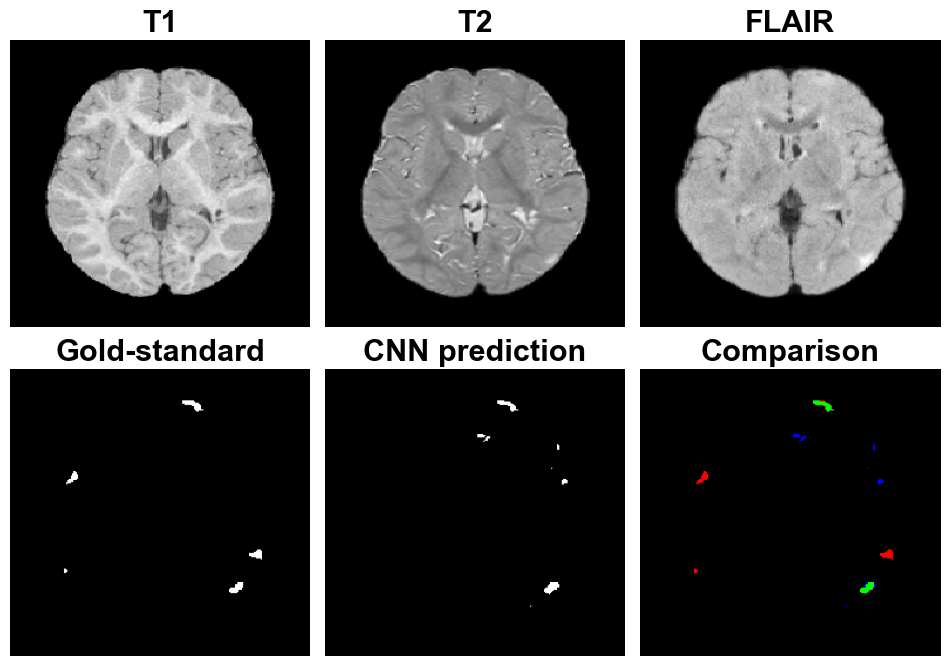

In [91]:
# 1.5T MRI (case 85, index 25)
test_T1_img = X_test_full_images_T1[25, :, :, 110]
test_T2_img = X_test_full_images_T2[25, :, :, 110]
test_FLAIR_img = X_test_full_images_FLAIR[25, :, :, 110]
true_mask = Y_test_full_images[25, :, :, 110]
predicted_mask = Y_predictions_full_images[25, :, :, 110]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

In [92]:
# 1.5T MRI (case 85, index 25)
Y_predictions_15T = trained_u_cnn.predict(X_test[25*64:25*64+64, :, :, :, :], batch_size=16)

# Define the threshold probability to call a tuber
Y_predictions_15T[Y_predictions_15T < 0.5] = 0.0
Y_predictions_15T[Y_predictions_15T >= 0.5] = 1.0

# Test Dice Coefficient
dice_coef(Y_test[25*64:25*64+64, :, :, :, :], Y_predictions_15T)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.5132008>

## Evaluate goodness of segmentations in MRI patches

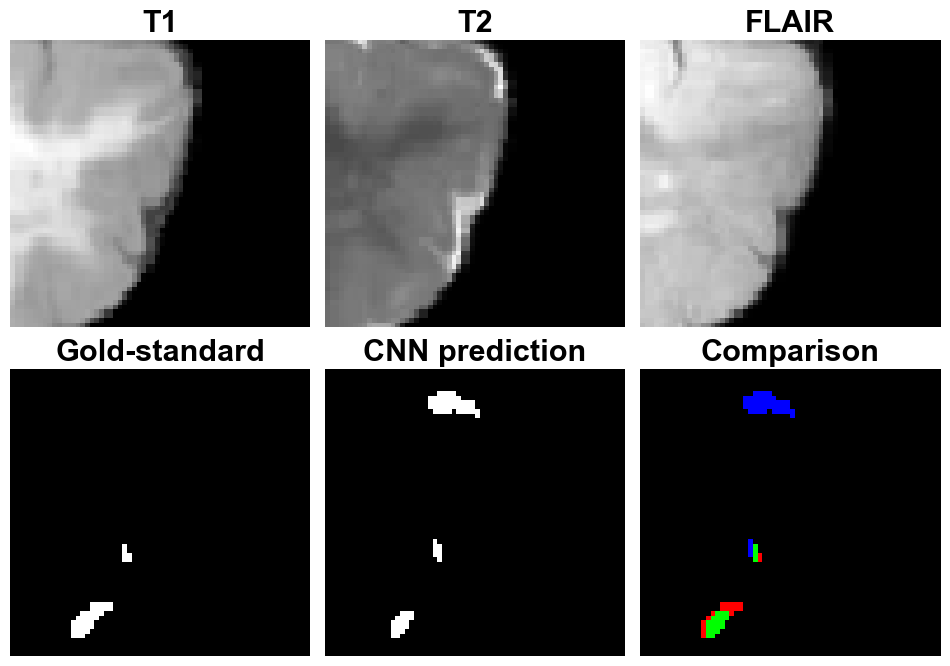

In [93]:
# Test image 1
test_T1_img = X_test[45, :, :, 41, 0]
test_T2_img = X_test[45, :, :, 41, 1]
test_FLAIR_img = X_test[45, :, :, 41, 2]
true_mask = Y_test[45, :, :, 41, 0]
predicted_mask = Y_predictions[45, :, :, 41,  0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

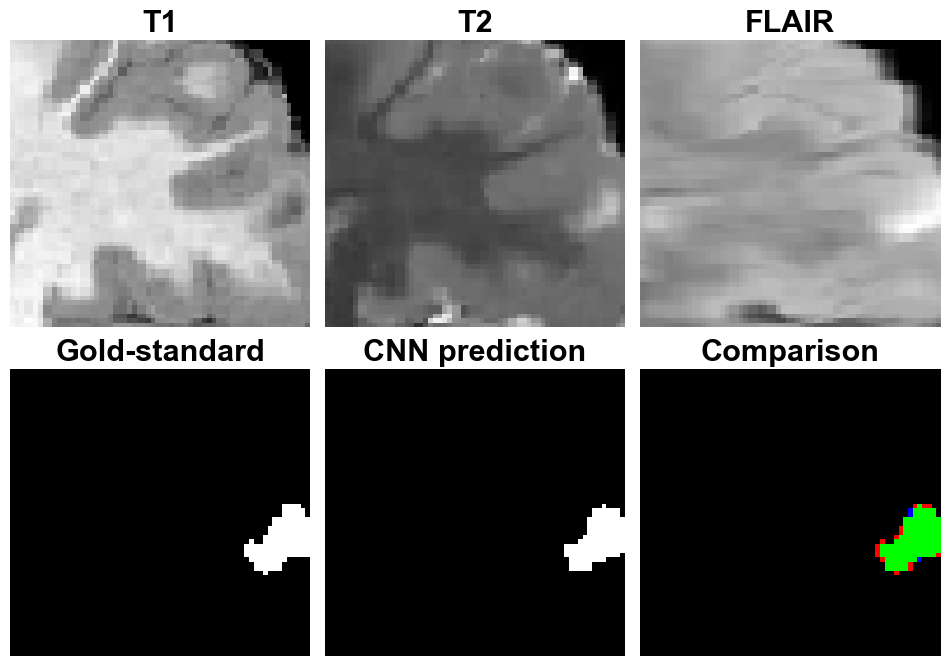

In [94]:
# Test image 2
test_T1_img = X_test[154, :, 35, :, 0]
test_T2_img = X_test[154, :, 35, :, 1]
test_FLAIR_img = X_test[154, :, 35, :, 2]
true_mask = Y_test[154, :, 35, :, 0]
predicted_mask = Y_predictions[154, :, 35, :,  0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

In [95]:
# Test image 3
test_T1_img = X_test[1245, :, :, 38, 0]
test_T2_img = X_test[1245, :, :, 38, 1]
test_FLAIR_img = X_test[1245, :, :, 38, 2]
true_mask = Y_test[1245, :, :, 38, 0]
predicted_mask = Y_predictions[1245, :, :, 38, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

In [96]:
# Test image 4
test_T1_img = X_test[2477, :, :, 40, 0]
test_T2_img = X_test[2477, :, :, 40, 1]
test_FLAIR_img = X_test[2477, :, :, 40, 2]
true_mask = Y_test[2477, :, :, 40, 0]
predicted_mask = Y_predictions[2477, :, :, 40, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

In [97]:
# Test image 5
test_T1_img = X_test[1050, 55, :, :, 0]
test_T2_img = X_test[1050, 55, :, :, 1]
test_FLAIR_img = X_test[1050, 55, :, :, 2]
true_mask = Y_test[1050, 55, :, :, 0]
predicted_mask = Y_predictions[1050, 55, :, :, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

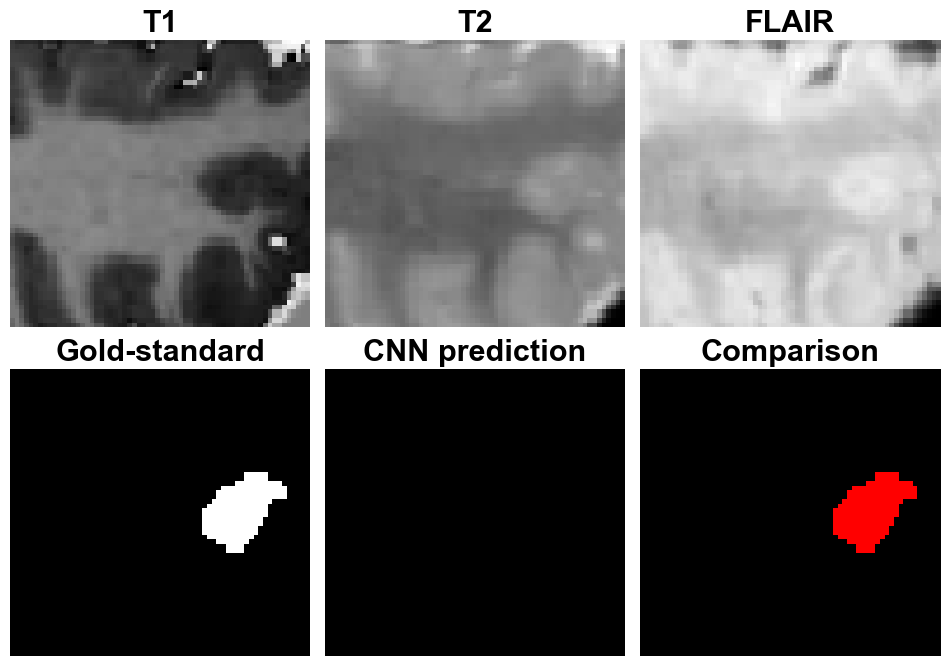

In [98]:
# Test image 6
test_T1_img = X_test[1706, :, :, 29, 0]
test_T2_img = X_test[1706, :, :, 29, 1]
test_FLAIR_img = X_test[1706, :, :, 29, 2]
true_mask = Y_test[1706, :, :, 29, 0]
predicted_mask = Y_predictions[1706, :, :, 29, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

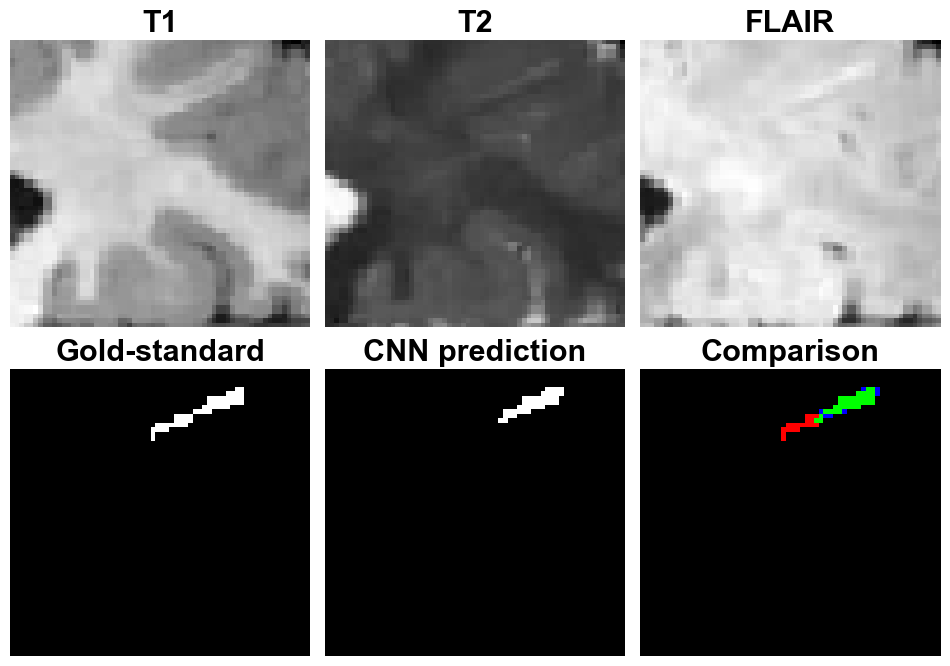

In [99]:
# Test image 7
test_T1_img = X_test[2070, :, 41, :, 0]
test_T2_img = X_test[2070, :, 41, :, 1]
test_FLAIR_img = X_test[2070, :, 41, :, 2]
true_mask = Y_test[2070, :, 41, :, 0]
predicted_mask = Y_predictions[2070, :, 41, :, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

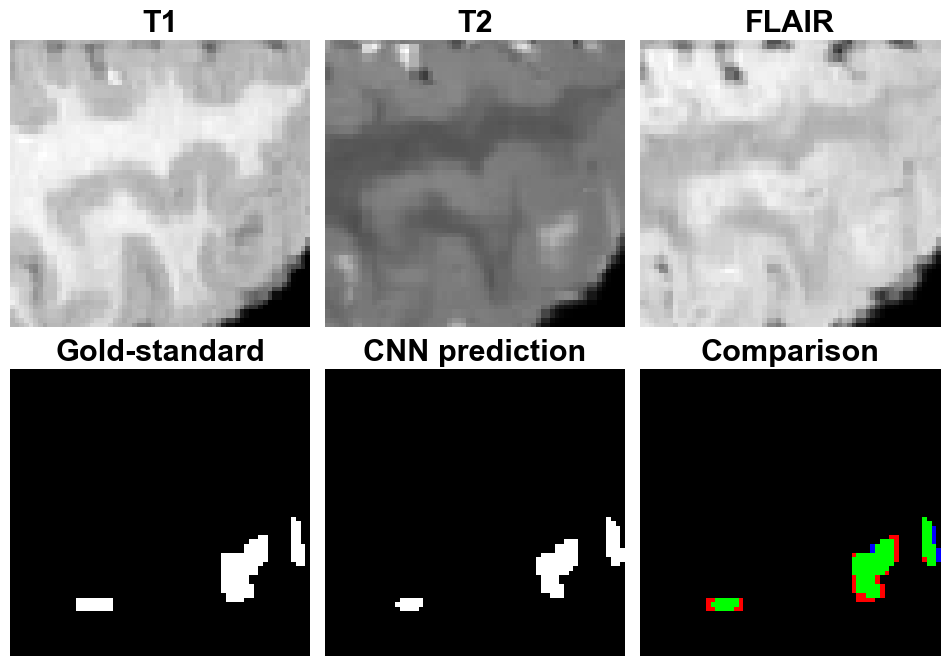

In [100]:
# Test image 8
test_T1_img = X_test[362, :, :, 38, 0]
test_T2_img = X_test[362, :, :, 38, 1]
test_FLAIR_img = X_test[362, :, :, 38, 2]
true_mask = Y_test[362, :, :, 38, 0]
predicted_mask = Y_predictions[362, :, :, 38,  0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

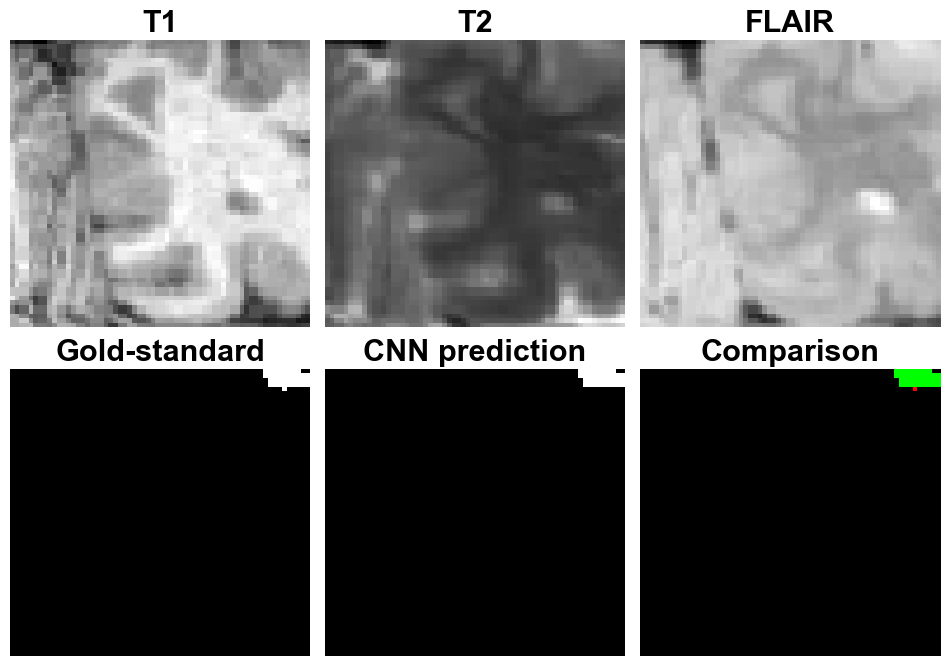

In [101]:
# Test image 9
test_T1_img = X_test[3025, :, 59, :, 0]
test_T2_img = X_test[3025, :, 59, :, 1]
test_FLAIR_img = X_test[3025, :, 59, :, 2]
true_mask = Y_test[3025, :, 59, :, 0]
predicted_mask = Y_predictions[3025, :, 59, :, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

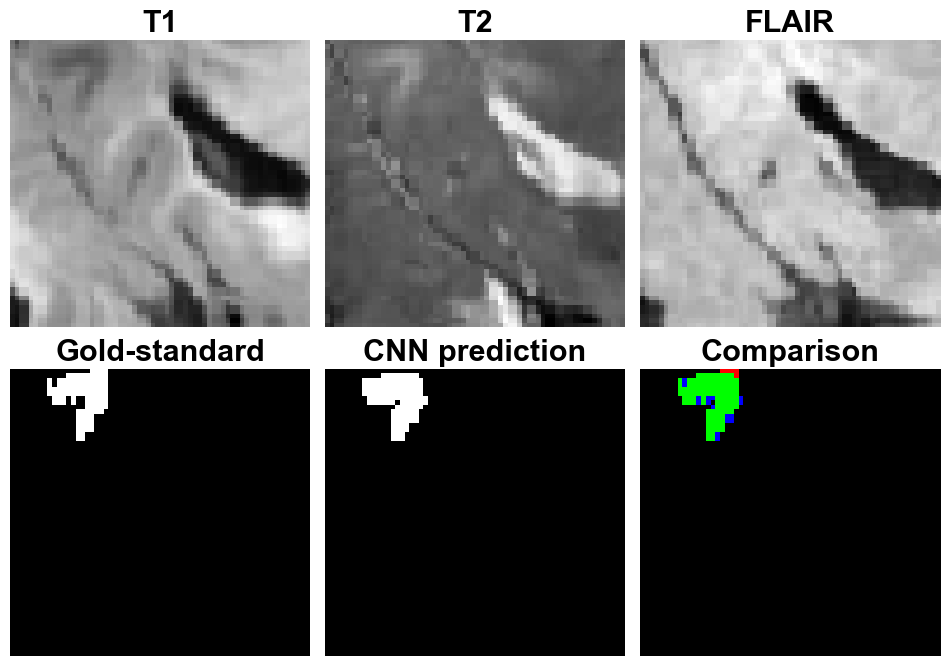

In [102]:
# Test image 10
test_T1_img = X_test[2005, :, 31, :, 0]
test_T2_img = X_test[2005, :, 31, :, 1]
test_FLAIR_img = X_test[2005, :, 33, :, 2]
true_mask = Y_test[2005, :, 31, :, 0]
predicted_mask = Y_predictions[2005, :, 31, :, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

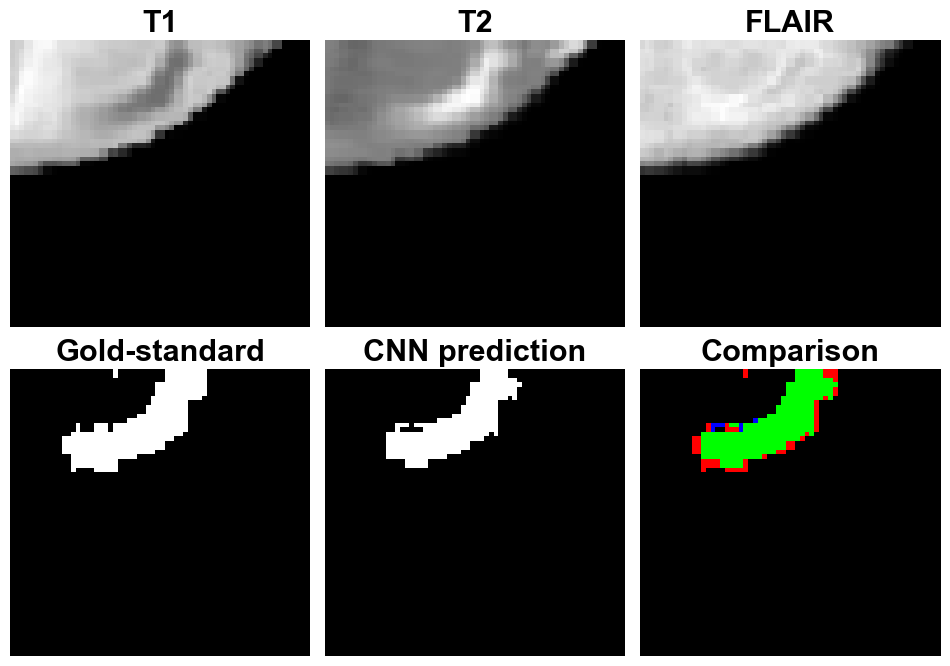

In [103]:
# Test image 11
test_T1_img = X_test[2298, :, 10, :, 0]
test_T2_img = X_test[2298, :, 10, :, 1]
test_FLAIR_img = X_test[2298, :, 10, :, 2]
true_mask = Y_test[2298, :, 10, :, 0]
predicted_mask = Y_predictions[2298, :, 10, :, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

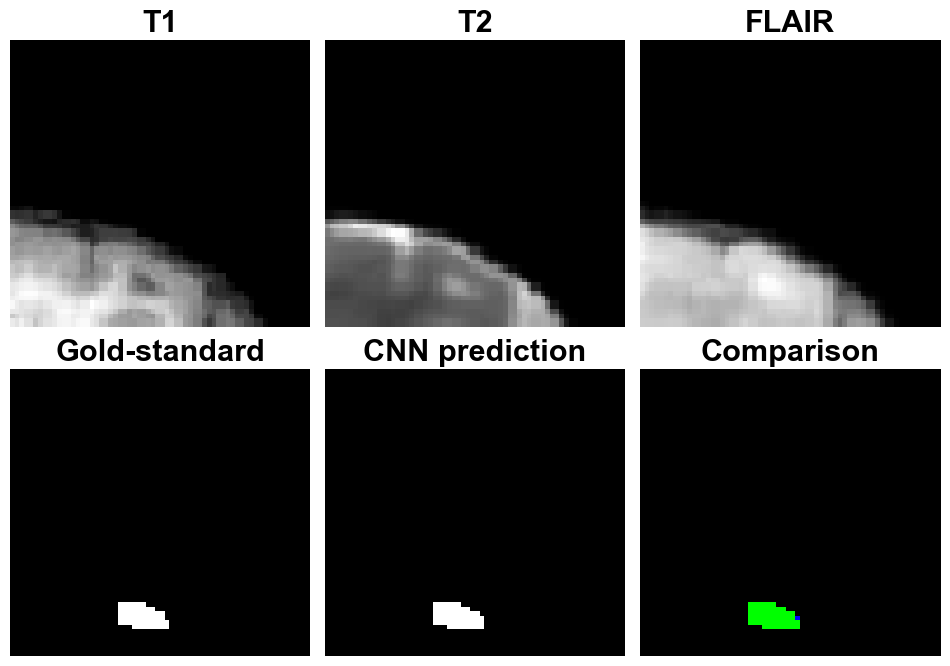

In [104]:
# Test image 12
test_T1_img = X_test[3018, :, 20, :, 0]
test_T2_img = X_test[3018, :, 20, :, 1]
test_FLAIR_img = X_test[3018, :, 20, :, 2]
true_mask = Y_test[3018, :, 20, :, 0]
predicted_mask = Y_predictions[3018, :, 20, :, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

In [105]:
# Test image 13
test_T1_img = X_test[1181, :, 24, :, 0]
test_T2_img = X_test[1181, :, 24, :, 1]
test_FLAIR_img = X_test[1181, :, 24, :, 2]
true_mask = Y_test[1181, :, 24, :, 0]
predicted_mask = Y_predictions[1181, :, 24, :, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

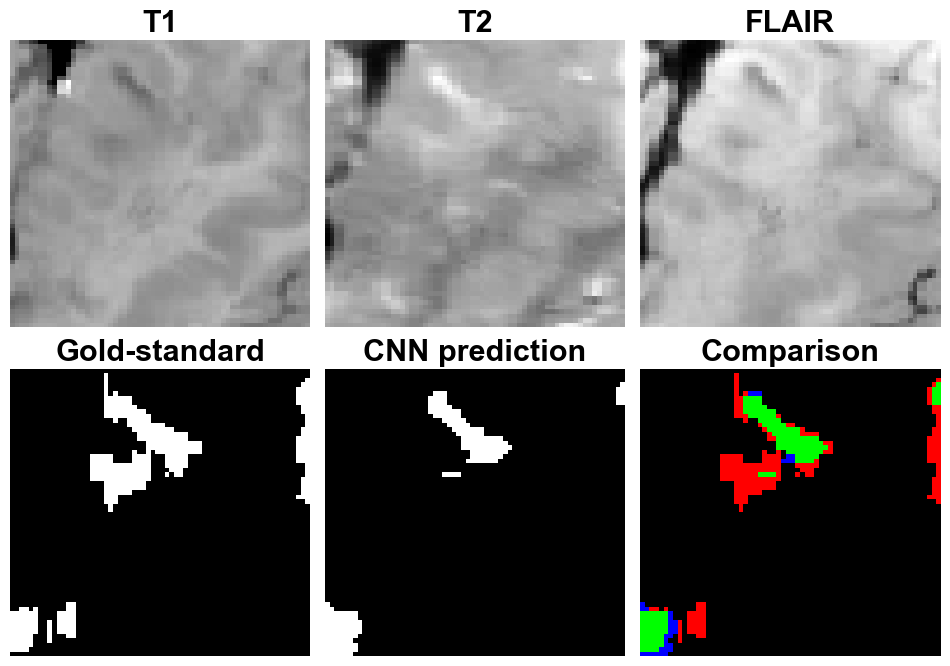

In [106]:
# Test image 14
test_T1_img = X_test[1381, 63, :, :, 0]
test_T2_img = X_test[1381, 63, :, :, 1]
test_FLAIR_img = X_test[1381, 63, :, :, 2]
true_mask = Y_test[1381, 63, :, :, 0]
predicted_mask = Y_predictions[1381, 63, :, :, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

In [107]:
# Test image 15
test_T1_img = X_test[2385, :, :, 32, 0]
test_T2_img = X_test[2385, :, :, 32, 1]
test_FLAIR_img = X_test[2385, :, :, 32, 2]
true_mask = Y_test[2385, :, :, 32, 0]
predicted_mask = Y_predictions[2385, :, :, 32, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

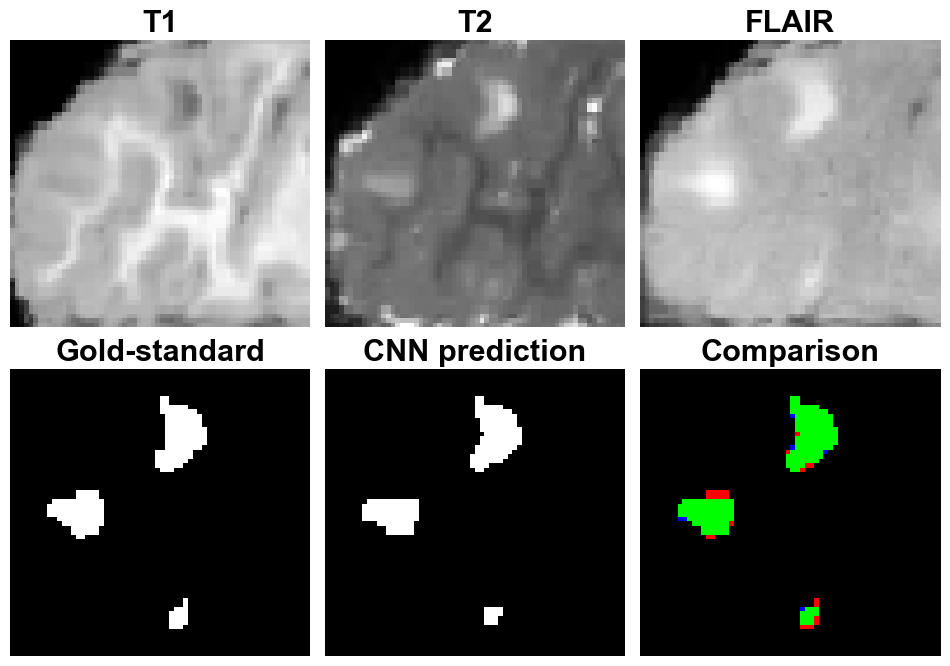

In [108]:
# Test image 16
test_T1_img = X_test[2134, :, :, 56, 0]
test_T2_img = X_test[2134, :, :, 56, 1]
test_FLAIR_img = X_test[2134, :, :, 56, 2]
true_mask = Y_test[2134, :, :, 56, 0]
predicted_mask = Y_predictions[2134, :, :, 56, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

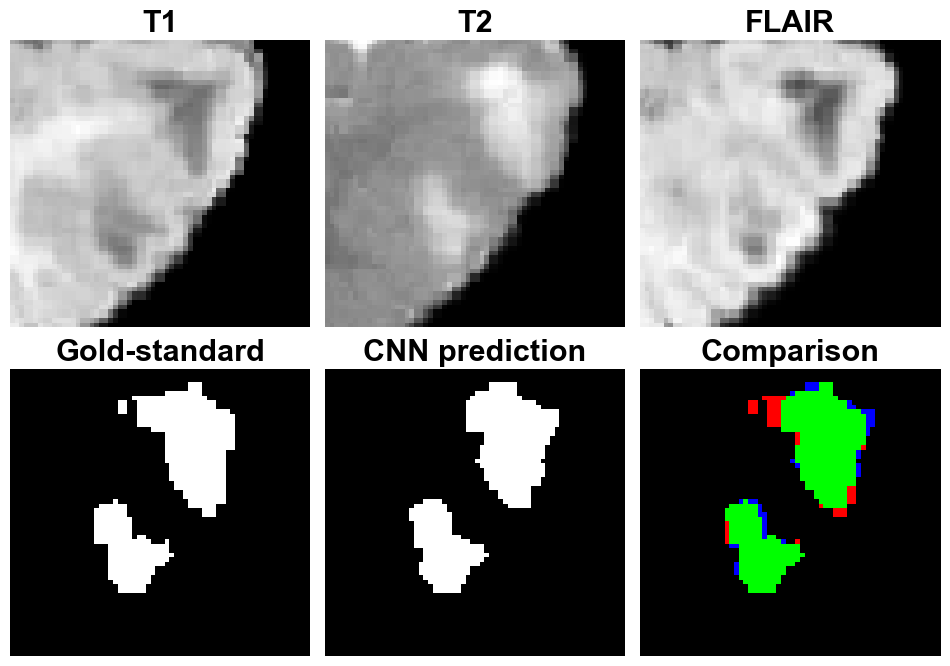

In [109]:
# Test image 17
test_T1_img = X_test[1134, :, 0, :, 0]
test_T2_img = X_test[1134, :, 0, :, 1]
test_FLAIR_img = X_test[1134, :, 0, :, 2]
true_mask = Y_test[1134, :, 0, :, 0]
predicted_mask = Y_predictions[1134, :, 0, :, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

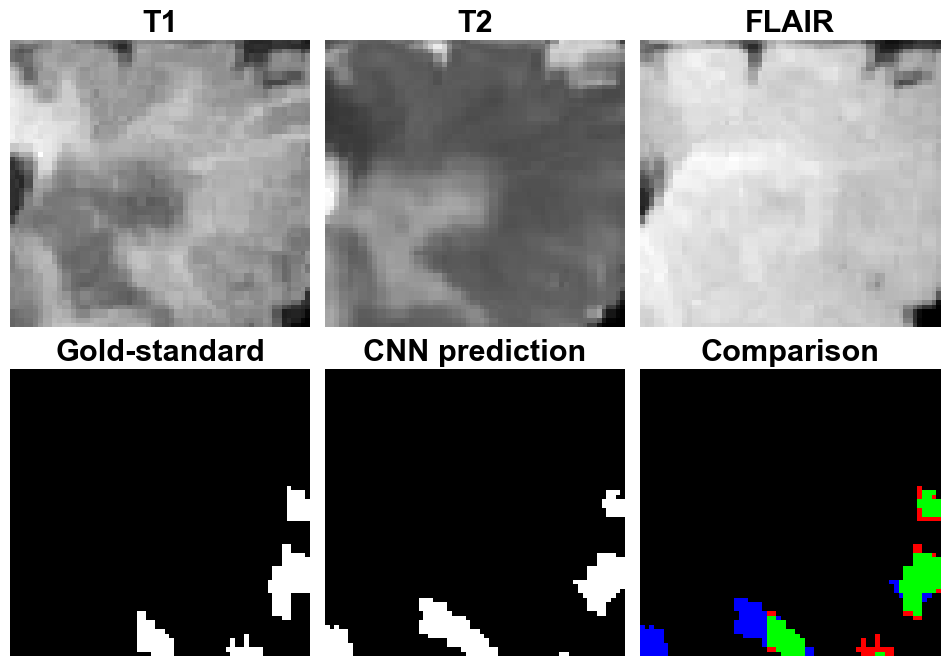

In [110]:
# Test image 18
test_T1_img = X_test[934, :, 37, :, 0]
test_T2_img = X_test[934, :, 37, :, 1]
test_FLAIR_img = X_test[934, :, 37, :, 2]
true_mask = Y_test[934, :, 37, :, 0]
predicted_mask = Y_predictions[934, :, 37, :, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

In [111]:
# Test image 19
test_T1_img = X_test[1861, :, 31, :, 0]
test_T2_img = X_test[1861, :, 31, :, 1]
test_FLAIR_img = X_test[1861, :, 31, :, 2]
true_mask = Y_test[1861, :, 31, :, 0]
predicted_mask = Y_predictions[1861, :, 31, :, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

In [112]:
# Test image 20
test_T1_img = X_test[2861, :, :, 22, 0]
test_T2_img = X_test[2861, :, :, 22, 1]
test_FLAIR_img = X_test[2861, :, :, 22, 2]
true_mask = Y_test[2861, :, :, 22, 0]
predicted_mask = Y_predictions[2861, :, :, 22, 0]

# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T1_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_T2_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(test_FLAIR_img, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(true_mask, cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(predicted_mask, cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(comparison_image, cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

<a id='images'></a>

## TO SEE EXAMPLES OF SEGMENTATIONS IN SMALL MRI PATCHES --> ↑↑ SCROLL UP ↑↑
## TO SEE EXAMPLES OF SEGMENTATIONS IN THE FULL MRI --> ↓↓ SCROLL DOWN ↓↓ 

## Evaluate goodness of segmentations in full MRIs

In [113]:
# Extract the different sequences
X_test_reshaped_T1 = X_test[:, :, :, :, 0]
X_test_reshaped_T2 = X_test[:, :, :, :, 1]
X_test_reshaped_FLAIR = X_test[:, :, :, :, 2]
Y_test_reshaped = Y_test[:, :, :, :, 0]
Y_predictions_reshaped = Y_predictions[:, :, :, :, 0]

In [114]:
# Modify shape of patches
i = 0 
X_test_full_images_T1 = np.zeros( (int(X_test_reshaped_T1.shape[0]/SX), SX_img, SY_img, SZ_img), np.float32)
X_test_full_images_T2 = np.zeros( (int(X_test_reshaped_T2.shape[0]/SX), SX_img, SY_img, SZ_img), np.float32)
X_test_full_images_FLAIR = np.zeros( (int(X_test_reshaped_FLAIR.shape[0]/SX), SX_img, SY_img, SZ_img), np.float32)
Y_test_full_images = np.zeros( (int(Y_test_reshaped.shape[0]/SX), SX_img, SY_img, SZ_img), np.uint8)
Y_predictions_full_images = np.zeros( (int(Y_predictions_reshaped.shape[0]/SX), SX_img, SY_img, SZ_img), np.uint8)

# Reconstruct the full images from their patches
while i < X_test.shape[0]:
    
    X_reshaped_patches_T1 = np.reshape(X_test_reshaped_T1[i:i+SX, :, :, :], (4, 4, 4, SX, SY, SZ))
    X_reconstructed_image_T1 = unpatchify(X_reshaped_patches_T1, (SX_img, SY_img, SZ_img))
    X_reconstructed_image_T1 = np.transpose(X_reconstructed_image_T1, [0, 1, 2])
    X_reconstructed_image_T1 = np.flip(X_reconstructed_image_T1, axis=(0,1))
    X_test_full_images_T1[int(i/64), :, :, :] =  X_reconstructed_image_T1

    X_reshaped_patches_T2 = np.reshape(X_test_reshaped_T2[i:i+SX, :, :, :], (4, 4, 4, SX, SY, SZ))
    X_reconstructed_image_T2 = unpatchify(X_reshaped_patches_T2, (SX_img, SY_img, SZ_img))
    X_reconstructed_image_T2 = np.transpose(X_reconstructed_image_T2, [0, 1, 2])
    X_reconstructed_image_T2 = np.flip(X_reconstructed_image_T2, axis=(0,1))
    X_test_full_images_T2[int(i/64), :, :, :] =  X_reconstructed_image_T2

    X_reshaped_patches_FLAIR = np.reshape(X_test_reshaped_FLAIR[i:i+SX, :, :, :], (4, 4, 4, SX, SY, SZ))
    X_reconstructed_image_FLAIR = unpatchify(X_reshaped_patches_FLAIR, (SX_img, SY_img, SZ_img))
    X_reconstructed_image_FLAIR = np.transpose(X_reconstructed_image_FLAIR, [0, 1, 2])
    X_reconstructed_image_FLAIR = np.flip(X_reconstructed_image_FLAIR, axis=(0,1))
    X_test_full_images_FLAIR[int(i/64), :, :, :] =  X_reconstructed_image_FLAIR
    
    Y_test_reshaped_patches = np.reshape(Y_test_reshaped[i:i+SX, :, :, :], (4, 4, 4, SX, SY, SZ))
    Y_test_reconstructed_image = unpatchify(Y_test_reshaped_patches, (SX_img, SY_img, SZ_img))
    Y_test_reconstructed_image = np.transpose(Y_test_reconstructed_image, [0, 1, 2])
    Y_test_reconstructed_image = np.flip(Y_test_reconstructed_image, axis=(0,1))
    Y_test_full_images[int(i/64), :, :, :] =  Y_test_reconstructed_image 
 
    Y_predictions_reshaped_patches = np.reshape(Y_predictions_reshaped[i:i+SX, :, :, :], (4, 4, 4, SX, SY, SZ))
    Y_predictions_reconstructed_image = unpatchify(Y_predictions_reshaped_patches, (SX_img, SY_img, SZ_img))
    Y_predictions_reconstructed_image = np.transpose(Y_predictions_reconstructed_image, [0, 1, 2])
    Y_predictions_reconstructed_image = np.flip(Y_predictions_reconstructed_image, axis=(0,1))
    Y_predictions_full_images[int(i/64), :, :, :] =  Y_predictions_reconstructed_image 
    
    i += SX

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


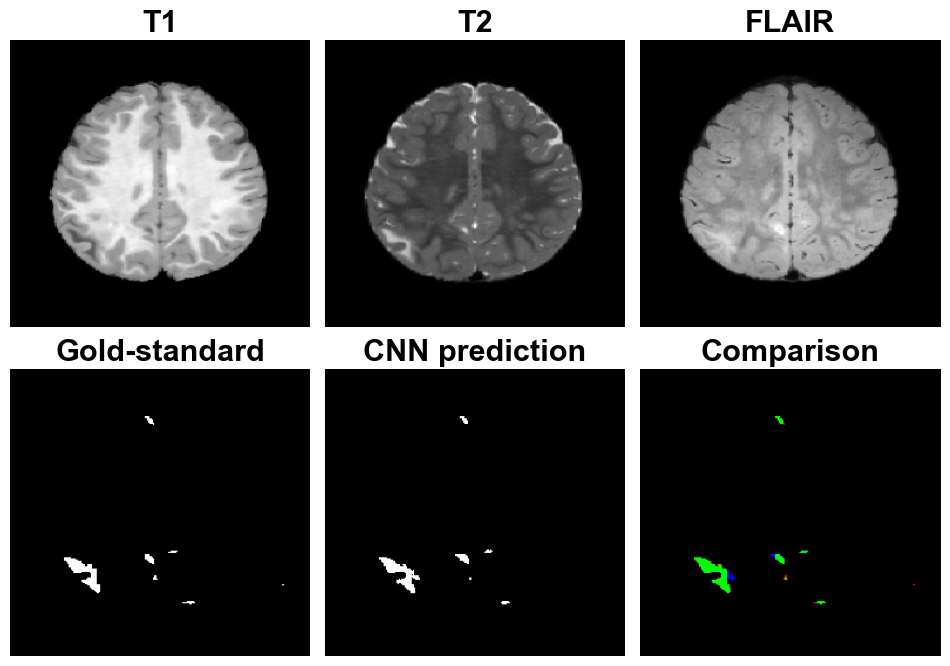

In [115]:
# Test 1 figure of 2D slice
test_T1_img = X_test_full_images_T1[1, :, :, 150]
test_T2_img = X_test_full_images_T2[1, :, :, 150]
test_FLAIR_img = X_test_full_images_FLAIR[1, :, :, 150]
true_mask = Y_test_full_images[1, :, :, 150]
predicted_mask = Y_predictions_full_images[1, :, :, 150]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


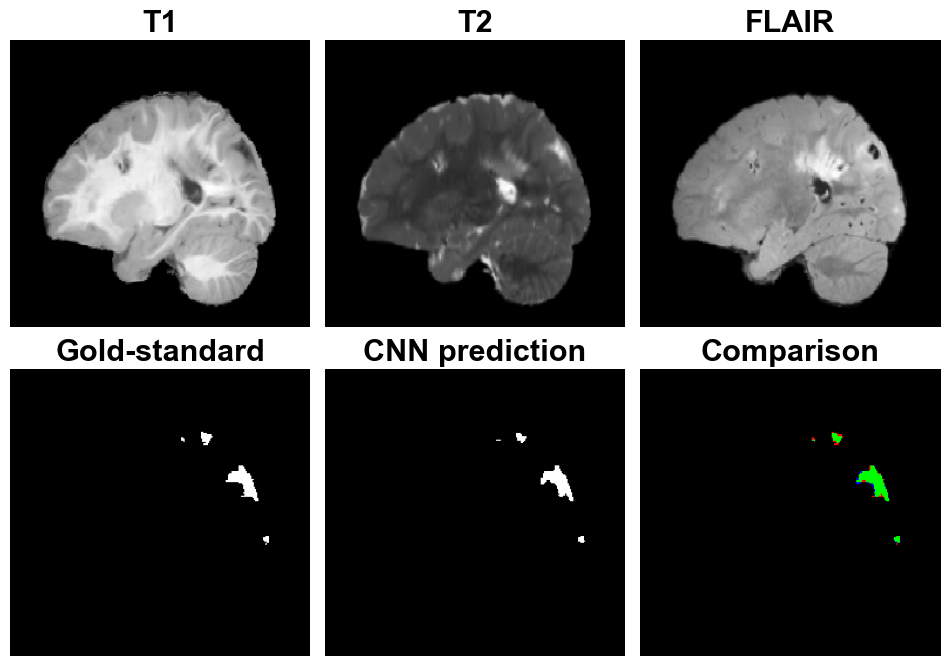

In [116]:
# Test 2 figure of 2D slice
test_T1_img = X_test_full_images_T1[0, 160, :, :]
test_T2_img = X_test_full_images_T2[0, 160, :, :]
test_FLAIR_img = X_test_full_images_FLAIR[0, 160, :, :]
true_mask = Y_test_full_images[0, 160, :, :]
predicted_mask = Y_predictions_full_images[0, 160, :, :]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


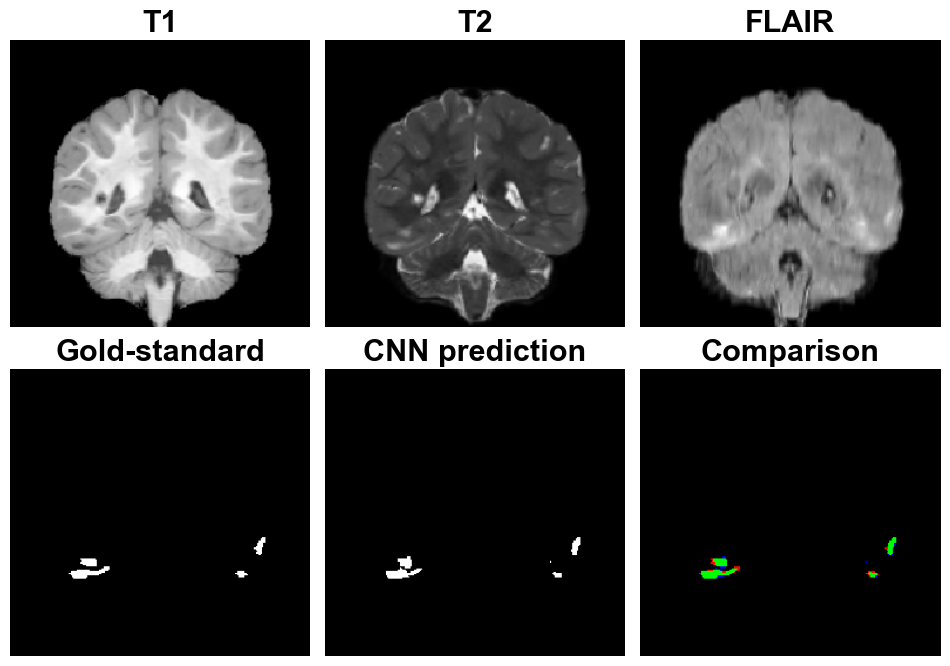

In [117]:
# Test 3 figure of 2D slice
test_T1_img = X_test_full_images_T1[9, :, 158, :]
test_T2_img = X_test_full_images_T2[9, :, 158, :]
test_FLAIR_img = X_test_full_images_FLAIR[9, :, 158, :]
true_mask = Y_test_full_images[9, :, 158, :]
predicted_mask = Y_predictions_full_images[9, :, 158, :]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

In [118]:
# Test 4 figure of 2D slice
test_T1_img = X_test_full_images_T1[10, :, :, 150]
test_T2_img = X_test_full_images_T2[10, :, :, 150]
test_FLAIR_img = X_test_full_images_FLAIR[10, :, :, 150]
true_mask = Y_test_full_images[10, :, :, 150]
predicted_mask = Y_predictions_full_images[10, :, :, 150]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [119]:
# Test 5 figure of 2D slice
test_T1_img = X_test_full_images_T1[13, :, 70, :]
test_T2_img = X_test_full_images_T2[13, :, 70, :]
test_FLAIR_img = X_test_full_images_FLAIR[13, :, 70, :]
true_mask = Y_test_full_images[13, :, 70, :]
predicted_mask = Y_predictions_full_images[13, :, 70, :]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [120]:
# Test 6 figure of 2D slice
test_T1_img = X_test_full_images_T1[15, :, :, 150]
test_T2_img = X_test_full_images_T2[15, :, :, 150]
test_FLAIR_img = X_test_full_images_FLAIR[15, :, :, 150]
true_mask = Y_test_full_images[15, :, :, 150]
predicted_mask = Y_predictions_full_images[15, :, :, 150]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


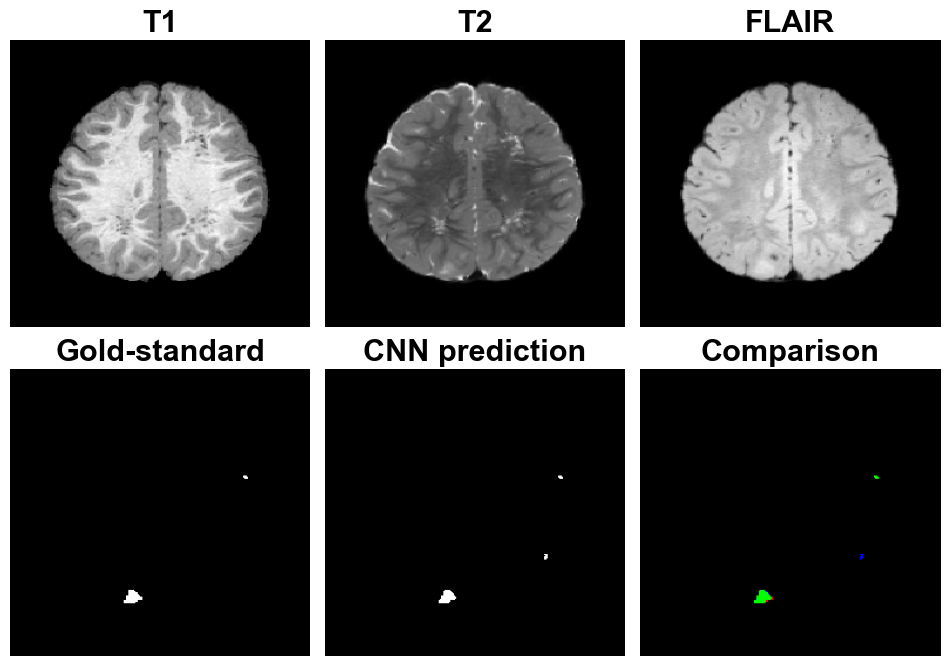

In [121]:
# Test 7 figure of 2D slice
test_T1_img = X_test_full_images_T1[18, :, :, 150]
test_T2_img = X_test_full_images_T2[18, :, :, 150]
test_FLAIR_img = X_test_full_images_FLAIR[18, :, :, 150]
true_mask = Y_test_full_images[18, :, :, 150]
predicted_mask = Y_predictions_full_images[18, :, :, 150]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

In [122]:
# Test 8 figure of 2D slice
test_T1_img = X_test_full_images_T1[20, :, :, 150]
test_T2_img = X_test_full_images_T2[20, :, :, 150]
test_FLAIR_img = X_test_full_images_FLAIR[20, :, :, 150]
true_mask = Y_test_full_images[20, :, :, 150]
predicted_mask = Y_predictions_full_images[20, :, :, 150]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


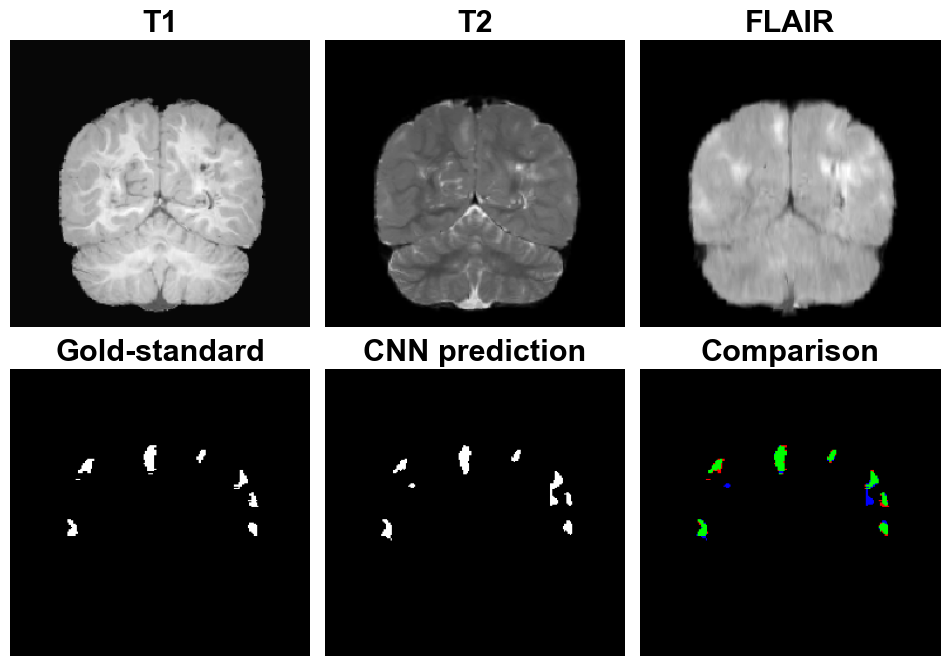

In [123]:
# Test 9 figure of 2D slice
test_T1_img = X_test_full_images_T1[28, :, 174, :]
test_T2_img = X_test_full_images_T2[28, :, 174, :]
test_FLAIR_img = X_test_full_images_FLAIR[28, :, 174, :]
true_mask = Y_test_full_images[28, :, 174, :]
predicted_mask = Y_predictions_full_images[28, :, 174, :]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

In [124]:
# Test 10 figure of 2D slice
test_T1_img = X_test_full_images_T1[25, :, :, 150]
test_T2_img = X_test_full_images_T2[25, :, :, 150]
test_FLAIR_img = X_test_full_images_FLAIR[25, :, :, 150]
true_mask = Y_test_full_images[25, :, :, 150]
predicted_mask = Y_predictions_full_images[25, :, :, 150]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


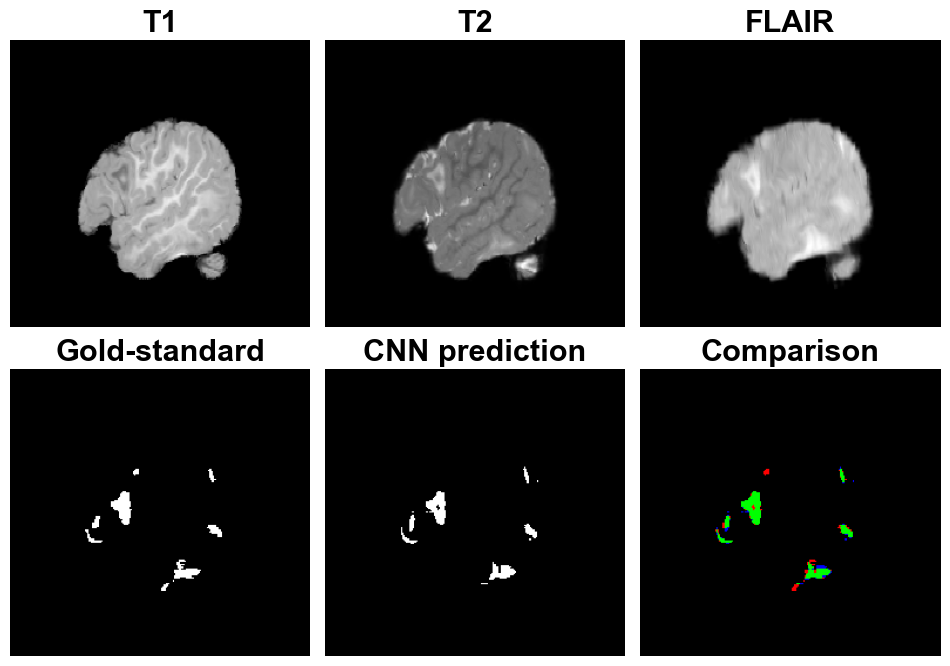

In [125]:
# Test 11 figure of 2D slice
test_T1_img = X_test_full_images_T1[28, 56, :, :]
test_T2_img = X_test_full_images_T2[28, 56, :, :]
test_FLAIR_img = X_test_full_images_FLAIR[28, 56, :, :]
true_mask = Y_test_full_images[28, 56, :, :]
predicted_mask = Y_predictions_full_images[28, 56, :, :]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

In [126]:
# Test 12 figure of 2D slice
test_T1_img = X_test_full_images_T1[29, :, 41, :]
test_T2_img = X_test_full_images_T2[29, :, 41, :]
test_FLAIR_img = X_test_full_images_FLAIR[29, :, 41, :]
true_mask = Y_test_full_images[29, :, 41, :]
predicted_mask = Y_predictions_full_images[29, :, 41, :]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


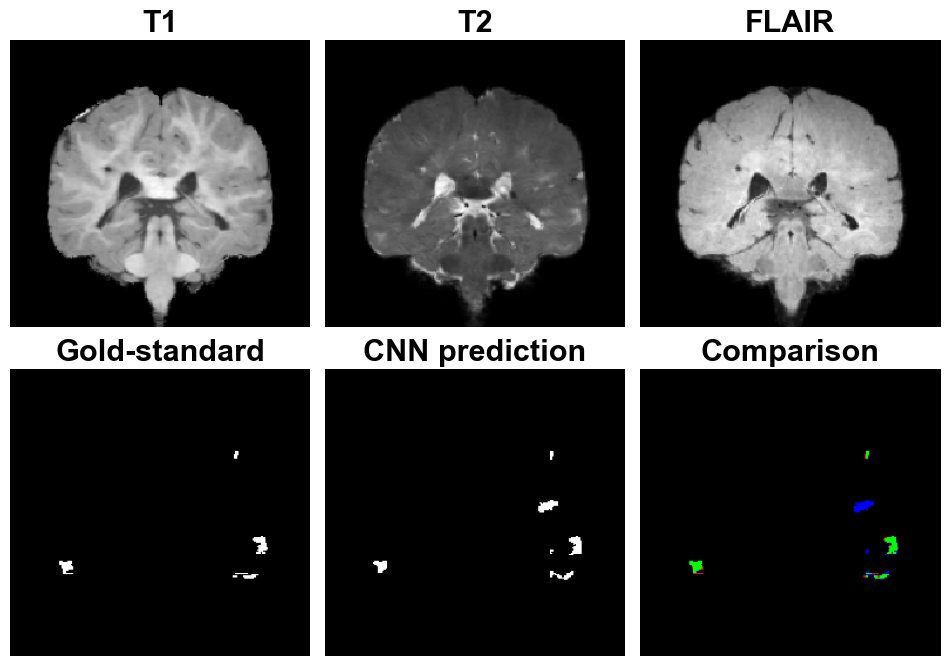

In [127]:
# Test 13 figure of 2D slice
test_T1_img = X_test_full_images_T1[31, :, 146, :]
test_T2_img = X_test_full_images_T2[31, :, 146, :]
test_FLAIR_img = X_test_full_images_FLAIR[31, :, 146, :]
true_mask = Y_test_full_images[31, :, 146, :]
predicted_mask = Y_predictions_full_images[31, :, 146, :]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


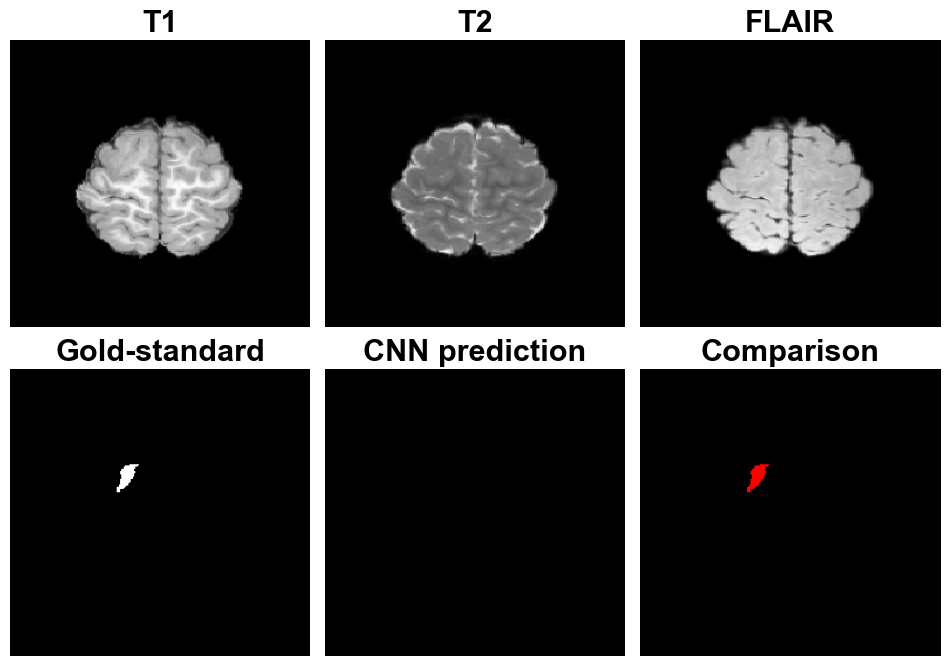

In [128]:
# Test 14 figure of 2D slice
test_T1_img = X_test_full_images_T1[32, :, :, 187]
test_T2_img = X_test_full_images_T2[32, :, :, 187]
test_FLAIR_img = X_test_full_images_FLAIR[32, :, :, 187]
true_mask = Y_test_full_images[32, :, :, 187]
predicted_mask = Y_predictions_full_images[32, :, :, 187]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

In [129]:
# Test 15 figure of 2D slice
test_T1_img = X_test_full_images_T1[33, :, :, 101]
test_T2_img = X_test_full_images_T2[33, :, :, 101]
test_FLAIR_img = X_test_full_images_FLAIR[33, :, :, 101]
true_mask = Y_test_full_images[33, :, :, 101]
predicted_mask = Y_predictions_full_images[33, :, :, 101]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


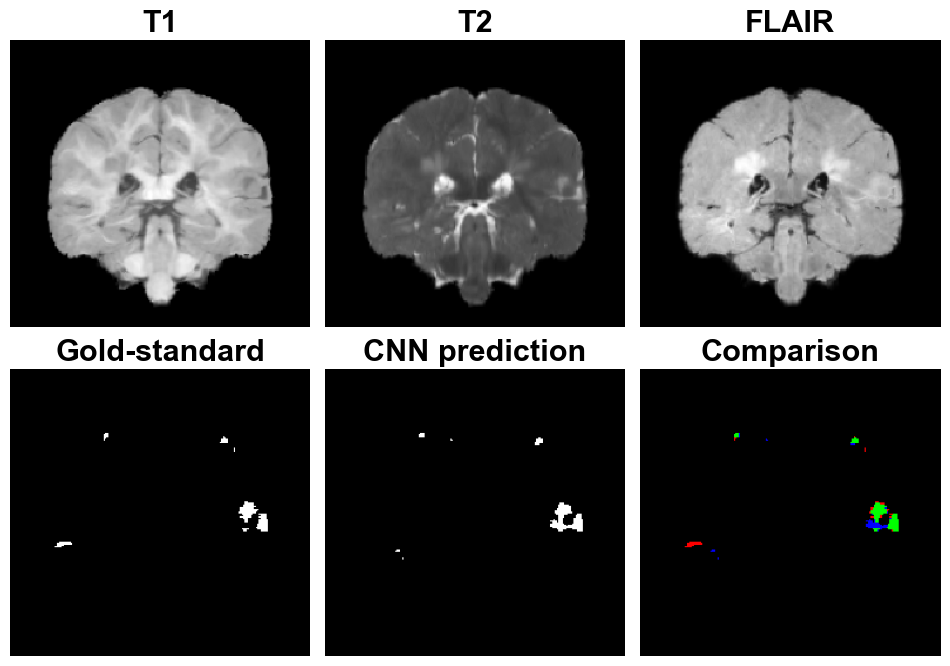

In [130]:
# Test 16 figure of 2D slice
test_T1_img = X_test_full_images_T1[35, :, 146, :]
test_T2_img = X_test_full_images_T2[35, :, 146, :]
test_FLAIR_img = X_test_full_images_FLAIR[35, :, 146, :]
true_mask = Y_test_full_images[35, :, 146, :]
predicted_mask = Y_predictions_full_images[35, :, 146, :]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


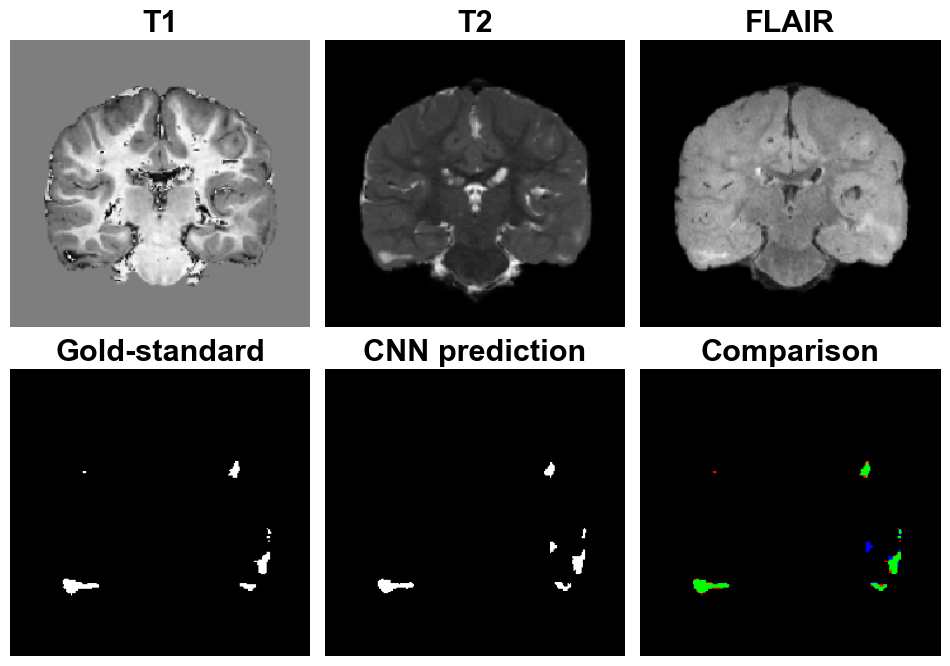

In [131]:
# Test 17 figure of 2D slice
test_T1_img = X_test_full_images_T1[36, :, 136, :]
test_T2_img = X_test_full_images_T2[36, :, 136, :]
test_FLAIR_img = X_test_full_images_FLAIR[36, :, 136, :]
true_mask = Y_test_full_images[36, :, 136, :]
predicted_mask = Y_predictions_full_images[36, :, 136, :]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


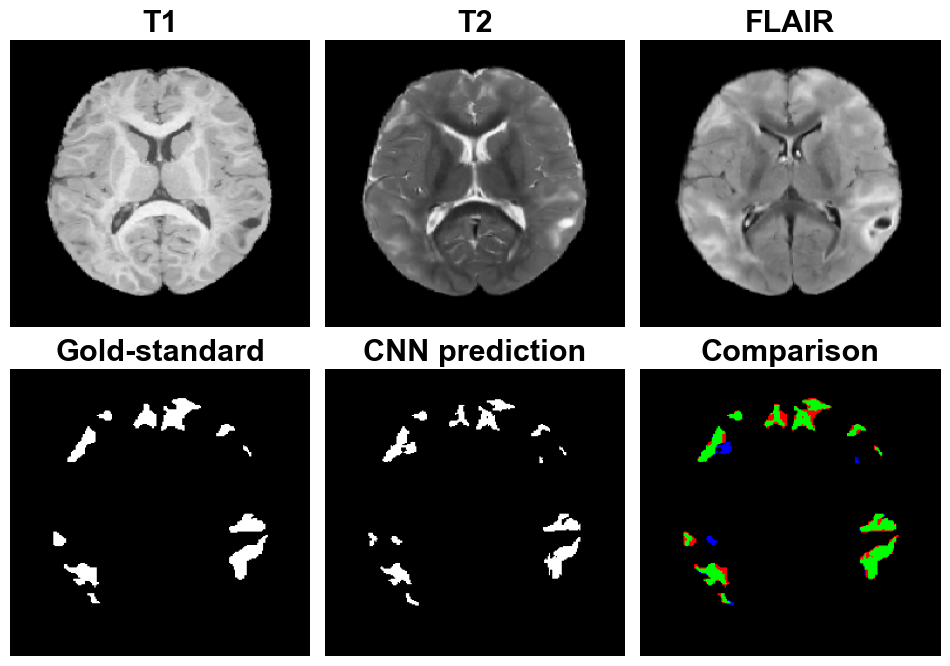

In [132]:
# Test 18 figure of 2D slice
test_T1_img = X_test_full_images_T1[37, :, :, 118]
test_T2_img = X_test_full_images_T2[37, :, :, 118]
test_FLAIR_img = X_test_full_images_FLAIR[37, :, :, 118]
true_mask = Y_test_full_images[37, :, :, 118]
predicted_mask = Y_predictions_full_images[37, :, :, 118]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


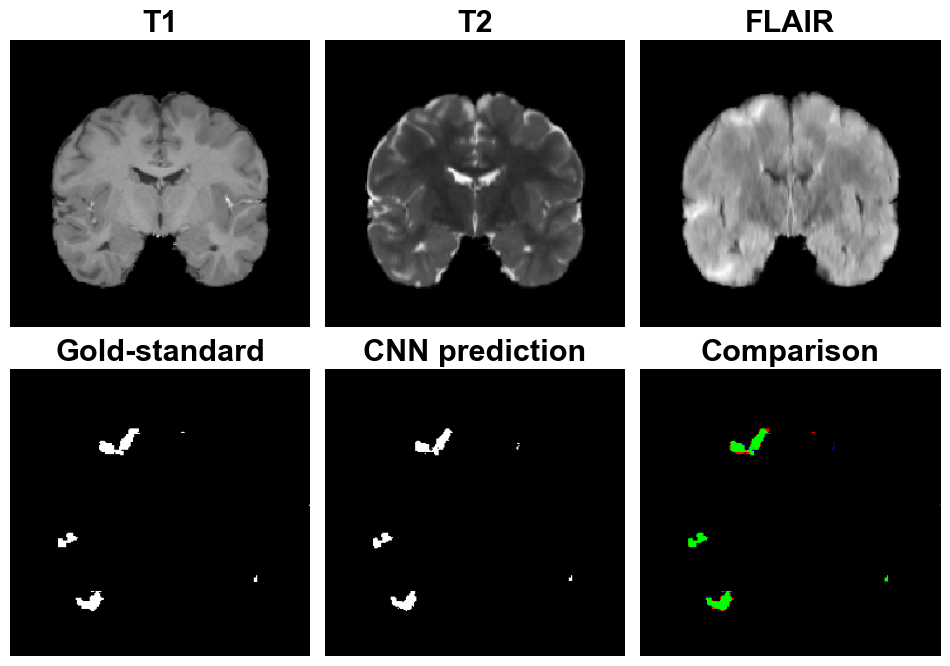

In [133]:
# Test 19 figure of 2D slice
test_T1_img = X_test_full_images_T1[40, :, 116, :]
test_T2_img = X_test_full_images_T2[40, :, 116, :]
test_FLAIR_img = X_test_full_images_FLAIR[40, :, 116, :]
true_mask = Y_test_full_images[40, :, 116, :]
predicted_mask = Y_predictions_full_images[40, :, 116, :]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 90), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 90), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


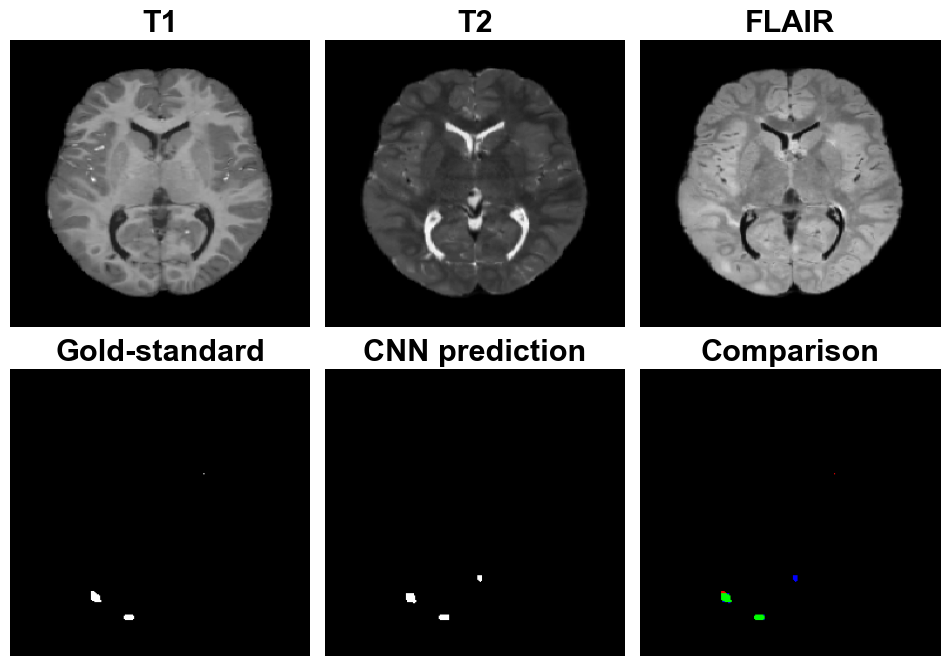

In [134]:
# Test 20 figure of 2D slice
test_T1_img = X_test_full_images_T1[45, :, :, 112]
test_T2_img = X_test_full_images_T2[45, :, :, 112]
test_FLAIR_img = X_test_full_images_FLAIR[45, :, :, 112]
true_mask = Y_test_full_images[45, :, :, 112]
predicted_mask = Y_predictions_full_images[45, :, :, 112]


# Figure of a 2-D slice
plt.figure(figsize=(12, 8))
gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.05, hspace=0.15)
plt.subplot(gs1[0])
plt.title('T1', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T1_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[1])
plt.title('T2', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_T2_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[2])
plt.title('FLAIR', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(test_FLAIR_img, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[3])
plt.title('Gold-standard', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(true_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.subplot(gs1[4])
plt.title('CNN prediction', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(predicted_mask, 270), cmap='gray', aspect="auto")
plt.axis('off')
comparison_image = np.zeros((true_mask.shape[0], true_mask.shape[1], 3))
comparison_image[true_mask == 1] = [1, 0, 0]
comparison_image[predicted_mask == 1] = [0, 0, 1]
comparison_image[(true_mask == 1) & (predicted_mask == 1)] = [0, 1, 0]
plt.subplot(gs1[5])
plt.title('Comparison', fontsize=22, weight='bold', fontname='Arial')
plt.imshow(ndimage.rotate(comparison_image, 270), cmap='gray', aspect="auto")
plt.axis('off')
plt.show()

## Extract parcellation masks and calculate tuber volume (total and per region)

In [135]:
####################################GRAY MATTER MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
gray_matter_mask = sitk.ReadImage('/home/ch134560/data/masks/gray_matter_total_lobes_binarized.nii')
gray_matter_mask = sitk.GetArrayFromImage(gray_matter_mask)

# Resize for consistency
gray_matter_mask = np.float32(np.flip(np.transpose(gray_matter_mask, [2, 1, 0]), axis=1))
gray_matter_mask = scipy.ndimage.zoom(gray_matter_mask, zoom=(SX_img/gray_matter_mask.shape[0], SY_img/gray_matter_mask.shape[1], SZ_img/gray_matter_mask.shape[2]), order=0)




####################################RIGHT OCCIPITAL MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
R_occipital_mask = sitk.ReadImage('/home/ch134560/data/masks/mni_right_Occipital_Lobe_mask.nii.gz')
R_occipital_mask = sitk.GetArrayFromImage(R_occipital_mask)

# Resize for consistency
R_occipital_mask = np.float32(np.flip(np.transpose(R_occipital_mask, [2, 1, 0]), axis=1))
R_occipital_mask = scipy.ndimage.zoom(R_occipital_mask, zoom=(SX_img/R_occipital_mask.shape[0], SY_img/R_occipital_mask.shape[1], SZ_img/R_occipital_mask.shape[2]), order=0)




####################################LEFT OCCIPITAL MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
L_occipital_mask = sitk.ReadImage('/home/ch134560/data/masks/mni_left_Occipital_Lobe_mask.nii.gz')
L_occipital_mask = sitk.GetArrayFromImage(L_occipital_mask)

# Resize for consistency
L_occipital_mask = np.float32(np.flip(np.transpose(L_occipital_mask, [2, 1, 0]), axis=1))
L_occipital_mask = scipy.ndimage.zoom(L_occipital_mask, zoom=(SX_img/L_occipital_mask.shape[0], SY_img/L_occipital_mask.shape[1], SZ_img/L_occipital_mask.shape[2]), order=0)




####################################RIGHT PARIETAL MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
R_parietal_mask = sitk.ReadImage('/home/ch134560/data/masks/mni_right_Parietal_Lobe_mask.nii.gz')
R_parietal_mask = sitk.GetArrayFromImage(R_parietal_mask)

# Resize for consistency
R_parietal_mask = np.float32(np.flip(np.transpose(R_parietal_mask, [2, 1, 0]), axis=1))
R_parietal_mask = scipy.ndimage.zoom(R_parietal_mask, zoom=(SX_img/R_parietal_mask.shape[0], SY_img/R_parietal_mask.shape[1], SZ_img/R_parietal_mask.shape[2]), order=0)




####################################LEFT PARIETAL MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
L_parietal_mask = sitk.ReadImage('/home/ch134560/data/masks/mni_left_Parietal_Lobe_mask.nii.gz')
L_parietal_mask = sitk.GetArrayFromImage(L_parietal_mask)

# Resize for consistency
L_parietal_mask = np.float32(np.flip(np.transpose(L_parietal_mask, [2, 1, 0]), axis=1))
L_parietal_mask = scipy.ndimage.zoom(L_parietal_mask, zoom=(SX_img/L_parietal_mask.shape[0], SY_img/L_parietal_mask.shape[1], SZ_img/L_parietal_mask.shape[2]), order=0)




####################################RIGHT TEMPORAL MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
R_temporal_mask = sitk.ReadImage('/home/ch134560/data/masks/mni_right_Temporal_Lobe_mask.nii')
R_temporal_mask = sitk.GetArrayFromImage(R_temporal_mask)

# Resize for consistency
R_temporal_mask = np.float32(np.flip(np.transpose(R_temporal_mask, [2, 1, 0]), axis=1))
R_temporal_mask = scipy.ndimage.zoom(R_temporal_mask, zoom=(SX_img/R_temporal_mask.shape[0], SY_img/R_temporal_mask.shape[1], SZ_img/R_temporal_mask.shape[2]), order=0)




####################################LEFT TEMPORAL MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
L_temporal_mask = sitk.ReadImage('/home/ch134560/data/masks/mni_left_Temporal_Lobe_mask.nii')
L_temporal_mask = sitk.GetArrayFromImage(L_temporal_mask)

# Resize for consistency
L_temporal_mask = np.float32(np.flip(np.transpose(L_temporal_mask, [2, 1, 0]), axis=1))
L_temporal_mask = scipy.ndimage.zoom(L_temporal_mask, zoom=(SX_img/L_temporal_mask.shape[0], SY_img/L_temporal_mask.shape[1], SZ_img/L_temporal_mask.shape[2]), order=0)




####################################RIGHT FRONTAL MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
R_frontal_mask = sitk.ReadImage('/home/ch134560/data/masks/mni_right_Frontal_Lobe_mask.nii.gz')
R_frontal_mask = sitk.GetArrayFromImage(R_frontal_mask)

# Resize for consistency
R_frontal_mask = np.float32(np.flip(np.transpose(R_frontal_mask, [2, 1, 0]), axis=1))
R_frontal_mask = scipy.ndimage.zoom(R_frontal_mask, zoom=(SX_img/R_frontal_mask.shape[0], SY_img/R_frontal_mask.shape[1], SZ_img/R_frontal_mask.shape[2]), order=0)




####################################LEFT FRONTAL MASK####################################
# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
L_frontal_mask = sitk.ReadImage('/home/ch134560/data/masks/mni_left_Frontal_Lobe_mask.nii.gz')
L_frontal_mask = sitk.GetArrayFromImage(L_frontal_mask)

# Resize for consistency
L_frontal_mask = np.float32(np.flip(np.transpose(L_frontal_mask, [2, 1, 0]), axis=1))
L_frontal_mask = scipy.ndimage.zoom(L_frontal_mask, zoom=(SX_img/L_frontal_mask.shape[0], SY_img/L_frontal_mask.shape[1], SZ_img/L_frontal_mask.shape[2]), order=0)

#### Total tuber volume

In [136]:
# Calculate tuber volume
volume_test = [np.sum(Y_test_full_images[i, :, :, :]) for i in range(Y_test_full_images.shape[0])]
volume_prediction = [np.sum(Y_predictions_full_images[i, :, :, :]) for i in range(Y_predictions_full_images.shape[0])]

In [137]:
# Calculate Spearman correlation coefficient
p_value_Spearman = stats.spearmanr(volume_test, volume_prediction)[1]
stats.spearmanr(volume_test, volume_prediction)

SignificanceResult(statistic=0.9834997828918801, pvalue=8.28557986529946e-36)

In [138]:
# Calculate the Spearman correlation coefficient 95% confidence interval using the Fisher transformation
correlation = stats.spearmanr(volume_test, volume_prediction)[0]
count = len(volume_test)

stderr = 1.0 / math.sqrt(count - 3)
delta = 1.96 * stderr
lower = math.tanh(math.atanh(correlation) - delta)
upper = math.tanh(math.atanh(correlation) + delta)

lower, correlation, upper

(0.9705938241155342, 0.9834997828918801, 0.9907680333259808)

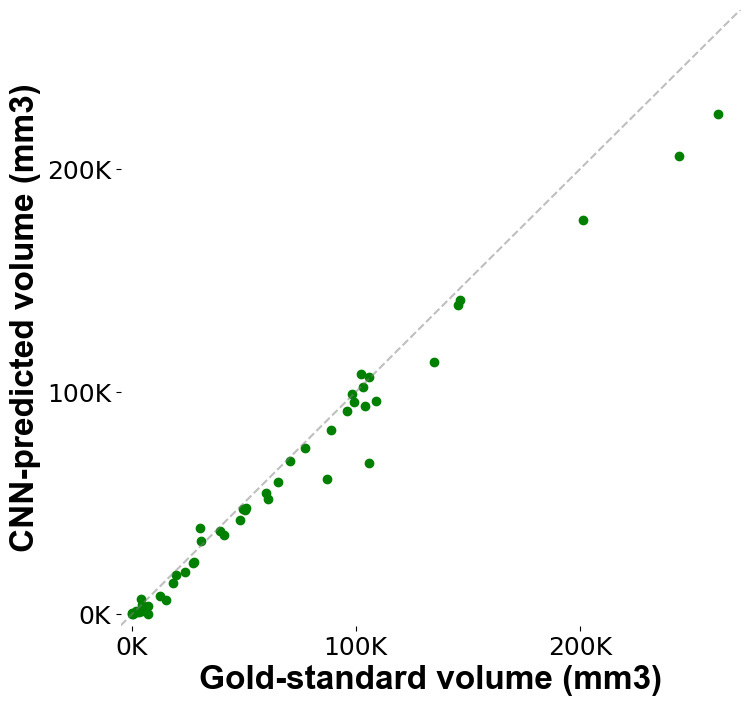

In [139]:
# Correlation 
# Define the formatter function to transform thousands to K
def format_func(value, tick_number):
    return f'{int(value / 1000)}K'
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(volume_test, volume_prediction, linewidth=0, marker='o', color='g')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Gold-standard volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('CNN-predicted volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.locator_params(nbins=5)
plt.xlim( ( min(min(volume_test), min(volume_prediction)) -5000), (max(max(volume_test), max(volume_prediction)) + 10000) ) 
plt.ylim( (min(min(volume_test), min(volume_prediction)) -5000), (max(max(volume_test), max(volume_prediction)) + 10000) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='gray', alpha=0.5)
plt.show()

#### Tuber volume in gray matter

In [140]:
# Calculate tuber volume in gray matter
volume_test_gray_matter = [np.sum(np.multiply(gray_matter_mask, Y_test_full_images[i, :, :, :])) for i in range(Y_test_full_images.shape[0])]
volume_prediction_gray_matter = [np.sum(np.multiply(gray_matter_mask, Y_predictions_full_images[i, :, :, :])) for i in range(Y_predictions_full_images.shape[0])]
total_volume_gray_matter = np.sum(gray_matter_mask)
gold_standard_proportion_gray_matter = [round(volume_test_gray_matter[i] / total_volume_gray_matter, 6) for i in range(len(volume_test_gray_matter))]
prediction_proportion_gray_matter = [round(volume_prediction_gray_matter[i] / total_volume_gray_matter, 6) for i in range(len(volume_prediction_gray_matter))]

In [141]:
# Calculate Spearman correlation coefficient
p_value_Spearman_gray_matter = stats.spearmanr(volume_test_gray_matter, volume_prediction_gray_matter)[1]
stats.spearmanr(volume_test_gray_matter, volume_prediction_gray_matter)

SignificanceResult(statistic=0.9875973624284562, pvalue=1.218342544939781e-38)

In [142]:
# Calculate the Spearman correlation coefficient 95% confidence interval using the Fisher transformation
correlation = stats.spearmanr(volume_test_gray_matter, volume_prediction_gray_matter)[0]
count = len(volume_test_gray_matter)

stderr = 1.0 / math.sqrt(count - 3)
delta = 1.96 * stderr
lower = math.tanh(math.atanh(correlation) - delta)
upper = math.tanh(math.atanh(correlation) + delta)

lower, correlation, upper

(0.9778606299818507, 0.9875973624284562, 0.9930669616973444)

In [143]:
# Correlation 
# Define the formatter function to transform thousands to K
def format_func(value, tick_number):
    return f'{int(value / 1000)}K'
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(volume_test_gray_matter, volume_prediction_gray_matter, linewidth=0, marker='o', color='g')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Gold-standard volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('CNN-predicted volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.locator_params(nbins=5)
plt.xlim( ( min(min(volume_test_gray_matter), min(volume_prediction_gray_matter)) -5000), (max(max(volume_test_gray_matter), max(volume_prediction_gray_matter)) + 10000) ) 
plt.ylim( (min(min(volume_test_gray_matter), min(volume_prediction_gray_matter)) -5000), (max(max(volume_test_gray_matter), max(volume_prediction_gray_matter)) + 10000) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='gray', alpha=0.5)
plt.show()

#### Tuber volume in right occipital lobe

In [144]:
# Calculate tuber volume in right occipital lobe
volume_test_R_occipital = [np.sum(np.multiply(R_occipital_mask, Y_test_full_images[i, :, :, :])) for i in range(Y_test_full_images.shape[0])]
volume_prediction_R_occipital = [np.sum(np.multiply(R_occipital_mask, Y_predictions_full_images[i, :, :, :])) for i in range(Y_predictions_full_images.shape[0])]
total_volume_R_occipital = np.sum(R_occipital_mask)
gold_standard_proportion_R_occipital = [round(volume_test_R_occipital[i] / total_volume_R_occipital, 6) for i in range(len(volume_test_R_occipital))]
prediction_proportion_R_occipital = [round(volume_prediction_R_occipital[i] / total_volume_R_occipital, 6) for i in range(len(volume_prediction_R_occipital))]

In [145]:
# Calculate Spearman correlation coefficient
p_value_Spearman_R_occipital = stats.spearmanr(volume_test_R_occipital, volume_prediction_R_occipital)[1]
stats.spearmanr(volume_test_R_occipital, volume_prediction_R_occipital)

SignificanceResult(statistic=0.9821704711910014, pvalue=4.854486002239272e-35)

In [146]:
# Calculate the Spearman correlation coefficient 95% confidence interval using the Fisher transformation
correlation = stats.spearmanr(volume_test_R_occipital, volume_prediction_R_occipital)[0]
count = len(volume_test_R_occipital)

stderr = 1.0 / math.sqrt(count - 3)
delta = 1.96 * stderr
lower = math.tanh(math.atanh(correlation) - delta)
upper = math.tanh(math.atanh(correlation) + delta)

lower, correlation, upper

(0.9682414137582791, 0.9821704711910014, 0.990021329930383)

In [147]:
# Correlation 
# Define the formatter function to transform thousands to K
def format_func(value, tick_number):
    return f'{int(value / 1000)}K'
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(volume_test_R_occipital, volume_prediction_R_occipital, linewidth=0, marker='o', color='g')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Gold-standard volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('CNN-predicted volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.locator_params(nbins=5)
plt.xlim( ( min(min(volume_test_R_occipital), min(volume_prediction_R_occipital)) -500), (max(max(volume_test_R_occipital), max(volume_prediction_R_occipital)) + 2000) ) 
plt.ylim( (min(min(volume_test_R_occipital), min(volume_prediction_R_occipital)) -500), (max(max(volume_test_R_occipital), max(volume_prediction_R_occipital)) + 2000) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='gray', alpha=0.5)
plt.show()

#### Tuber volume in left occipital lobe

In [148]:
# Calculate tuber volume in left occipital lobe
volume_test_L_occipital = [np.sum(np.multiply(L_occipital_mask, Y_test_full_images[i, :, :, :])) for i in range(Y_test_full_images.shape[0])]
volume_prediction_L_occipital = [np.sum(np.multiply(L_occipital_mask, Y_predictions_full_images[i, :, :, :])) for i in range(Y_predictions_full_images.shape[0])]
total_volume_L_occipital = np.sum(L_occipital_mask)
gold_standard_proportion_L_occipital = [round(volume_test_L_occipital[i] / total_volume_L_occipital, 6) for i in range(len(volume_test_L_occipital))]
prediction_proportion_L_occipital = [round(volume_prediction_L_occipital[i] / total_volume_L_occipital, 6) for i in range(len(volume_prediction_L_occipital))]

In [149]:
# Calculate Spearman correlation coefficient
p_value_Spearman_L_occipital = stats.spearmanr(volume_test_L_occipital, volume_prediction_L_occipital)[1]
stats.spearmanr(volume_test_L_occipital, volume_prediction_L_occipital)

SignificanceResult(statistic=0.9914948843480114, pvalue=2.1653167142855574e-42)

In [150]:
# Calculate the Spearman correlation coefficient 95% confidence interval using the Fisher transformation
correlation = stats.spearmanr(volume_test_L_occipital, volume_prediction_L_occipital)[0]
count = len(volume_test_L_occipital)

stderr = 1.0 / math.sqrt(count - 3)
delta = 1.96 * stderr
lower = math.tanh(math.atanh(correlation) - delta)
upper = math.tanh(math.atanh(correlation) + delta)

lower, correlation, upper

(0.9847945068670669, 0.9914948843480114, 0.9952497729692672)

In [151]:
# Correlation 
# Define the formatter function to transform thousands to K
def format_func(value, tick_number):
    return f'{int(value / 1000)}K'
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(volume_test_L_occipital, volume_prediction_L_occipital, linewidth=0, marker='o', color='g')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Gold-standard volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('CNN-predicted volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.locator_params(nbins=5)
plt.xlim( ( min(min(volume_test_L_occipital), min(volume_prediction_L_occipital)) -500), (max(max(volume_test_L_occipital), max(volume_prediction_L_occipital)) + 2000) ) 
plt.ylim( (min(min(volume_test_L_occipital), min(volume_prediction_L_occipital)) -500), (max(max(volume_test_L_occipital), max(volume_prediction_L_occipital)) + 2000) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='gray', alpha=0.5)
plt.show()

#### Tuber volume in right parietal lobe

In [152]:
# Calculate tuber volume in right parietal lobe
volume_test_R_parietal = [np.sum(np.multiply(R_parietal_mask, Y_test_full_images[i, :, :, :])) for i in range(Y_test_full_images.shape[0])]
volume_prediction_R_parietal = [np.sum(np.multiply(R_parietal_mask, Y_predictions_full_images[i, :, :, :])) for i in range(Y_predictions_full_images.shape[0])]
total_volume_R_parietal = np.sum(R_parietal_mask)
gold_standard_proportion_R_parietal = [round(volume_test_R_parietal[i] / total_volume_R_parietal, 6) for i in range(len(volume_test_R_parietal))]
prediction_proportion_R_parietal = [round(volume_prediction_R_parietal[i] / total_volume_R_parietal, 6) for i in range(len(volume_prediction_R_parietal))]

In [153]:
# Calculate Spearman correlation coefficient
p_value_Spearman_R_parietal = stats.spearmanr(volume_test_R_parietal, volume_prediction_R_parietal)[1]
stats.spearmanr(volume_test_R_parietal, volume_prediction_R_parietal)

SignificanceResult(statistic=0.9828935101754094, pvalue=1.8878358025124488e-35)

In [154]:
# Calculate the Spearman correlation coefficient 95% confidence interval using the Fisher transformation
correlation = stats.spearmanr(volume_test_R_parietal, volume_prediction_R_parietal)[0]
count = len(volume_test_R_parietal)

stderr = 1.0 / math.sqrt(count - 3)
delta = 1.96 * stderr
lower = math.tanh(math.atanh(correlation) - delta)
upper = math.tanh(math.atanh(correlation) + delta)

lower, correlation, upper

(0.9695206305518907, 0.9828935101754094, 0.9904275314000036)

In [155]:
# Correlation 
# Define the formatter function to transform thousands to K
def format_func(value, tick_number):
    return f'{int(value / 1000)}K'
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(volume_test_R_parietal, volume_prediction_R_parietal, linewidth=0, marker='o', color='g')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Gold-standard volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('CNN-predicted volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.locator_params(nbins=5)
plt.xlim( ( min(min(volume_test_R_parietal), min(volume_prediction_R_parietal)) -1000), (max(max(volume_test_R_parietal), max(volume_prediction_R_parietal)) + 2000) ) 
plt.ylim( (min(min(volume_test_R_parietal), min(volume_prediction_R_parietal)) -1000), (max(max(volume_test_R_parietal), max(volume_prediction_R_parietal)) + 2000) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='gray', alpha=0.5)
plt.show()

#### Tuber volume in left parietal lobe

In [156]:
# Calculate tuber volume in left parietal lobe
volume_test_L_parietal = [np.sum(np.multiply(L_parietal_mask, Y_test_full_images[i, :, :, :])) for i in range(Y_test_full_images.shape[0])]
volume_prediction_L_parietal = [np.sum(np.multiply(L_parietal_mask, Y_predictions_full_images[i, :, :, :])) for i in range(Y_predictions_full_images.shape[0])]
total_volume_L_parietal = np.sum(L_parietal_mask)
gold_standard_proportion_L_parietal = [round(volume_test_L_parietal[i] / total_volume_L_parietal, 6) for i in range(len(volume_test_L_parietal))]
prediction_proportion_L_parietal = [round(volume_prediction_L_parietal[i] / total_volume_L_parietal, 6) for i in range(len(volume_prediction_L_parietal))]

In [157]:
# Calculate Spearman correlation coefficient
p_value_Spearman_L_parietal = stats.spearmanr(volume_test_L_parietal, volume_prediction_L_parietal)[1]
stats.spearmanr(volume_test_L_parietal, volume_prediction_L_parietal)

SignificanceResult(statistic=0.9886254926804934, pvalue=1.6831731926718763e-39)

In [158]:
# Calculate the Spearman correlation coefficient 95% confidence interval using the Fisher transformation
correlation = stats.spearmanr(volume_test_L_parietal, volume_prediction_L_parietal)[0]
count = len(volume_test_L_parietal)

stderr = 1.0 / math.sqrt(count - 3)
delta = 1.96 * stderr
lower = math.tanh(math.atanh(correlation) - delta)
upper = math.tanh(math.atanh(correlation) + delta)

lower, correlation, upper

(0.9796876487766434, 0.9886254926804934, 0.9936431336367711)

In [159]:
# Correlation 
# Define the formatter function to transform thousands to K
def format_func(value, tick_number):
    return f'{int(value / 1000)}K'
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(volume_test_L_parietal, volume_prediction_L_parietal, linewidth=0, marker='o', color='g')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Gold-standard volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('CNN-predicted volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.locator_params(nbins=5)
plt.xlim( ( min(min(volume_test_L_parietal), min(volume_prediction_L_parietal)) -1000), (max(max(volume_test_L_parietal), max(volume_prediction_L_parietal)) + 2000) ) 
plt.ylim( (min(min(volume_test_L_parietal), min(volume_prediction_L_parietal)) -1000), (max(max(volume_test_L_parietal), max(volume_prediction_L_parietal)) + 2000) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='gray', alpha=0.5)
plt.show()

#### Tuber volume in right temporal lobe

In [160]:
# Calculate tuber volume in right temporal lobe
volume_test_R_temporal = [np.sum(np.multiply(R_temporal_mask, Y_test_full_images[i, :, :, :])) for i in range(Y_test_full_images.shape[0])]
volume_prediction_R_temporal = [np.sum(np.multiply(R_temporal_mask, Y_predictions_full_images[i, :, :, :])) for i in range(Y_predictions_full_images.shape[0])]
total_volume_R_temporal = np.sum(R_temporal_mask)
gold_standard_proportion_R_temporal = [round(volume_test_R_temporal[i] / total_volume_R_temporal, 6) for i in range(len(volume_test_R_temporal))]
prediction_proportion_R_temporal = [round(volume_prediction_R_temporal[i] / total_volume_R_temporal, 6) for i in range(len(volume_prediction_R_temporal))]

In [161]:
# Calculate Spearman correlation coefficient
p_value_Spearman_R_temporal = stats.spearmanr(volume_test_R_temporal, volume_prediction_R_temporal)[1]
stats.spearmanr(volume_test_R_temporal, volume_prediction_R_temporal)

SignificanceResult(statistic=0.9671040788900441, pvalue=5.425002527119742e-29)

In [162]:
# Calculate the Spearman correlation coefficient 95% confidence interval using the Fisher transformation
correlation = stats.spearmanr(volume_test_R_temporal, volume_prediction_R_temporal)[0]
count = len(volume_test_R_temporal)

stderr = 1.0 / math.sqrt(count - 3)
delta = 1.96 * stderr
lower = math.tanh(math.atanh(correlation) - delta)
upper = math.tanh(math.atanh(correlation) + delta)

lower, correlation, upper

(0.9417505171708789, 0.9671040788900441, 0.9815272804624449)

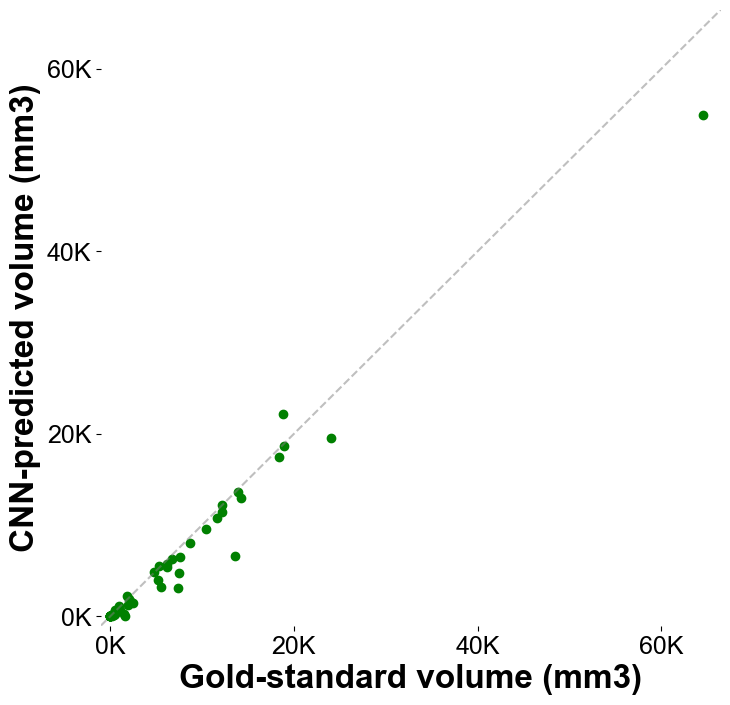

In [163]:
# Correlation 
# Define the formatter function to transform thousands to K
def format_func(value, tick_number):
    return f'{int(value / 1000)}K'
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(volume_test_R_temporal, volume_prediction_R_temporal, linewidth=0, marker='o', color='g')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Gold-standard volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('CNN-predicted volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.locator_params(nbins=5)
plt.xlim( ( min(min(volume_test_R_temporal), min(volume_prediction_R_temporal)) -1000), (max(max(volume_test_R_temporal), max(volume_prediction_R_temporal)) + 2000) ) 
plt.ylim( (min(min(volume_test_R_temporal), min(volume_prediction_R_temporal)) -1000), (max(max(volume_test_R_temporal), max(volume_prediction_R_temporal)) + 2000) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='gray', alpha=0.5)
plt.show()

#### Tuber volume in left temporal lobe

In [164]:
# Calculate tuber volume in left temporal lobe
volume_test_L_temporal = [np.sum(np.multiply(L_temporal_mask, Y_test_full_images[i, :, :, :])) for i in range(Y_test_full_images.shape[0])]
volume_prediction_L_temporal = [np.sum(np.multiply(L_temporal_mask, Y_predictions_full_images[i, :, :, :])) for i in range(Y_predictions_full_images.shape[0])]
total_volume_L_temporal = np.sum(L_temporal_mask)
gold_standard_proportion_L_temporal = [round(volume_test_L_temporal[i] / total_volume_L_temporal, 6) for i in range(len(volume_test_L_temporal))]
prediction_proportion_L_temporal = [round(volume_prediction_L_temporal[i] / total_volume_L_temporal, 6) for i in range(len(volume_prediction_L_temporal))]

In [165]:
# Calculate Spearman correlation coefficient
p_value_Spearman_L_temporal = stats.spearmanr(volume_test_L_temporal, volume_prediction_L_temporal)[1]
stats.spearmanr(volume_test_L_temporal, volume_prediction_L_temporal)

SignificanceResult(statistic=0.935853846902846, pvalue=1.8143132222599911e-22)

In [166]:
# Calculate the Spearman correlation coefficient 95% confidence interval using the Fisher transformation
correlation = stats.spearmanr(volume_test_L_temporal, volume_prediction_L_temporal)[0]
count = len(volume_test_L_temporal)

stderr = 1.0 / math.sqrt(count - 3)
delta = 1.96 * stderr
lower = math.tanh(math.atanh(correlation) - delta)
upper = math.tanh(math.atanh(correlation) + delta)

lower, correlation, upper

(0.8877889998011993, 0.935853846902846, 0.9637260360457759)

In [167]:
# Correlation 
# Define the formatter function to transform thousands to K
def format_func(value, tick_number):
    return f'{int(value / 1000)}K'
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(volume_test_L_temporal, volume_prediction_L_temporal, linewidth=0, marker='o', color='g')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Gold-standard volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('CNN-predicted volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.locator_params(nbins=5)
plt.xlim( ( min(min(volume_test_L_temporal), min(volume_prediction_L_temporal)) -1000), (max(max(volume_test_L_temporal), max(volume_prediction_L_temporal)) + 2000) ) 
plt.ylim( (min(min(volume_test_L_temporal), min(volume_prediction_L_temporal)) -1000), (max(max(volume_test_L_temporal), max(volume_prediction_L_temporal)) + 2000) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='gray', alpha=0.5)
plt.show()

#### Tuber volume in right frontal lobe

In [168]:
# Calculate tuber volume in right frontal lobe
volume_test_R_frontal = [np.sum(np.multiply(R_frontal_mask, Y_test_full_images[i, :, :, :])) for i in range(Y_test_full_images.shape[0])]
volume_prediction_R_frontal = [np.sum(np.multiply(R_frontal_mask, Y_predictions_full_images[i, :, :, :])) for i in range(Y_predictions_full_images.shape[0])]
total_volume_R_frontal = np.sum(R_frontal_mask)
gold_standard_proportion_R_frontal = [round(volume_test_R_frontal[i] / total_volume_R_frontal, 6) for i in range(len(volume_test_R_frontal))]
prediction_proportion_R_frontal = [round(volume_prediction_R_frontal[i] / total_volume_R_frontal, 6) for i in range(len(volume_prediction_R_frontal))]

In [169]:
# Calculate Spearman correlation coefficient
p_value_Spearman_R_frontal = stats.spearmanr(volume_test_R_frontal, volume_prediction_R_frontal)[1]
stats.spearmanr(volume_test_R_frontal, volume_prediction_R_frontal)

SignificanceResult(statistic=0.9727785919774196, pvalue=7.403216328717288e-31)

In [170]:
# Calculate the Spearman correlation coefficient 95% confidence interval using the Fisher transformation
correlation = stats.spearmanr(volume_test_R_frontal, volume_prediction_R_frontal)[0]
count = len(volume_test_R_frontal)

stderr = 1.0 / math.sqrt(count - 3)
delta = 1.96 * stderr
lower = math.tanh(math.atanh(correlation) - delta)
upper = math.tanh(math.atanh(correlation) + delta)

lower, correlation, upper

(0.9516910887540877, 0.9727785919774196, 0.9847331153931672)

In [171]:
# Correlation 
# Define the formatter function to transform thousands to K
def format_func(value, tick_number):
    return f'{int(value / 1000)}K'
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(volume_test_R_frontal, volume_prediction_R_frontal, linewidth=0, marker='o', color='g')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Gold-standard volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('CNN-predicted volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.locator_params(nbins=5)
plt.xlim( ( min(min(volume_test_R_frontal), min(volume_prediction_R_frontal)) -2000), (max(max(volume_test_R_frontal), max(volume_prediction_R_frontal)) + 5000) ) 
plt.ylim( (min(min(volume_test_R_frontal), min(volume_prediction_R_frontal)) -2000), (max(max(volume_test_R_frontal), max(volume_prediction_R_frontal)) + 5000) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='gray', alpha=0.5)
plt.show()

#### Tuber volume in left frontal lobe

In [172]:
# Calculate tuber volume in left frontal lobe
volume_test_L_frontal = [np.sum(np.multiply(L_frontal_mask, Y_test_full_images[i, :, :, :])) for i in range(Y_test_full_images.shape[0])]
volume_prediction_L_frontal = [np.sum(np.multiply(L_frontal_mask, Y_predictions_full_images[i, :, :, :])) for i in range(Y_predictions_full_images.shape[0])]
total_volume_L_frontal = np.sum(L_frontal_mask)
gold_standard_proportion_L_frontal = [round(volume_test_L_frontal[i] / total_volume_L_frontal, 6) for i in range(len(volume_test_L_frontal))]
prediction_proportion_L_frontal = [round(volume_prediction_L_frontal[i] / total_volume_L_frontal, 6) for i in range(len(volume_prediction_L_frontal))]

In [173]:
# Calculate Spearman correlation coefficient
p_value_Spearman_L_frontal = stats.spearmanr(volume_test_L_frontal, volume_prediction_L_frontal)[1]
stats.spearmanr(volume_test_L_frontal, volume_prediction_L_frontal)

SignificanceResult(statistic=0.9662305584303996, pvalue=9.820201599196622e-29)

In [174]:
# Calculate the Spearman correlation coefficient 95% confidence interval using the Fisher transformation
correlation = stats.spearmanr(volume_test_L_frontal, volume_prediction_L_frontal)[0]
count = len(volume_test_L_frontal)

stderr = 1.0 / math.sqrt(count - 3)
delta = 1.96 * stderr
lower = math.tanh(math.atanh(correlation) - delta)
upper = math.tanh(math.atanh(correlation) + delta)

lower, correlation, upper

(0.9402242147859102, 0.9662305584303996, 0.9810330617911294)

In [175]:
# Correlation 
# Define the formatter function to transform thousands to K
def format_func(value, tick_number):
    return f'{int(value / 1000)}K'
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(volume_test_L_frontal, volume_prediction_L_frontal, linewidth=0, marker='o', color='g')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Gold-standard volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('CNN-predicted volume (mm3)', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.locator_params(nbins=5)
plt.xlim( ( min(min(volume_test_L_frontal), min(volume_prediction_L_frontal)) -2000), (max(max(volume_test_L_frontal), max(volume_prediction_L_frontal)) + 5000) ) 
plt.ylim( (min(min(volume_test_L_frontal), min(volume_prediction_L_frontal)) -2000), (max(max(volume_test_L_frontal), max(volume_prediction_L_frontal)) + 5000) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='gray', alpha=0.5)
plt.show()

### Adjust for multiple comparisons

In [176]:
# False discovery rate adjustmnent
original_p_values = np.array([
    p_value_Spearman,
    p_value_Spearman_gray_matter,
    p_value_Spearman_R_occipital,
    p_value_Spearman_L_occipital,   
    p_value_Spearman_R_parietal,
    p_value_Spearman_L_parietal,
    p_value_Spearman_R_temporal,
    p_value_Spearman_L_temporal,
    p_value_Spearman_R_frontal,
    p_value_Spearman_L_frontal
])

FDR_adjusted_p_values = stats.false_discovery_control(original_p_values, method='bh')

original_p_values, FDR_adjusted_p_values

(array([8.28557987e-36, 1.21834254e-38, 4.85448600e-35, 2.16531671e-42,
        1.88783580e-35, 1.68317319e-39, 5.42500253e-29, 1.81431322e-22,
        7.40321633e-31, 9.82020160e-29]),
 array([2.07139497e-35, 4.06114182e-38, 8.09081000e-35, 2.16531671e-41,
        3.77567161e-35, 8.41586596e-39, 6.78125316e-29, 1.81431322e-22,
        1.05760233e-30, 1.09113351e-28]))

<a id='logtransformation'></a>

### Correlation log-transformed ↓↓ SCROLL DOWN ↓↓ 

#### Total tuber volume (log-transformed)

In [177]:
# Correlation 
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.clip(np.log(volume_test), 0, None), np.clip(np.log(volume_prediction), 0, None), linewidth=0, marker='o', color='g')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Log of gold-standard volume', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('Log of CNN-predicted volume', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.locator_params(nbins=5)
plt.xlim( ( min(min(np.clip(np.log(volume_test), 0, None)), min(np.clip(np.log(volume_prediction), 0, None))) -1), (max(max(np.clip(np.log(volume_test), 0, None)), max(np.clip(np.log(volume_prediction), 0, None)))) +5) 
plt.ylim( (min(min(np.clip(np.log(volume_test), 0, None)), min(np.clip(np.log(volume_prediction), 0, None))) -1), (max(max(np.clip(np.log(volume_test), 0, None)), max(np.clip(np.log(volume_prediction), 0, None)))) +5)
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='gray', alpha=0.5)
plt.show()

/tmp/ipykernel_554520/1842502839.py:4: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.clip(np.log(volume_test), 0, None), np.clip(np.log(volume_prediction), 0, None), linewidth=0, marker='o', color='g')
/tmp/ipykernel_554520/1842502839.py:12: RuntimeWarning: divide by zero encountered in log
  plt.xlim( ( min(min(np.clip(np.log(volume_test), 0, None)), min(np.clip(np.log(volume_prediction), 0, None))) -1), (max(max(np.clip(np.log(volume_test), 0, None)), max(np.clip(np.log(volume_prediction), 0, None)))) +5)
/tmp/ipykernel_554520/1842502839.py:13: RuntimeWarning: divide by zero encountered in log
  plt.ylim( (min(min(np.clip(np.log(volume_test), 0, None)), min(np.clip(np.log(volume_prediction), 0, None))) -1), (max(max(np.clip(np.log(volume_test), 0, None)), max(np.clip(np.log(volume_prediction), 0, None)))) +5)


#### Tuber volume in gray matter (log-transformed)

/tmp/ipykernel_554520/3658656477.py:4: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.clip(np.log(volume_test_gray_matter), 0, None), np.clip(np.log(volume_prediction_gray_matter), 0, None), linewidth=0, marker='o', color='g')
/tmp/ipykernel_554520/3658656477.py:12: RuntimeWarning: divide by zero encountered in log
  plt.xlim( ( min(min(np.clip(np.log(volume_test_gray_matter), 0, None)), min(np.clip(np.log(volume_prediction_gray_matter), 0, None))) -1), (max(max(np.clip(np.log(volume_test_gray_matter), 0, None)), max(np.clip(np.log(volume_prediction_gray_matter), 0, None))) + 5) )
/tmp/ipykernel_554520/3658656477.py:13: RuntimeWarning: divide by zero encountered in log
  plt.ylim( (min(min(np.clip(np.log(volume_test_gray_matter), 0, None)), min(np.clip(np.log(volume_prediction_gray_matter), 0, None))) -1), (max(max(np.clip(np.log(volume_test_gray_matter), 0, None)), max(np.clip(np.log(volume_prediction_gray_matter), 0, None))) + 5) )


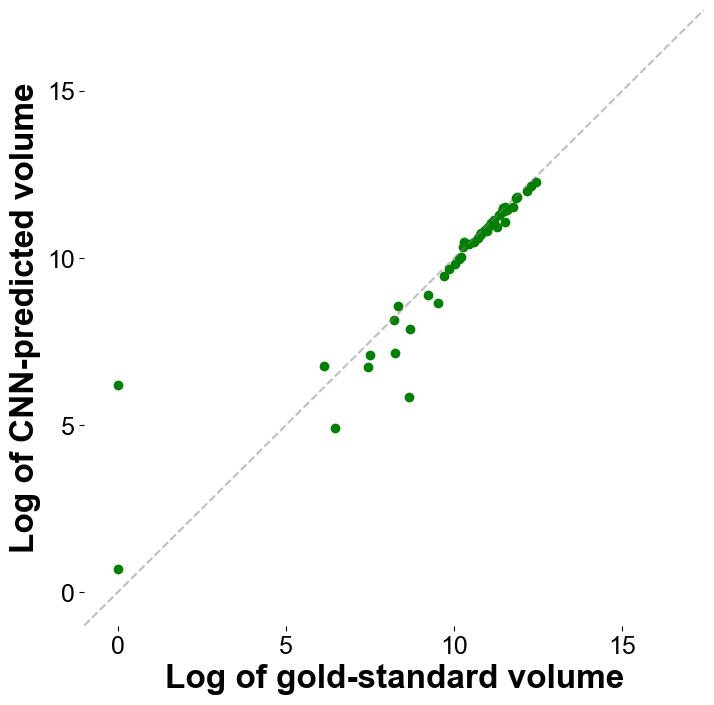

In [178]:
# Correlation 
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.clip(np.log(volume_test_gray_matter), 0, None), np.clip(np.log(volume_prediction_gray_matter), 0, None), linewidth=0, marker='o', color='g')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Log of gold-standard volume', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('Log of CNN-predicted volume', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.locator_params(nbins=5)
plt.xlim( ( min(min(np.clip(np.log(volume_test_gray_matter), 0, None)), min(np.clip(np.log(volume_prediction_gray_matter), 0, None))) -1), (max(max(np.clip(np.log(volume_test_gray_matter), 0, None)), max(np.clip(np.log(volume_prediction_gray_matter), 0, None))) + 5) ) 
plt.ylim( (min(min(np.clip(np.log(volume_test_gray_matter), 0, None)), min(np.clip(np.log(volume_prediction_gray_matter), 0, None))) -1), (max(max(np.clip(np.log(volume_test_gray_matter), 0, None)), max(np.clip(np.log(volume_prediction_gray_matter), 0, None))) + 5) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='gray', alpha=0.5)
plt.show()

#### Tuber volume in right occipital lobe (log-transformed)

/tmp/ipykernel_554520/3468225306.py:4: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.clip(np.log(volume_test_R_occipital), 0, None), np.clip(np.log(volume_prediction_R_occipital), 0, None), linewidth=0, marker='o', color='g')
/tmp/ipykernel_554520/3468225306.py:12: RuntimeWarning: divide by zero encountered in log
  plt.xlim( ( min(min(np.clip(np.log(volume_test_R_occipital), 0, None)), min(np.clip(np.log(volume_prediction_R_occipital), 0, None))) -1), (max(max(np.clip(np.log(volume_test_R_occipital), 0, None)), max(np.clip(np.log(volume_prediction_R_occipital), 0, None))) + 5) )
/tmp/ipykernel_554520/3468225306.py:13: RuntimeWarning: divide by zero encountered in log
  plt.ylim( (min(min(np.clip(np.log(volume_test_R_occipital), 0, None)), min(np.clip(np.log(volume_prediction_R_occipital), 0, None))) -1), (max(max(np.clip(np.log(volume_test_R_occipital), 0, None)), max(np.clip(np.log(volume_prediction_R_occipital), 0, None))) + 5) )


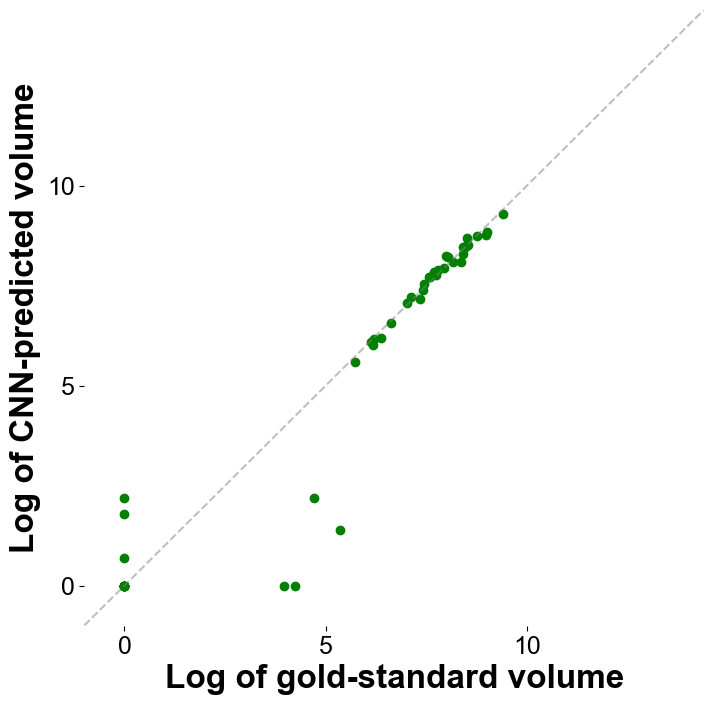

In [179]:
# Correlation 
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.clip(np.log(volume_test_R_occipital), 0, None), np.clip(np.log(volume_prediction_R_occipital), 0, None), linewidth=0, marker='o', color='g')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Log of gold-standard volume', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('Log of CNN-predicted volume', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.locator_params(nbins=5)
plt.xlim( ( min(min(np.clip(np.log(volume_test_R_occipital), 0, None)), min(np.clip(np.log(volume_prediction_R_occipital), 0, None))) -1), (max(max(np.clip(np.log(volume_test_R_occipital), 0, None)), max(np.clip(np.log(volume_prediction_R_occipital), 0, None))) + 5) ) 
plt.ylim( (min(min(np.clip(np.log(volume_test_R_occipital), 0, None)), min(np.clip(np.log(volume_prediction_R_occipital), 0, None))) -1), (max(max(np.clip(np.log(volume_test_R_occipital), 0, None)), max(np.clip(np.log(volume_prediction_R_occipital), 0, None))) + 5) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='gray', alpha=0.5)
plt.show()

#### Tuber volume in left occipital lobe (log-transformed)

In [180]:
# Correlation 
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.clip(np.log(volume_test_L_occipital), 0, None), np.clip(np.log(volume_prediction_L_occipital), 0, None), linewidth=0, marker='o', color='g')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Log of gold-standard volume', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('Log of CNN-predicted volume', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.locator_params(nbins=5)
plt.xlim( ( min(min(np.clip(np.log(volume_test_L_occipital), 0, None)), min(np.clip(np.log(volume_prediction_L_occipital), 0, None))) -1), (max(max(np.clip(np.log(volume_test_L_occipital), 0, None)), max(np.clip(np.log(volume_prediction_L_occipital), 0, None))) + 5) ) 
plt.ylim( (min(min(np.clip(np.log(volume_test_L_occipital), 0, None)), min(np.clip(np.log(volume_prediction_L_occipital), 0, None))) -1), (max(max(np.clip(np.log(volume_test_L_occipital), 0, None)), max(np.clip(np.log(volume_prediction_L_occipital), 0, None))) + 5) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='gray', alpha=0.5)
plt.show()

/tmp/ipykernel_554520/156373370.py:4: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.clip(np.log(volume_test_L_occipital), 0, None), np.clip(np.log(volume_prediction_L_occipital), 0, None), linewidth=0, marker='o', color='g')
/tmp/ipykernel_554520/156373370.py:12: RuntimeWarning: divide by zero encountered in log
  plt.xlim( ( min(min(np.clip(np.log(volume_test_L_occipital), 0, None)), min(np.clip(np.log(volume_prediction_L_occipital), 0, None))) -1), (max(max(np.clip(np.log(volume_test_L_occipital), 0, None)), max(np.clip(np.log(volume_prediction_L_occipital), 0, None))) + 5) )
/tmp/ipykernel_554520/156373370.py:13: RuntimeWarning: divide by zero encountered in log
  plt.ylim( (min(min(np.clip(np.log(volume_test_L_occipital), 0, None)), min(np.clip(np.log(volume_prediction_L_occipital), 0, None))) -1), (max(max(np.clip(np.log(volume_test_L_occipital), 0, None)), max(np.clip(np.log(volume_prediction_L_occipital), 0, None))) + 5) )


#### Tuber volume in right parietal lobe (log-transformed)

/tmp/ipykernel_554520/827437136.py:4: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.clip(np.log(volume_test_R_parietal), 0, None), np.clip(np.log(volume_prediction_R_parietal), 0, None), linewidth=0, marker='o', color='g')
/tmp/ipykernel_554520/827437136.py:12: RuntimeWarning: divide by zero encountered in log
  plt.xlim( ( min(min(np.clip(np.log(volume_test_R_parietal), 0, None)), min(np.clip(np.log(volume_prediction_R_parietal), 0, None))) -1), (max(max(np.clip(np.log(volume_test_R_parietal), 0, None)), max(np.clip(np.log(volume_prediction_R_parietal), 0, None))) + 5) )
/tmp/ipykernel_554520/827437136.py:13: RuntimeWarning: divide by zero encountered in log
  plt.ylim( (min(min(np.clip(np.log(volume_test_R_parietal), 0, None)), min(np.clip(np.log(volume_prediction_R_parietal), 0, None))) -1), (max(max(np.clip(np.log(volume_test_R_parietal), 0, None)), max(np.clip(np.log(volume_prediction_R_parietal), 0, None))) + 5) )


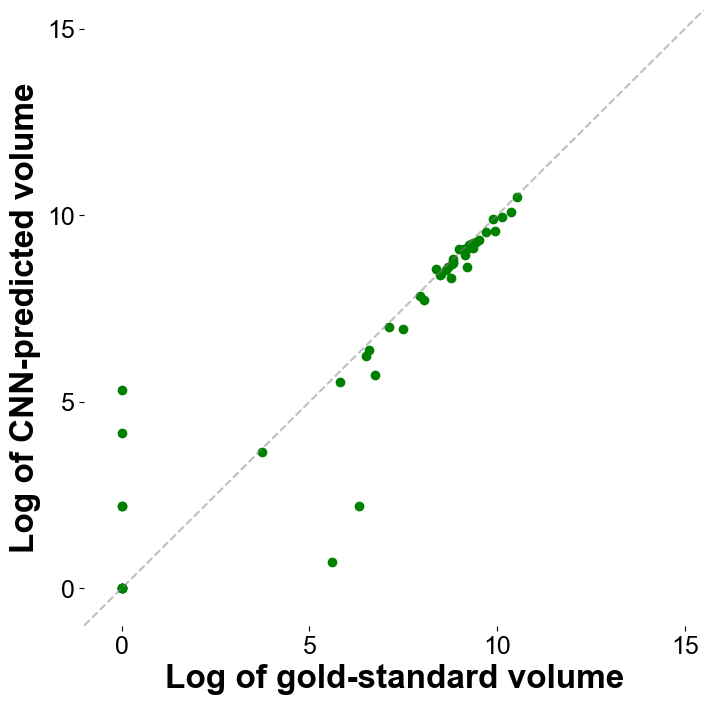

In [181]:
# Correlation 
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.clip(np.log(volume_test_R_parietal), 0, None), np.clip(np.log(volume_prediction_R_parietal), 0, None), linewidth=0, marker='o', color='g')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Log of gold-standard volume', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('Log of CNN-predicted volume', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.locator_params(nbins=5)
plt.xlim( ( min(min(np.clip(np.log(volume_test_R_parietal), 0, None)), min(np.clip(np.log(volume_prediction_R_parietal), 0, None))) -1), (max(max(np.clip(np.log(volume_test_R_parietal), 0, None)), max(np.clip(np.log(volume_prediction_R_parietal), 0, None))) + 5) ) 
plt.ylim( (min(min(np.clip(np.log(volume_test_R_parietal), 0, None)), min(np.clip(np.log(volume_prediction_R_parietal), 0, None))) -1), (max(max(np.clip(np.log(volume_test_R_parietal), 0, None)), max(np.clip(np.log(volume_prediction_R_parietal), 0, None))) + 5) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='gray', alpha=0.5)
plt.show()

#### Tuber volume in left parietal lobe (log-transformed)

/tmp/ipykernel_554520/3576273781.py:4: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.clip(np.log(volume_test_L_parietal), 0, None), np.clip(np.log(volume_prediction_L_parietal), 0, None), linewidth=0, marker='o', color='g')
/tmp/ipykernel_554520/3576273781.py:12: RuntimeWarning: divide by zero encountered in log
  plt.xlim( ( min(min(np.clip(np.log(volume_test_L_parietal), 0, None)), min(np.clip(np.log(volume_prediction_L_parietal), 0, None))) -1), (max(max(np.clip(np.log(volume_test_L_parietal), 0, None)), max(np.clip(np.log(volume_prediction_L_parietal), 0, None))) + 5) )
/tmp/ipykernel_554520/3576273781.py:13: RuntimeWarning: divide by zero encountered in log
  plt.ylim( (min(min(np.clip(np.log(volume_test_L_parietal), 0, None)), min(np.clip(np.log(volume_prediction_L_parietal), 0, None))) -1), (max(max(np.clip(np.log(volume_test_L_parietal), 0, None)), max(np.clip(np.log(volume_prediction_L_parietal), 0, None))) + 5) )


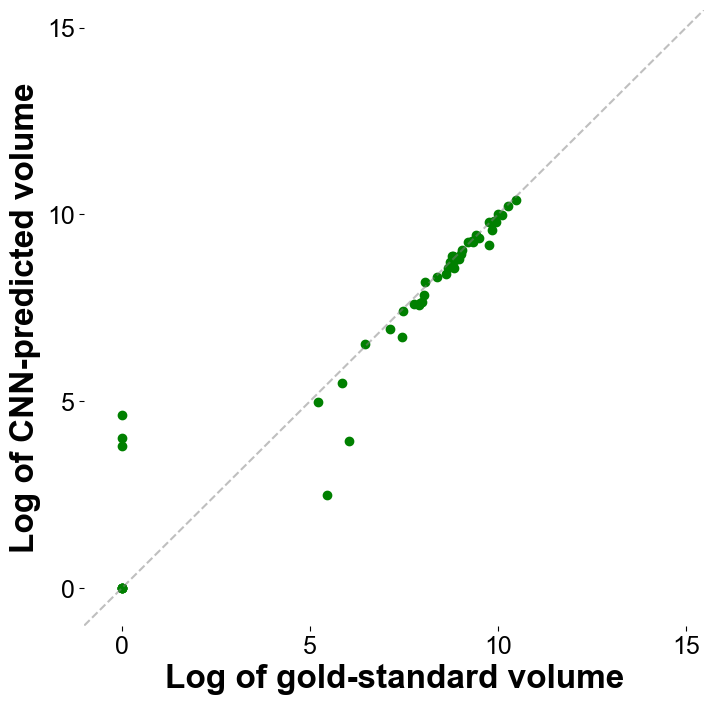

In [182]:
# Correlation 
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.clip(np.log(volume_test_L_parietal), 0, None), np.clip(np.log(volume_prediction_L_parietal), 0, None), linewidth=0, marker='o', color='g')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Log of gold-standard volume', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('Log of CNN-predicted volume', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.locator_params(nbins=5)
plt.xlim( ( min(min(np.clip(np.log(volume_test_L_parietal), 0, None)), min(np.clip(np.log(volume_prediction_L_parietal), 0, None))) -1), (max(max(np.clip(np.log(volume_test_L_parietal), 0, None)), max(np.clip(np.log(volume_prediction_L_parietal), 0, None))) + 5) ) 
plt.ylim( (min(min(np.clip(np.log(volume_test_L_parietal), 0, None)), min(np.clip(np.log(volume_prediction_L_parietal), 0, None))) -1), (max(max(np.clip(np.log(volume_test_L_parietal), 0, None)), max(np.clip(np.log(volume_prediction_L_parietal), 0, None))) + 5) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='gray', alpha=0.5)
plt.show()

#### Tuber volume in right temporal lobe (log-transformed)

In [183]:
# Correlation 
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.clip(np.log(volume_test_R_temporal), 0, None), np.clip(np.log(volume_prediction_R_temporal), 0, None), linewidth=0, marker='o', color='g')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Log of gold-standard volume', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('Log of CNN-predicted volume', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.locator_params(nbins=5)
plt.xlim( ( min(min(np.clip(np.log(volume_test_R_temporal), 0, None)), min(np.clip(np.log(volume_prediction_R_temporal), 0, None))) -1), (max(max(np.clip(np.log(volume_test_R_temporal), 0, None)), max(np.clip(np.log(volume_prediction_R_temporal), 0, None))) + 5) ) 
plt.ylim( (min(min(np.clip(np.log(volume_test_R_temporal), 0, None)), min(np.clip(np.log(volume_prediction_R_temporal), 0, None))) -1), (max(max(np.clip(np.log(volume_test_R_temporal), 0, None)), max(np.clip(np.log(volume_prediction_R_temporal), 0, None))) + 5) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='gray', alpha=0.5)
plt.show()

/tmp/ipykernel_554520/1296944035.py:4: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.clip(np.log(volume_test_R_temporal), 0, None), np.clip(np.log(volume_prediction_R_temporal), 0, None), linewidth=0, marker='o', color='g')
/tmp/ipykernel_554520/1296944035.py:12: RuntimeWarning: divide by zero encountered in log
  plt.xlim( ( min(min(np.clip(np.log(volume_test_R_temporal), 0, None)), min(np.clip(np.log(volume_prediction_R_temporal), 0, None))) -1), (max(max(np.clip(np.log(volume_test_R_temporal), 0, None)), max(np.clip(np.log(volume_prediction_R_temporal), 0, None))) + 5) )
/tmp/ipykernel_554520/1296944035.py:13: RuntimeWarning: divide by zero encountered in log
  plt.ylim( (min(min(np.clip(np.log(volume_test_R_temporal), 0, None)), min(np.clip(np.log(volume_prediction_R_temporal), 0, None))) -1), (max(max(np.clip(np.log(volume_test_R_temporal), 0, None)), max(np.clip(np.log(volume_prediction_R_temporal), 0, None))) + 5) )


#### Tuber volume in left temporal lobe (log-transformed)

In [184]:
# Correlation 
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.clip(np.log(volume_test_L_temporal), 0, None), np.clip(np.log(volume_prediction_L_temporal), 0, None), linewidth=0, marker='o', color='g')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Log of gold-standard volume', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('Log of CNN-predicted volume', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.locator_params(nbins=5)
plt.xlim( ( min(min(np.clip(np.log(volume_test_L_temporal), 0, None)), min(np.clip(np.log(volume_prediction_L_temporal), 0, None))) -1), (max(max(np.clip(np.log(volume_test_L_temporal), 0, None)), max(np.clip(np.log(volume_prediction_L_temporal), 0, None))) + 5) ) 
plt.ylim( (min(min(np.clip(np.log(volume_test_L_temporal), 0, None)), min(np.clip(np.log(volume_prediction_L_temporal), 0, None))) -1), (max(max(np.clip(np.log(volume_test_L_temporal), 0, None)), max(np.clip(np.log(volume_prediction_L_temporal), 0, None))) + 5) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='gray', alpha=0.5)
plt.show()

/tmp/ipykernel_554520/1936822920.py:4: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.clip(np.log(volume_test_L_temporal), 0, None), np.clip(np.log(volume_prediction_L_temporal), 0, None), linewidth=0, marker='o', color='g')
/tmp/ipykernel_554520/1936822920.py:12: RuntimeWarning: divide by zero encountered in log
  plt.xlim( ( min(min(np.clip(np.log(volume_test_L_temporal), 0, None)), min(np.clip(np.log(volume_prediction_L_temporal), 0, None))) -1), (max(max(np.clip(np.log(volume_test_L_temporal), 0, None)), max(np.clip(np.log(volume_prediction_L_temporal), 0, None))) + 5) )
/tmp/ipykernel_554520/1936822920.py:13: RuntimeWarning: divide by zero encountered in log
  plt.ylim( (min(min(np.clip(np.log(volume_test_L_temporal), 0, None)), min(np.clip(np.log(volume_prediction_L_temporal), 0, None))) -1), (max(max(np.clip(np.log(volume_test_L_temporal), 0, None)), max(np.clip(np.log(volume_prediction_L_temporal), 0, None))) + 5) )


#### Tuber volume in right frontal lobe (log-transformed)

In [185]:
# Correlation 
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.clip(np.log(volume_test_R_frontal), 0, None), np.clip(np.log(volume_prediction_R_frontal), 0, None), linewidth=0, marker='o', color='g')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Log of gold-standard volume', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('Log of CNN-predicted volume', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.locator_params(nbins=5)
plt.xlim( ( min(min(np.clip(np.log(volume_test_R_frontal), 0, None)), min(np.clip(np.log(volume_prediction_R_frontal), 0, None))) -1), (max(max(np.clip(np.log(volume_test_R_frontal), 0, None)), max(np.clip(np.log(volume_prediction_R_frontal), 0, None))) + 5) ) 
plt.ylim( (min(min(np.clip(np.log(volume_test_R_frontal), 0, None)), min(np.clip(np.log(volume_prediction_R_frontal), 0, None))) -1), (max(max(np.clip(np.log(volume_test_R_frontal), 0, None)), max(np.clip(np.log(volume_prediction_R_frontal), 0, None))) + 5) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='gray', alpha=0.5)
plt.show()

/tmp/ipykernel_554520/2583068647.py:4: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.clip(np.log(volume_test_R_frontal), 0, None), np.clip(np.log(volume_prediction_R_frontal), 0, None), linewidth=0, marker='o', color='g')
/tmp/ipykernel_554520/2583068647.py:12: RuntimeWarning: divide by zero encountered in log
  plt.xlim( ( min(min(np.clip(np.log(volume_test_R_frontal), 0, None)), min(np.clip(np.log(volume_prediction_R_frontal), 0, None))) -1), (max(max(np.clip(np.log(volume_test_R_frontal), 0, None)), max(np.clip(np.log(volume_prediction_R_frontal), 0, None))) + 5) )
/tmp/ipykernel_554520/2583068647.py:13: RuntimeWarning: divide by zero encountered in log
  plt.ylim( (min(min(np.clip(np.log(volume_test_R_frontal), 0, None)), min(np.clip(np.log(volume_prediction_R_frontal), 0, None))) -1), (max(max(np.clip(np.log(volume_test_R_frontal), 0, None)), max(np.clip(np.log(volume_prediction_R_frontal), 0, None))) + 5) )


#### Tuber volume in left frontal lobe (log-transformed)

/tmp/ipykernel_554520/518045637.py:4: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.clip(np.log(volume_test_L_frontal), 0, None), np.clip(np.log(volume_prediction_L_frontal), 0, None), linewidth=0, marker='o', color='g')
/tmp/ipykernel_554520/518045637.py:12: RuntimeWarning: divide by zero encountered in log
  plt.xlim( ( min(min(np.clip(np.log(volume_test_L_frontal), 0, None)), min(np.clip(np.log(volume_prediction_L_frontal), 0, None))) -1), (max(max(np.clip(np.log(volume_test_L_frontal), 0, None)), max(np.clip(np.log(volume_prediction_L_frontal), 0, None))) + 5) )
/tmp/ipykernel_554520/518045637.py:13: RuntimeWarning: divide by zero encountered in log
  plt.ylim( (min(min(np.clip(np.log(volume_test_L_frontal), 0, None)), min(np.clip(np.log(volume_prediction_L_frontal), 0, None))) -1), (max(max(np.clip(np.log(volume_test_L_frontal), 0, None)), max(np.clip(np.log(volume_prediction_L_frontal), 0, None))) + 5) )


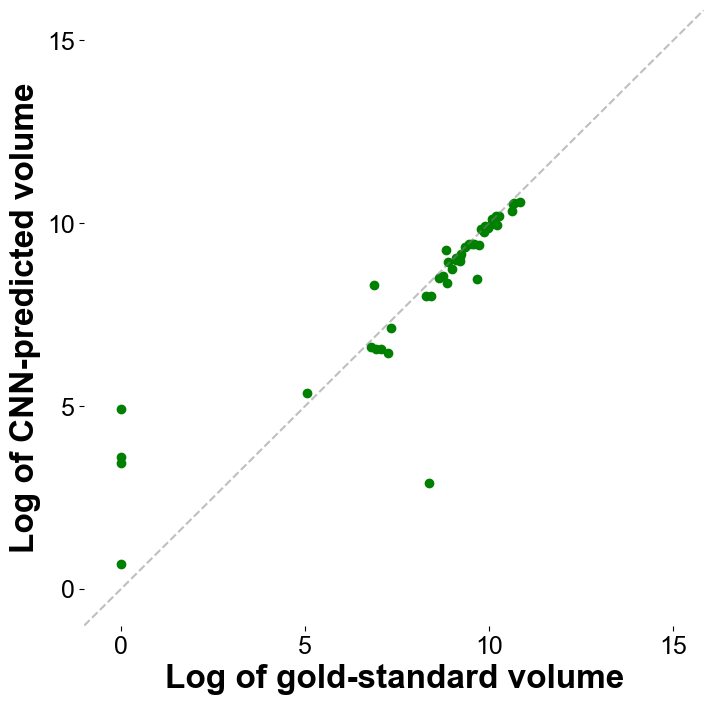

In [186]:
# Correlation 
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.clip(np.log(volume_test_L_frontal), 0, None), np.clip(np.log(volume_prediction_L_frontal), 0, None), linewidth=0, marker='o', color='g')
plt.xlabel('')
plt.ylabel('')
ax.set_xlabel('Log of gold-standard volume', fontsize=24, weight='bold', fontname='Arial')
ax.set_ylabel('Log of CNN-predicted volume', fontsize=24, weight='bold', fontname='Arial')
plt.rcParams['font.family'] = 'Arial'
ax.tick_params(axis='both', which='major', labelsize=18)
plt.locator_params(nbins=5)
plt.xlim( ( min(min(np.clip(np.log(volume_test_L_frontal), 0, None)), min(np.clip(np.log(volume_prediction_L_frontal), 0, None))) -1), (max(max(np.clip(np.log(volume_test_L_frontal), 0, None)), max(np.clip(np.log(volume_prediction_L_frontal), 0, None))) + 5) ) 
plt.ylim( (min(min(np.clip(np.log(volume_test_L_frontal), 0, None)), min(np.clip(np.log(volume_prediction_L_frontal), 0, None))) -1), (max(max(np.clip(np.log(volume_test_L_frontal), 0, None)), max(np.clip(np.log(volume_prediction_L_frontal), 0, None))) + 5) )
ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.axline( (0,0), slope=1, linestyle='--', color='gray', alpha=0.5)
plt.show()

## Export the relevant files

In [187]:
# Loop over the MRIs
for i in range(X_test_full_images_T1.shape[0]):
    # Save the T1 sequence as a .nii.gz file
    T1_MRI = nb.Nifti1Image(X_test_full_images_T1[i, :, :, :], affine=None)
    nb.save(T1_MRI, '/home/ch134560/results/MRI_files/T1_MRI_' + str(i) + '.nii.gz')
    # Save the T2 sequence as a .nii.gz file
    T2_MRI = nb.Nifti1Image(X_test_full_images_T2[i, :, :, :], affine=None)
    nb.save(T2_MRI, '/home/ch134560/results/MRI_files/T2_MRI_' + str(i) + '.nii.gz')
    # Save the FLAIR sequence as a .nii.gz file
    FLAIR_MRI = nb.Nifti1Image(X_test_full_images_FLAIR[i, :, :, :], affine=None)
    nb.save(FLAIR_MRI, '/home/ch134560/results/MRI_files/FLAIR_MRI_' + str(i) + '.nii.gz')
    # Save the true mask sequence as a .nii.gz file
    radiologist_segmentation = nb.Nifti1Image(Y_test_full_images[i, :, :, :], affine=None)
    nb.save(radiologist_segmentation, '/home/ch134560/results/segmentations/radiologist_segmentation_' + str(i) + '.nii.gz')   
    # Save the CNN-predicted mask sequence as a .nii.gz file
    CNN_segmentation = nb.Nifti1Image(Y_predictions_full_images[i, :, :, :], affine=None)
    nb.save(CNN_segmentation, '/home/ch134560/results/segmentations/CNN_segmentation_' + str(i) + '.nii.gz')               
    # Save the compared segmentations (as a segmentation)
    comparison_volume = np.zeros((Y_test_full_images[i, :, :, :].shape[0], Y_test_full_images[i, :, :, :].shape[1], Y_test_full_images[i, :, :, :].shape[2]))
    comparison_volume[(Y_test_full_images[i, :, :, :] == 1) & (Y_predictions_full_images[i, :, :, :] == 0)] = 1
    comparison_volume[(Y_test_full_images[i, :, :, :] == 0) & (Y_predictions_full_images[i, :, :, :] == 1)] = 3
    comparison_volume[(Y_test_full_images[i, :, :, :] == 1) & (Y_predictions_full_images[i, :, :, :] == 1)] = 2
    comparison_segmentation = nb.Nifti1Image(comparison_volume, affine=None)
    nb.save(comparison_segmentation, '/home/ch134560/results/comparison_segmentations/comparison_segmentation_' + str(i) + '.nii.gz')  
    # Save the compared segmentations (as a main file)
    comparison_volume = np.zeros((Y_test_full_images[i, :, :, :].shape[0], Y_test_full_images[i, :, :, :].shape[1], Y_test_full_images[i, :, :, :].shape[2], 3))
    comparison_volume[(Y_test_full_images[i, :, :, :] == 1) & (Y_predictions_full_images[i, :, :, :] == 0)] = [1, 0, 0]
    comparison_volume[(Y_test_full_images[i, :, :, :] == 0) & (Y_predictions_full_images[i, :, :, :] == 1)] = [0, 0, 1]
    comparison_volume[(Y_test_full_images[i, :, :, :] == 1) & (Y_predictions_full_images[i, :, :, :] == 1)] = [0, 1, 0]
    comparison_segmentation_main = nb.Nifti1Image(comparison_volume, affine=None)
    nb.save(comparison_segmentation_main, '/home/ch134560/results/comparison_main/comparison_segmentation_main_' + str(i) + '.nii.gz')
    # Save the volume results in a txt file
    f = open('/home/ch134560/results/volume_results.txt', "a")
    f.write('TUBER BURDEN IS PRESENTED AS: TOTAL TUBER VOLUME IN THAT REGION IN MM3 (PROPORTION OF TUBER VOLUME IN THAT REGION)' + '\n')
    f.write('FOR EXAMPLE, IN R_frontal, THE INTEGER NUMBER IS THE TOTAL TUBER VOLUME IN THE RIGHT FRONTAL LOBE AND THE DECIMAL NUMBER IN PARENTHESES IS THE TOTAL TUBER VOLUME IN THE RIGHT FRONTAL LOBE DIVIDED BY THE TOTAL VOLUME OF THE RIGHT FRONTAL LOBE MASK)' + '\n') 
    f.write('\n')
    f.write('\n')
    f.write('For MRI: ' + str(i) + '\n')
    f.write('TUBER VOLUMES (MNI SPACE AND 256x256x256) BASED ON THE RADIOLOGIST SEGMENTATION: ' + '\n')
    f.write('total: ' + str(volume_test[i]) + ' mm3' + '\n')
    f.write('gray_matter: ' + str(volume_test_gray_matter[i]) + ' mm3' + ' (' + str(gold_standard_proportion_gray_matter[i]) + ')' + '\n')
    f.write('R_frontal: ' + str(volume_test_R_frontal[i]) + ' mm3' + ' (' + str(gold_standard_proportion_R_frontal[i]) + ')'  + '\n')
    f.write('L_frontal: ' + str(volume_test_L_frontal[i]) + ' mm3' + ' (' + str(gold_standard_proportion_L_frontal[i]) + ')'  + '\n')
    f.write('R_temporal: ' + str(volume_test_R_temporal[i]) + ' mm3' + ' (' + str(gold_standard_proportion_R_temporal[i]) + ')'  + '\n')
    f.write('L_temporal: ' + str(volume_test_L_temporal[i]) + ' mm3' + ' (' + str(gold_standard_proportion_L_temporal[i]) + ')'  + '\n')
    f.write('R_parietal: ' + str(volume_test_R_parietal[i]) + ' mm3' + ' (' + str(gold_standard_proportion_R_parietal[i]) + ')'  + '\n')
    f.write('L_parietal: ' + str(volume_test_L_parietal[i]) + ' mm3' + ' (' + str(gold_standard_proportion_L_parietal[i]) + ')'  + '\n')
    f.write('R_occipital: ' + str(volume_test_R_occipital[i]) + ' mm3' + ' (' + str(gold_standard_proportion_R_occipital[i]) + ')'  + '\n')
    f.write('L_occipital: ' + str(volume_test_L_occipital[i]) + ' mm3' + ' (' + str(gold_standard_proportion_L_occipital[i]) + ')'  + '\n')
    f.write('\n')
    f.write('\n')
    f.write('TUBER VOLUMES (MNI SPACE AND 256x256x256) BASED ON THE CNN SEGMENTATION: ' + '\n')
    f.write('total: ' + str(volume_prediction[i]) + ' mm3' + '\n')
    f.write('gray_matter: ' + str(volume_prediction_gray_matter[i]) + ' mm3' + ' (' + str(prediction_proportion_gray_matter[i]) + ')' + '\n')
    f.write('R_frontal: ' + str(volume_prediction_R_frontal[i]) + ' mm3' + ' (' + str(prediction_proportion_R_frontal[i]) + ')'  + '\n')
    f.write('L_frontal: ' + str(volume_prediction_L_frontal[i]) + ' mm3' + ' (' + str(prediction_proportion_L_frontal[i]) + ')'  + '\n')
    f.write('R_temporal: ' + str(volume_prediction_R_temporal[i]) + ' mm3' + ' (' + str(prediction_proportion_R_temporal[i]) + ')'  + '\n')
    f.write('L_temporal: ' + str(volume_prediction_L_temporal[i]) + ' mm3' + ' (' + str(prediction_proportion_L_temporal[i]) + ')'  + '\n')
    f.write('R_parietal: ' + str(volume_prediction_R_parietal[i]) + ' mm3' + ' (' + str(prediction_proportion_R_parietal[i]) + ')'  + '\n')
    f.write('L_parietal: ' + str(volume_prediction_L_parietal[i]) + ' mm3' + ' (' + str(prediction_proportion_L_parietal[i]) + ')'  + '\n')
    f.write('R_occipital: ' + str(volume_prediction_R_occipital[i]) + ' mm3' + ' (' + str(prediction_proportion_R_occipital[i]) + ')'  + '\n')
    f.write('L_occipital: ' + str(volume_prediction_L_occipital[i]) + ' mm3' + ' (' + str(prediction_proportion_L_occipital[i]) + ')'  + '\n')
    f.write('\n')
    f.write('\n')
    f.close()